In [1]:
!ls results/prelim/* | wc -l

1152


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
import numpy as np
from numpy.polynomial import Polynomial
import seaborn as sns
from pymoo.indicators.hv import HV
import os
import scikit_posthocs as sp
import traceback
from itertools import chain
from tqdm.notebook import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('seaborn')

/tmp/ipykernel_1955262/1656319566.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


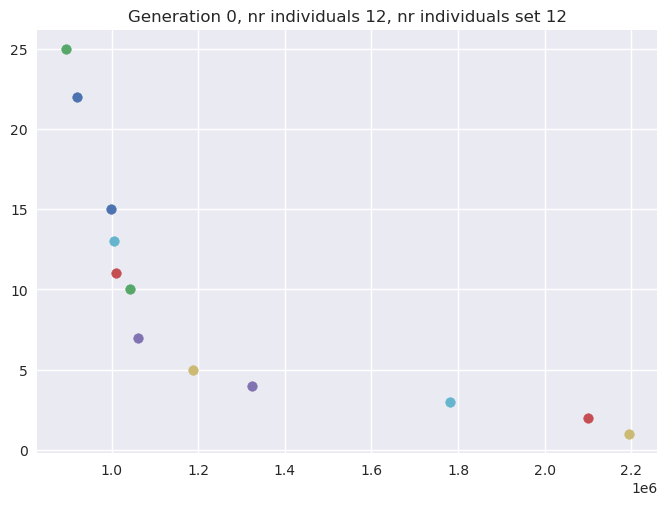

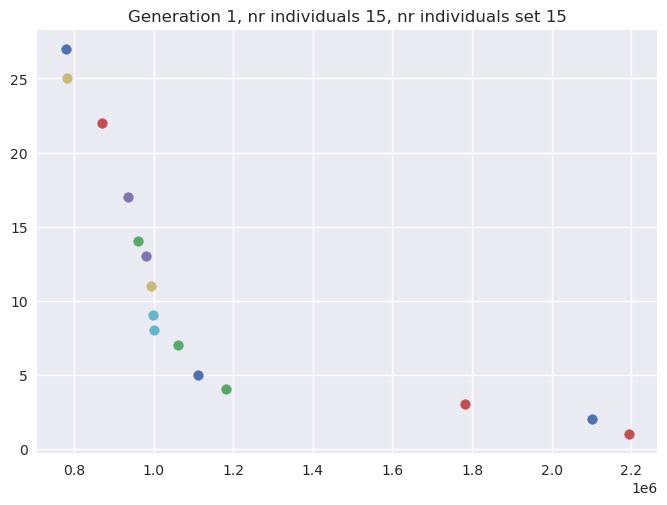

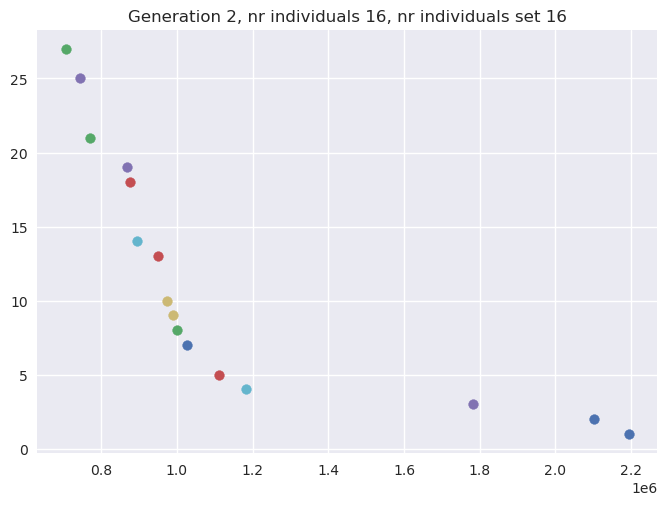

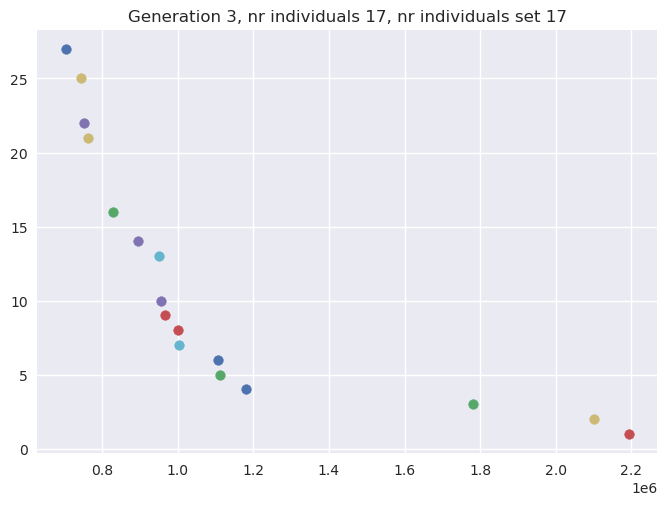

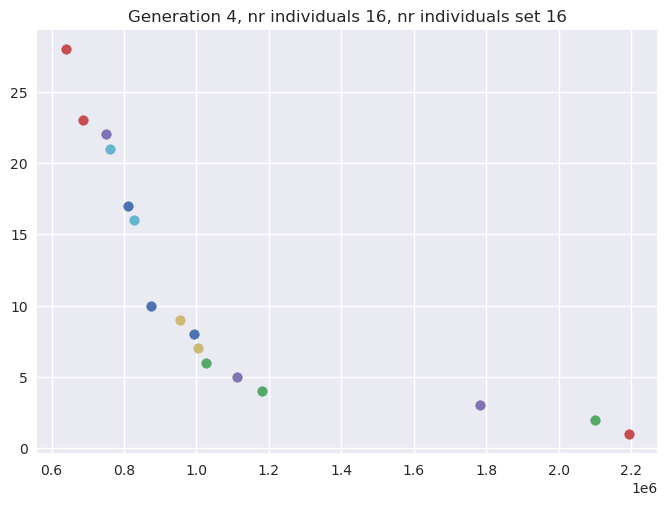

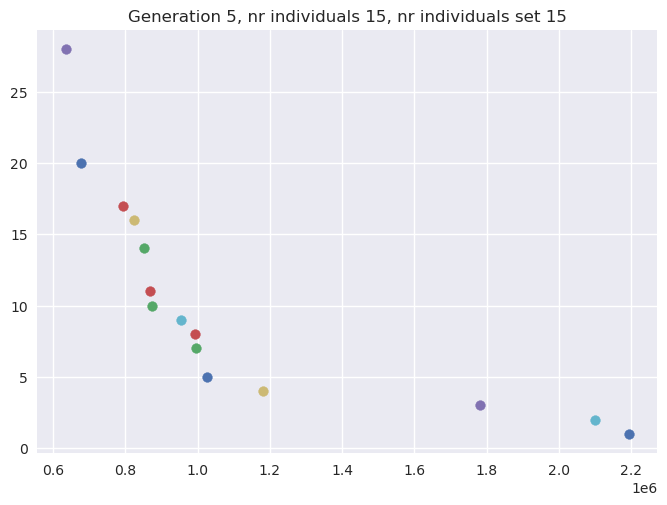

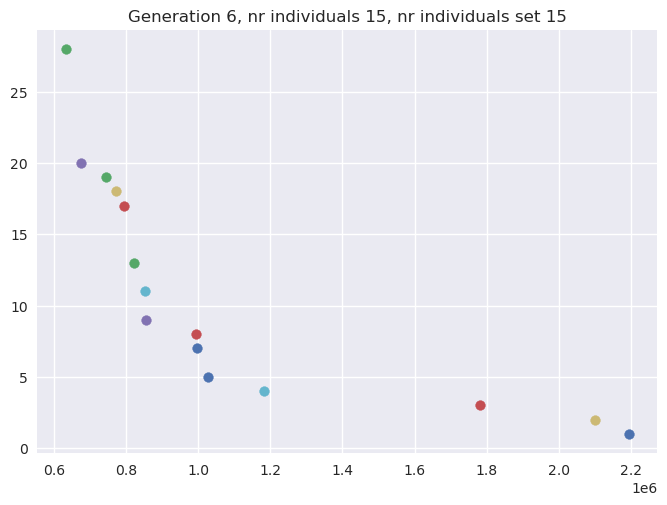

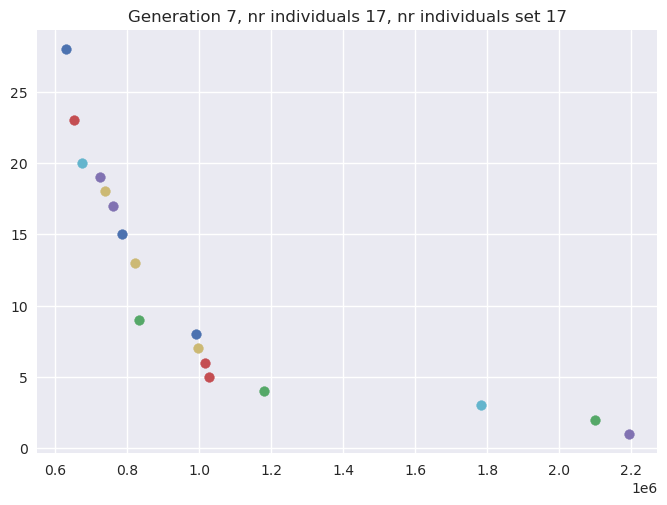

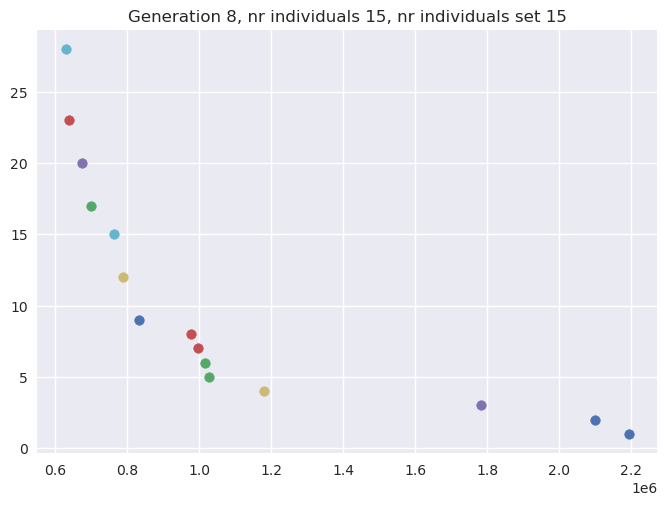

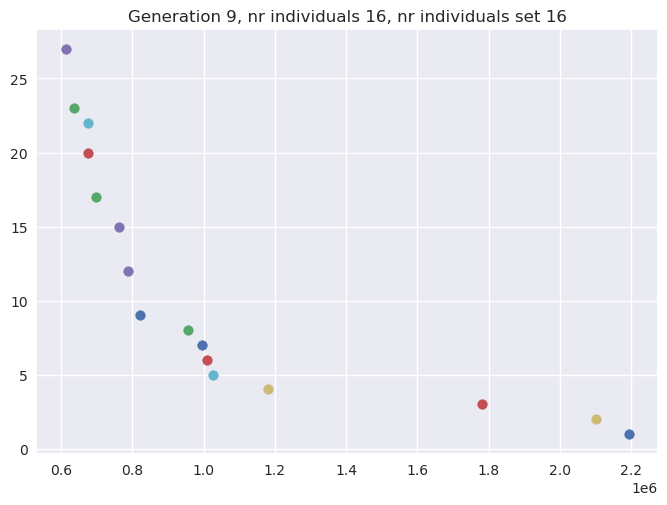

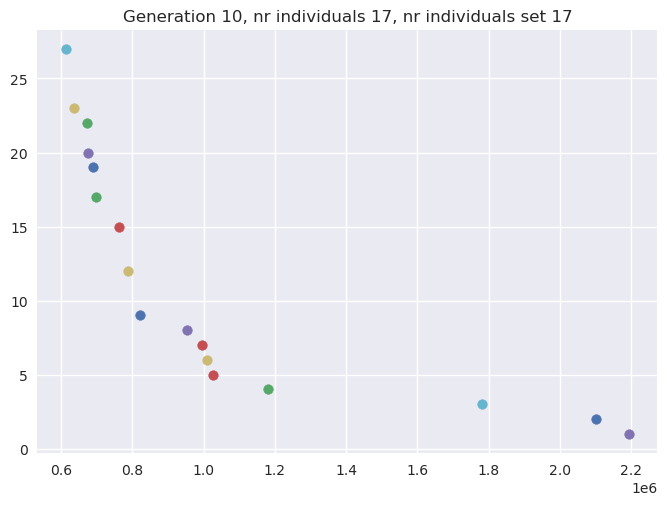

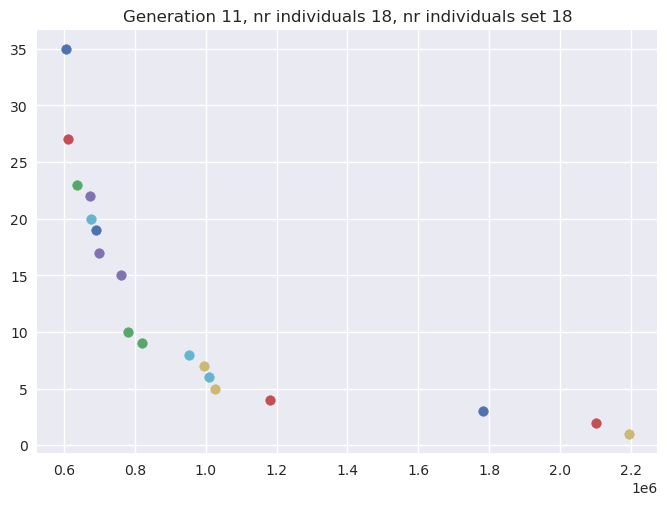

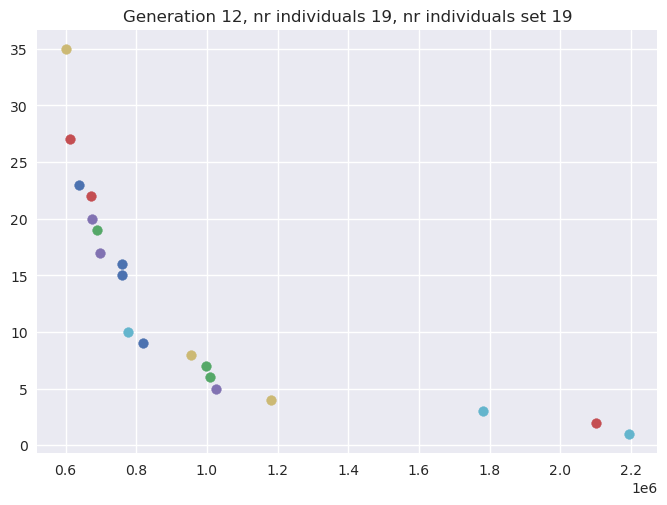

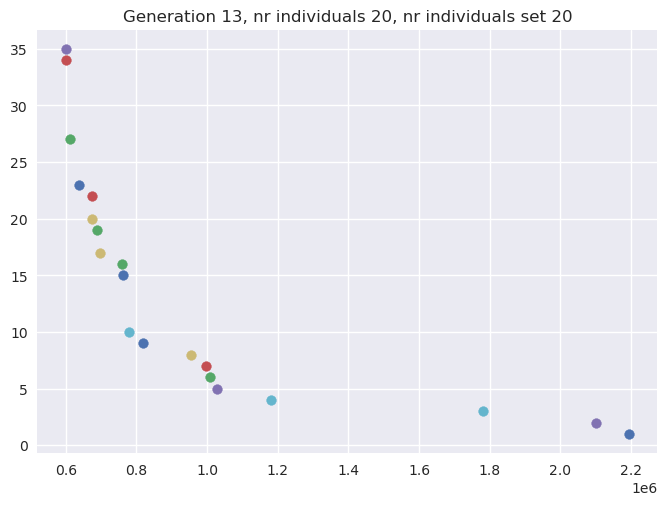

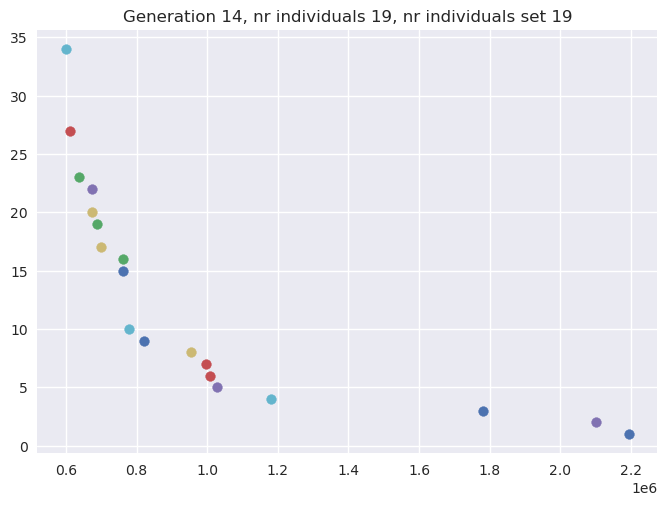

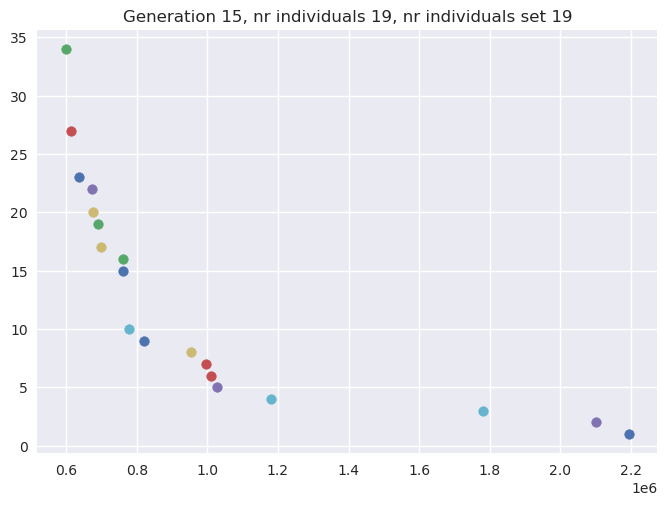

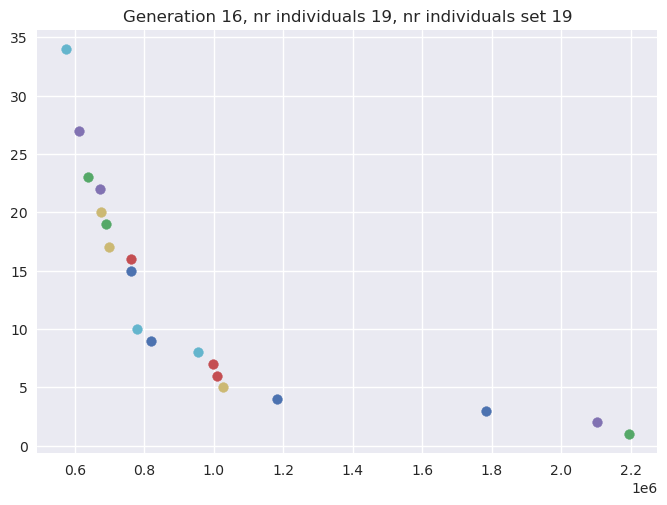

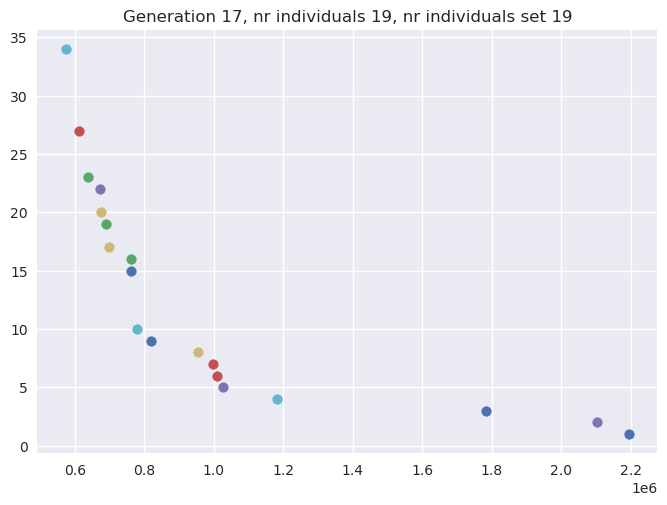

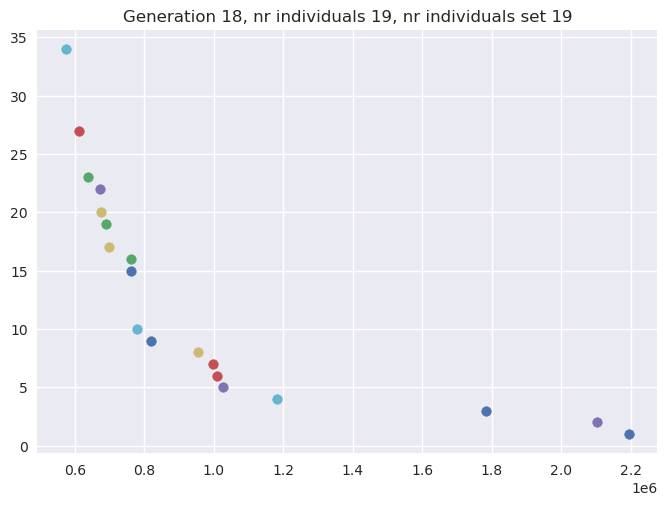

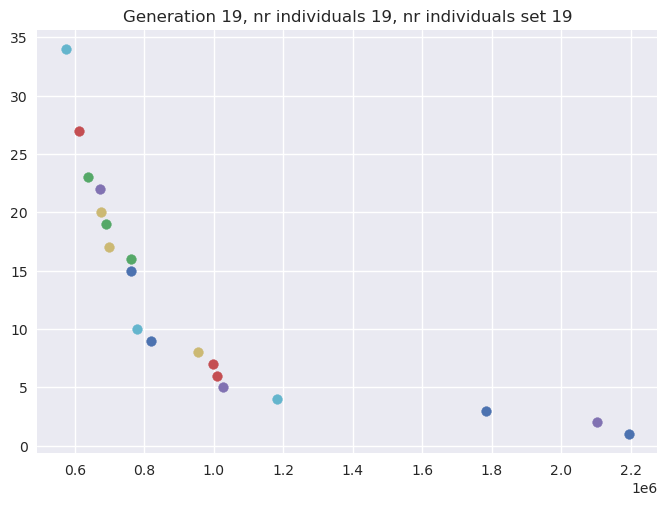

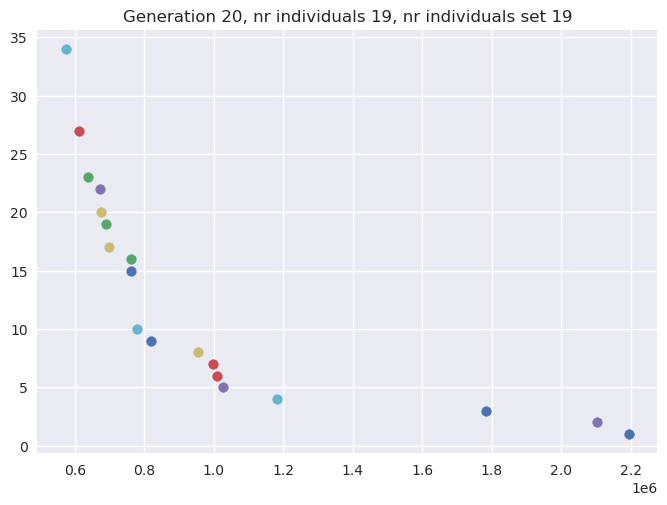

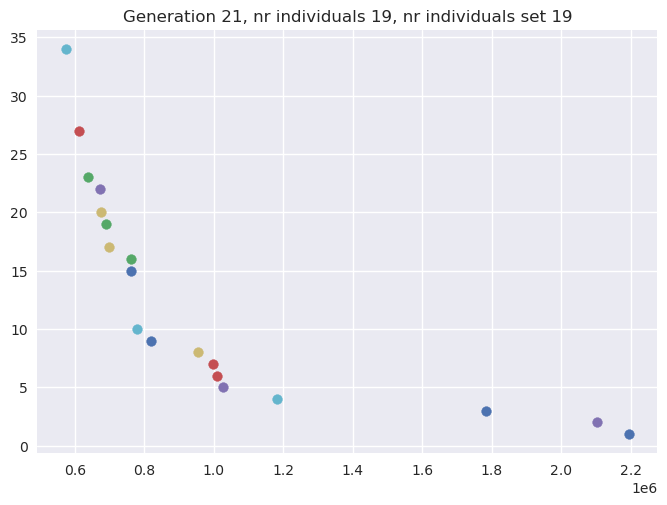

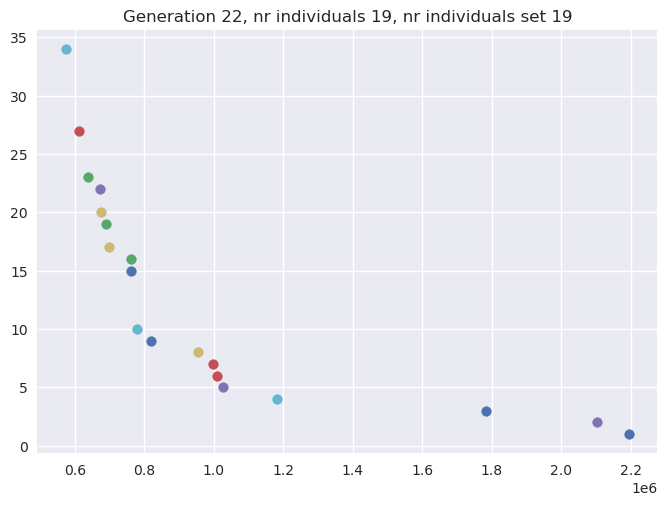

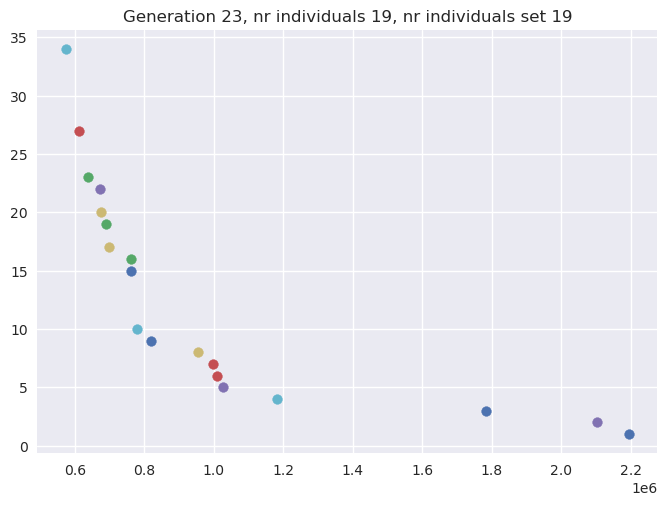

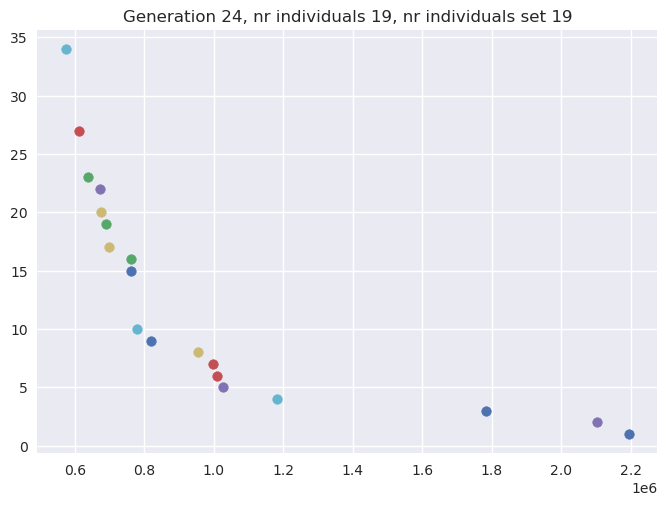

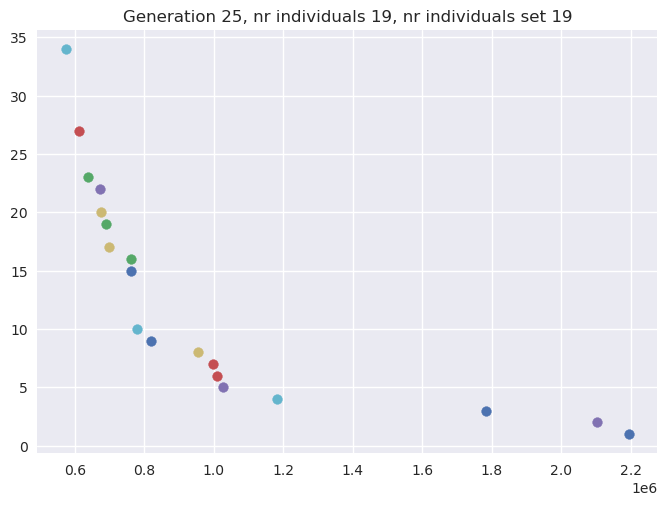

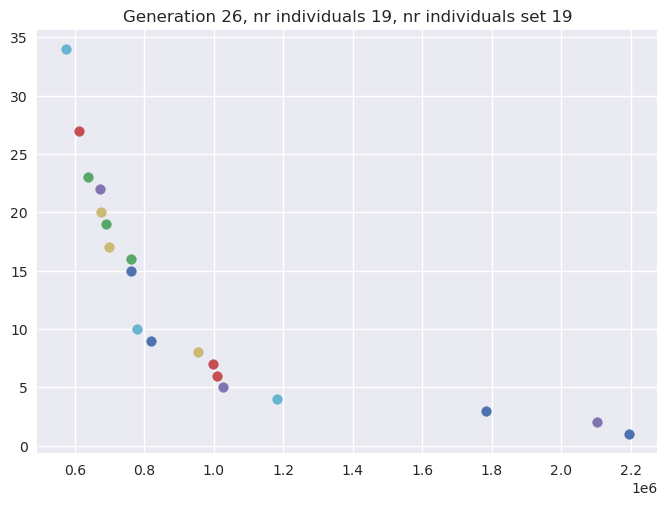

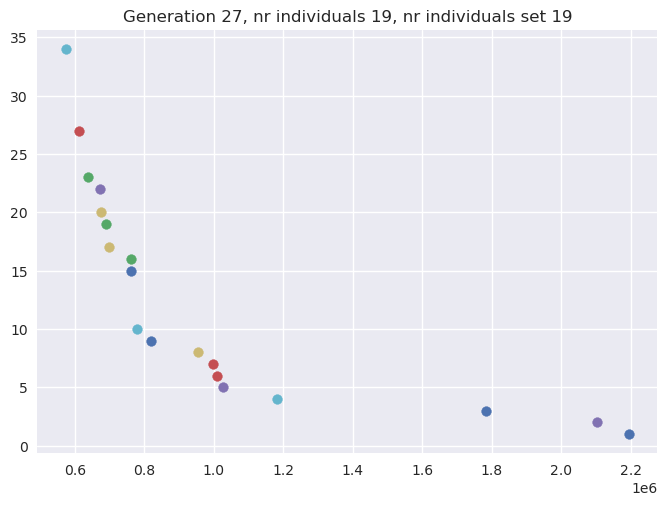

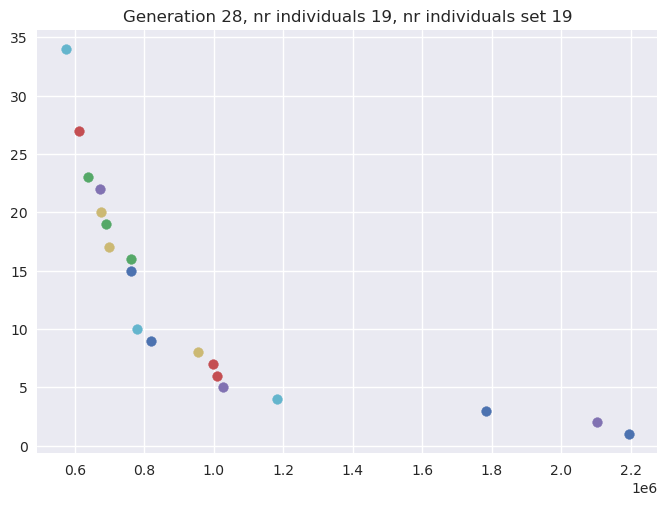

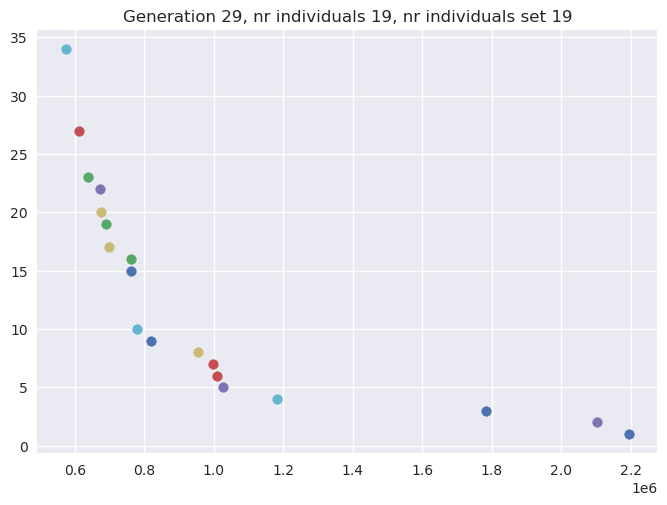

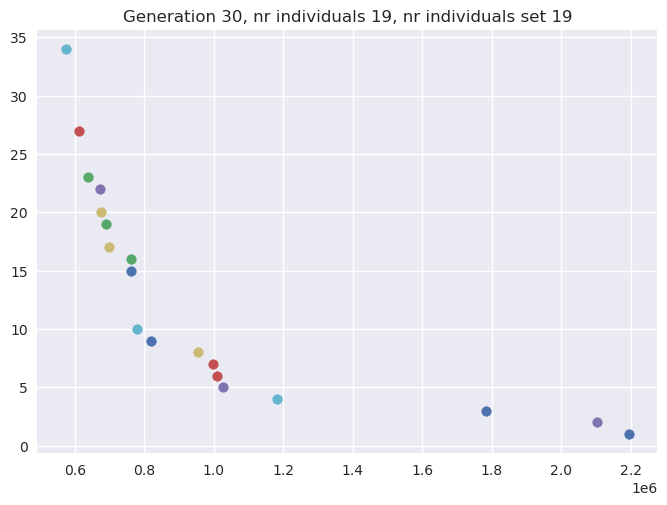

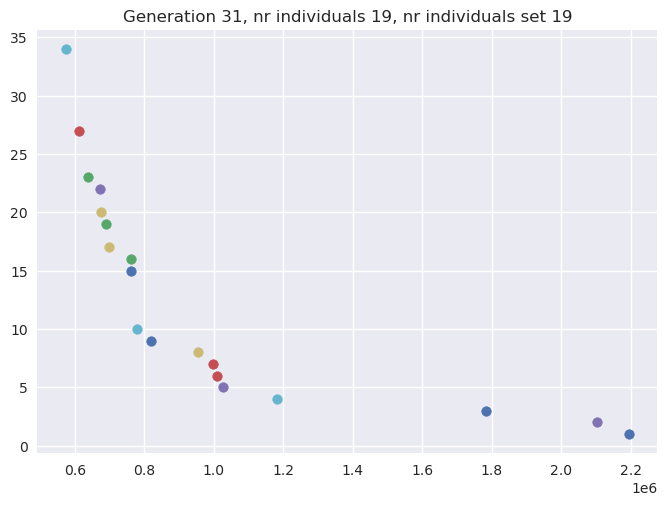

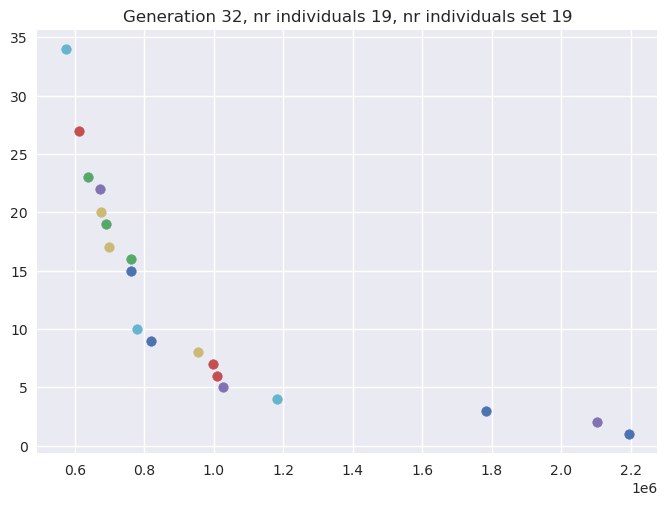

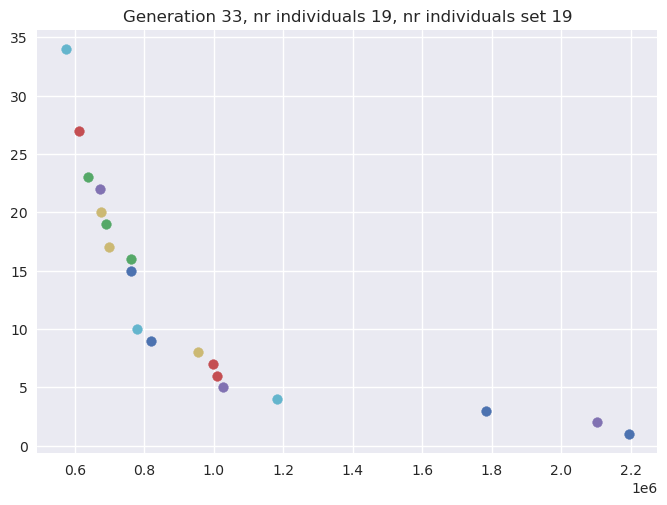

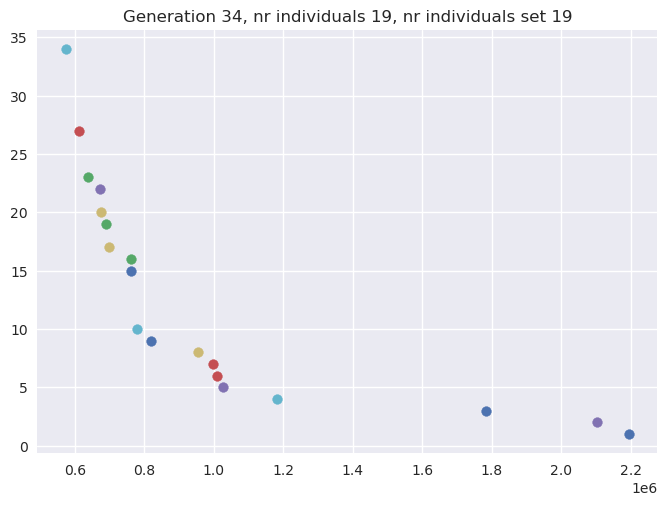

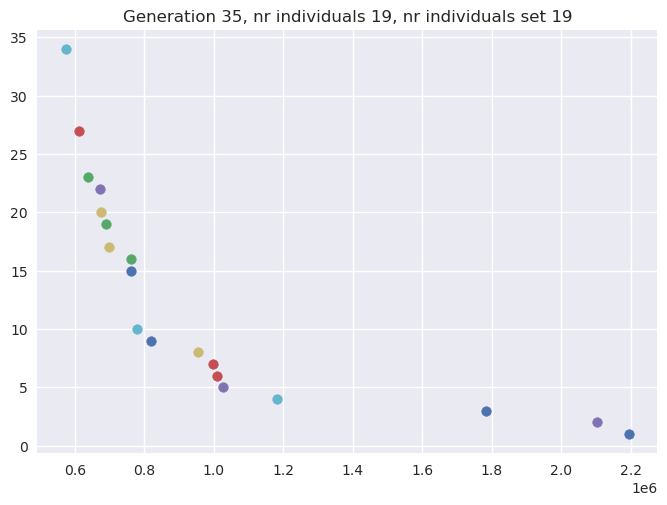

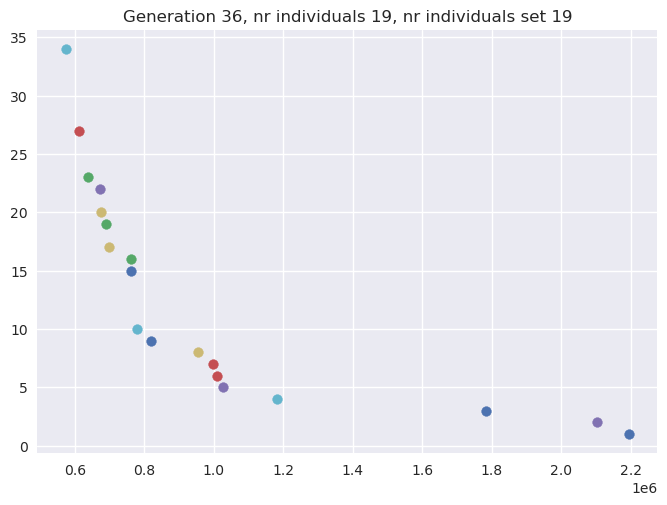

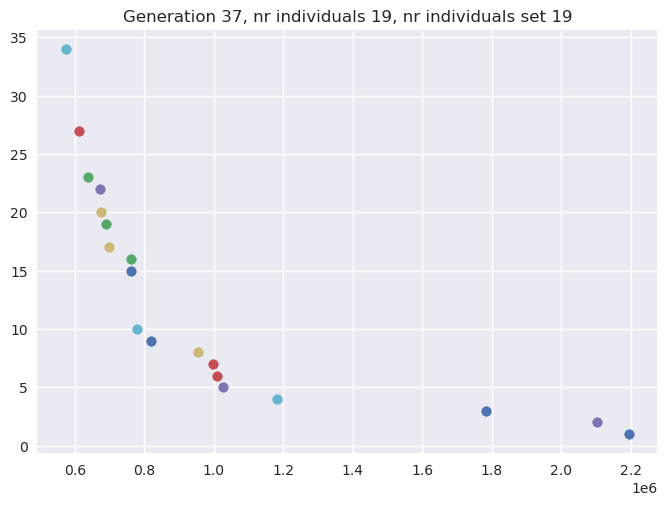

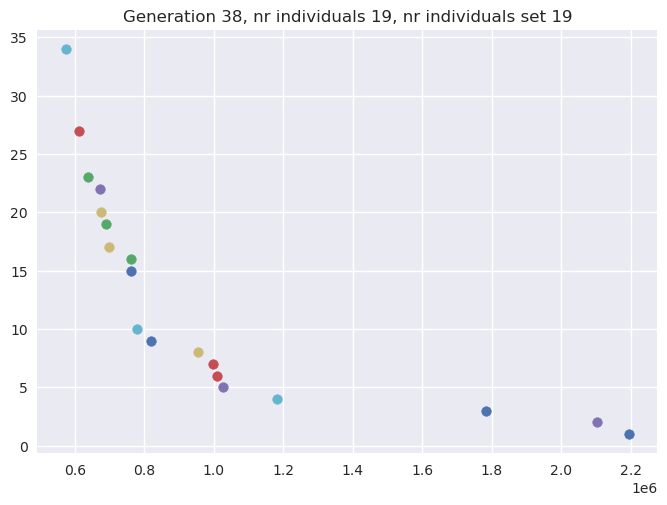

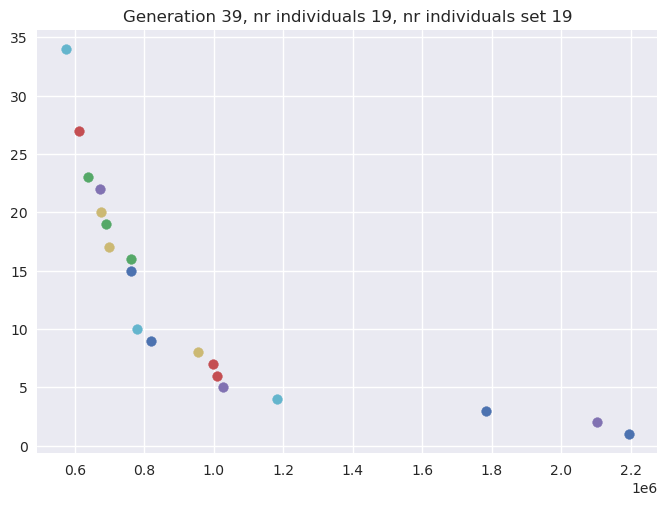

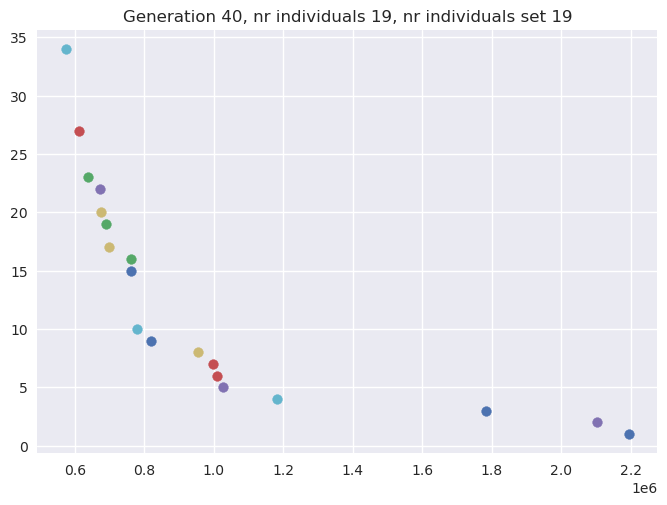

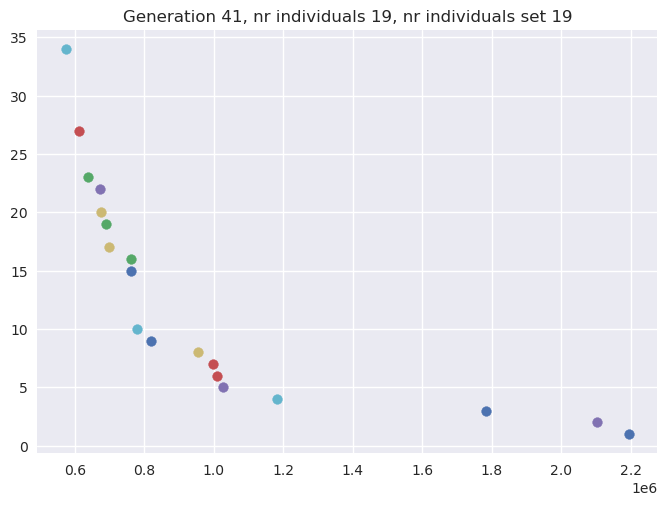

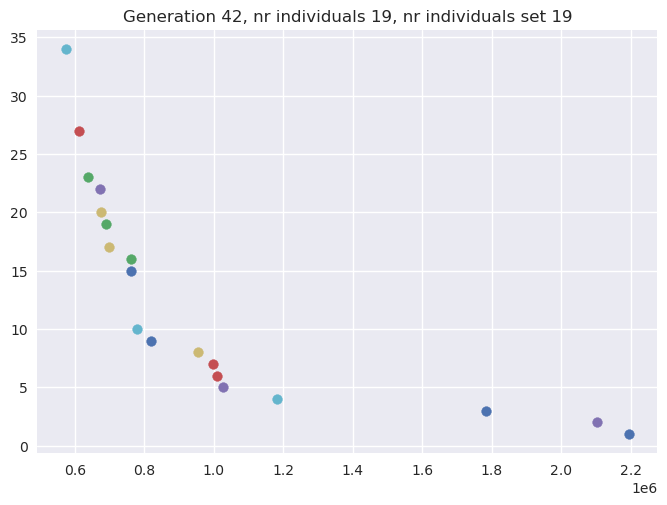

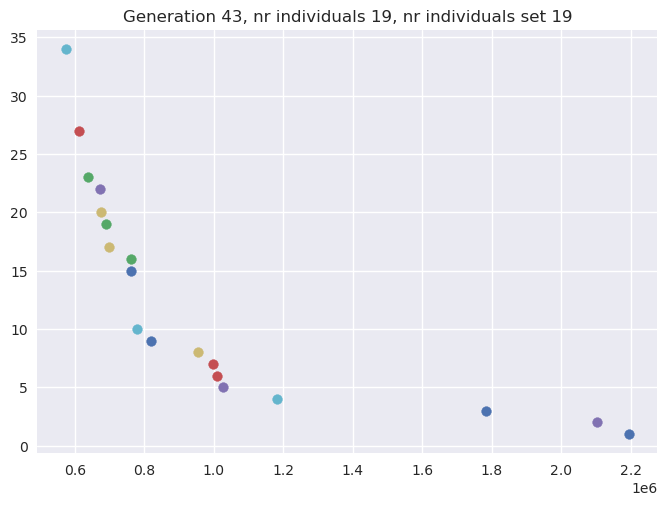

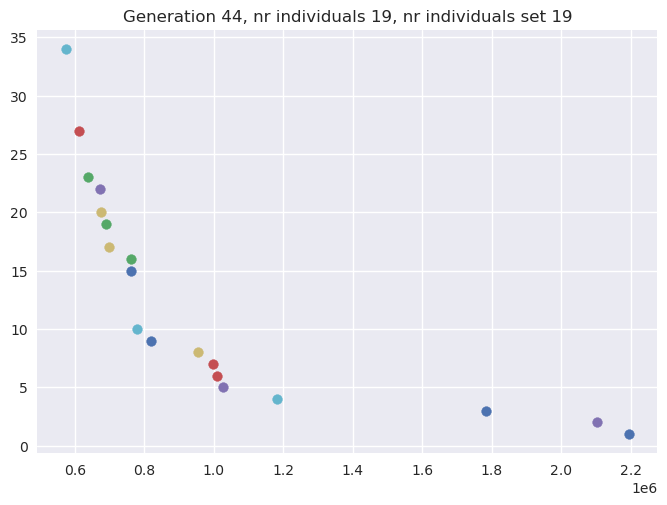

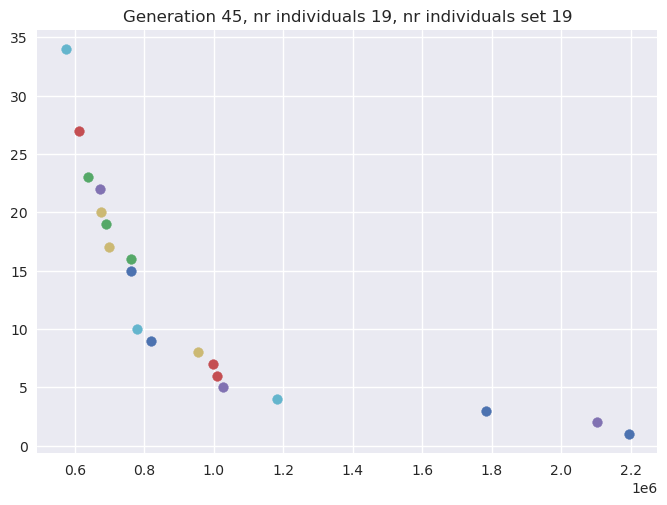

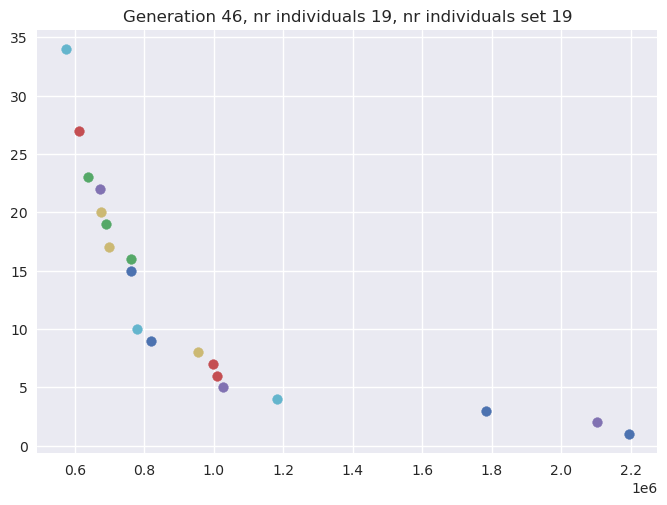

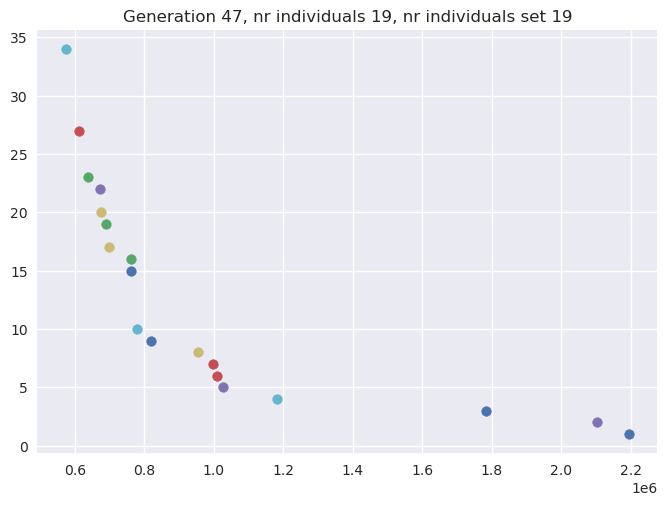

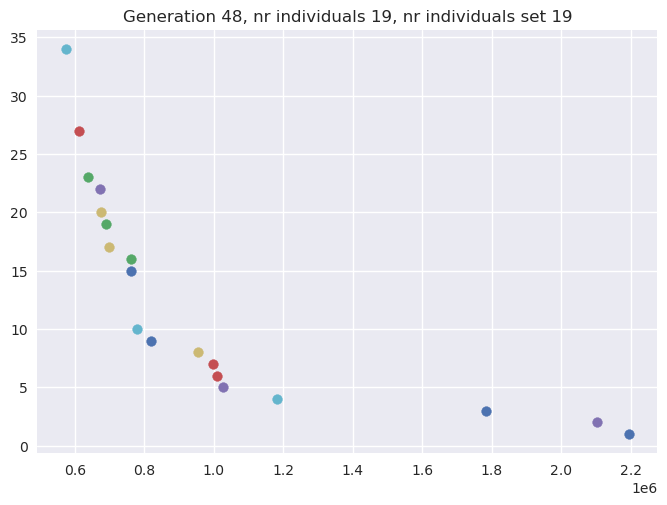

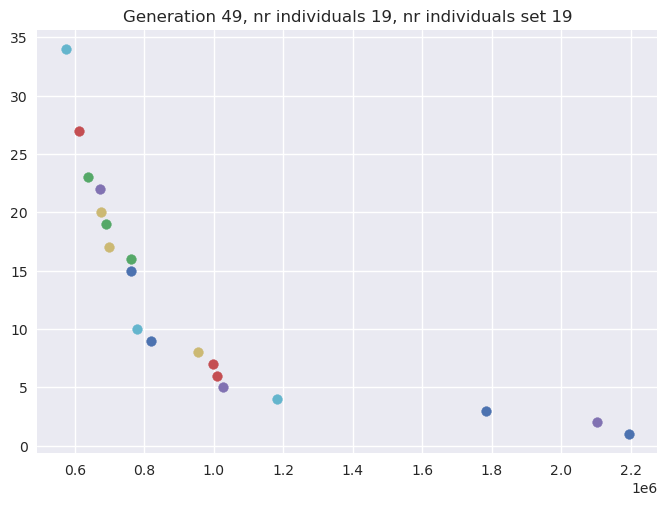

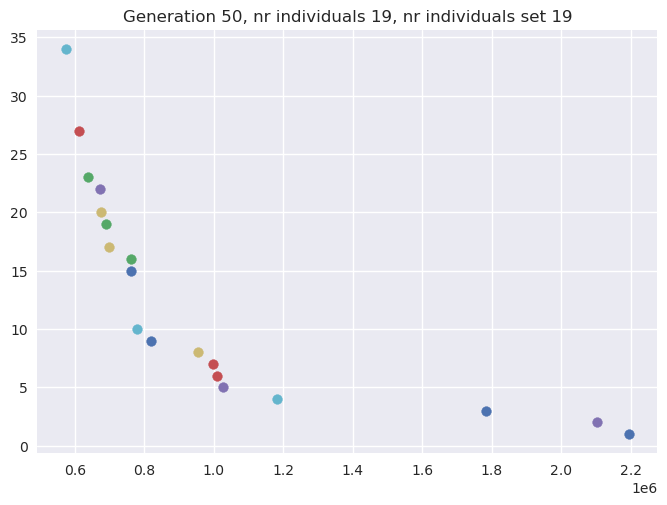

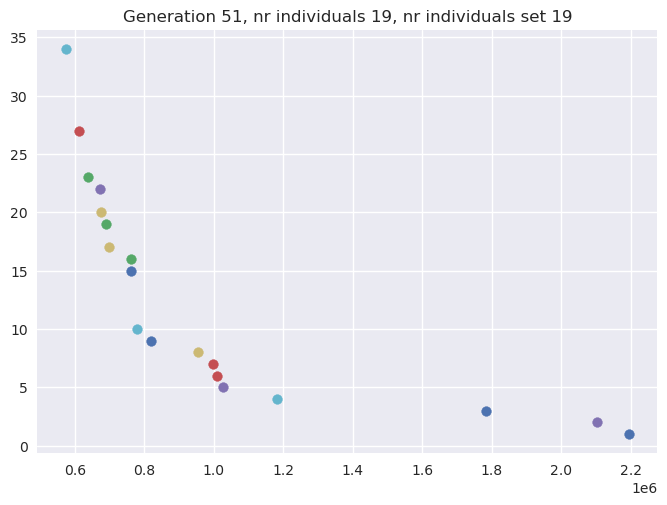

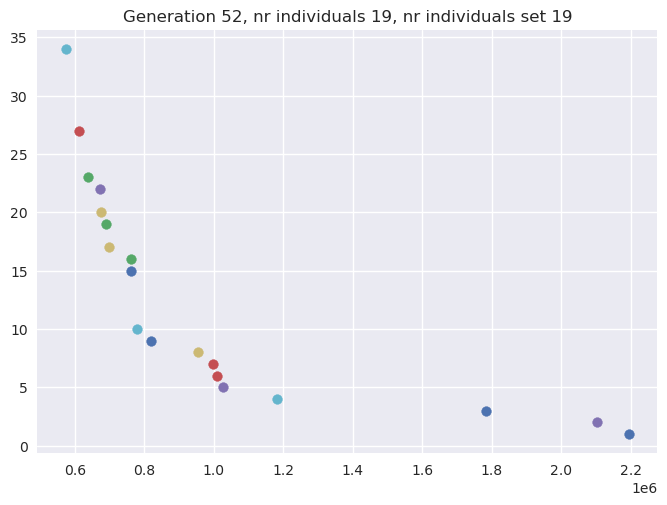

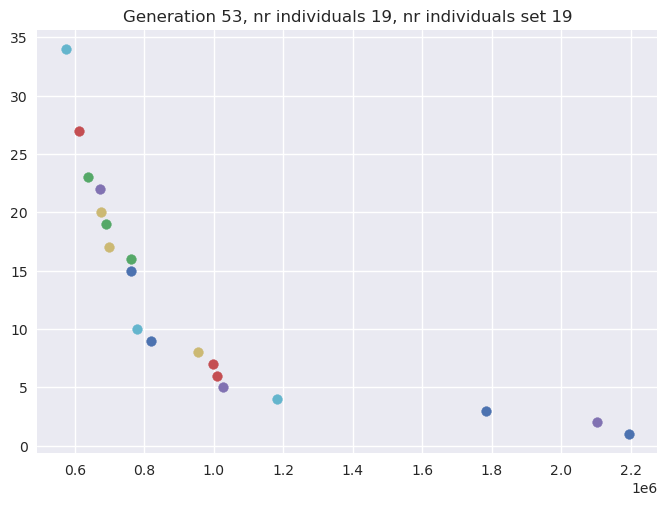

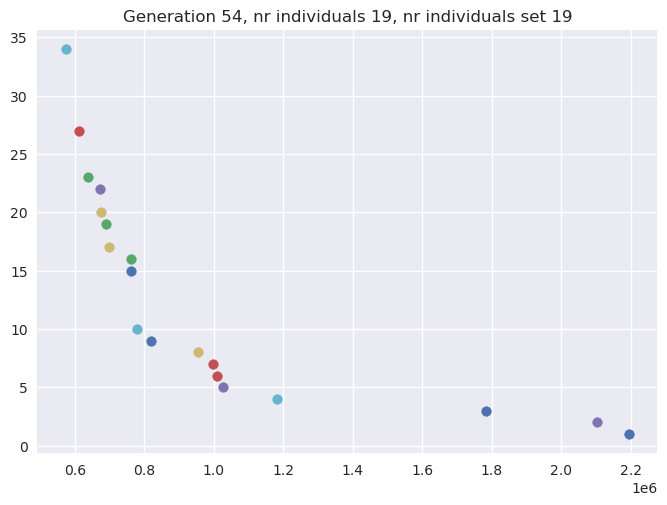

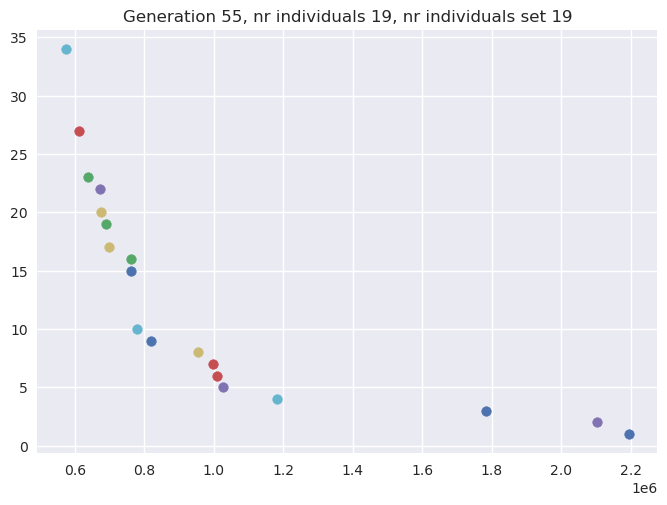

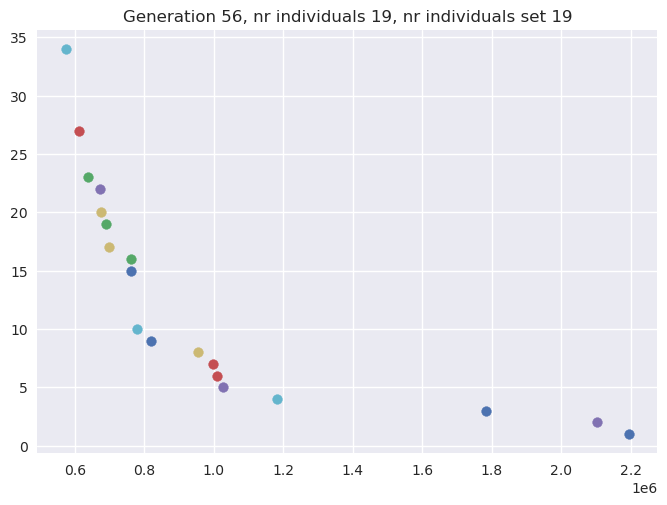

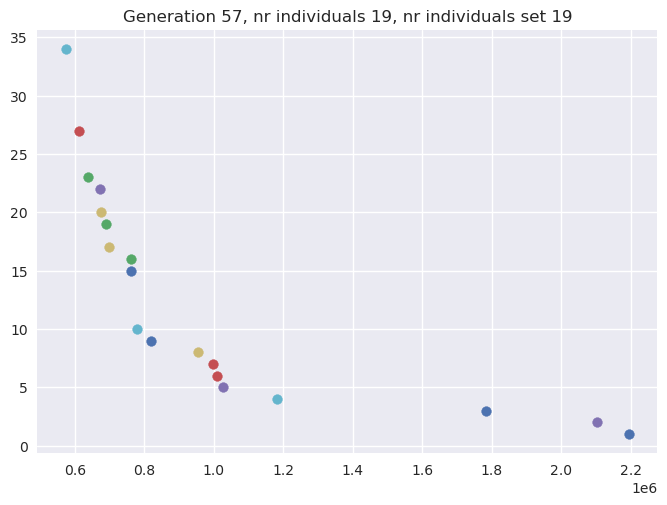

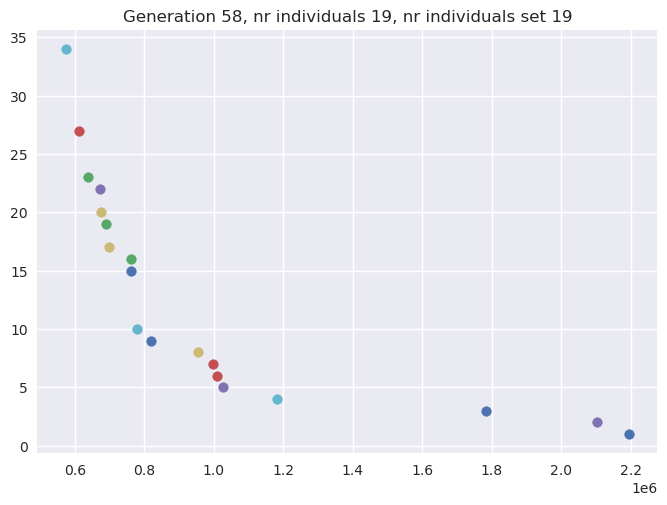

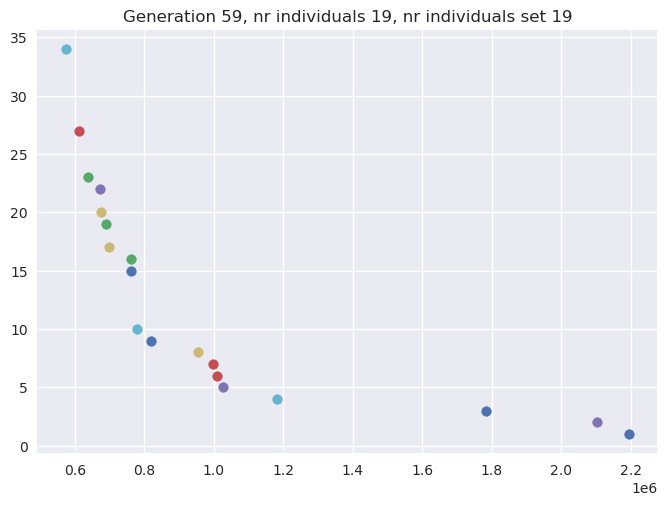

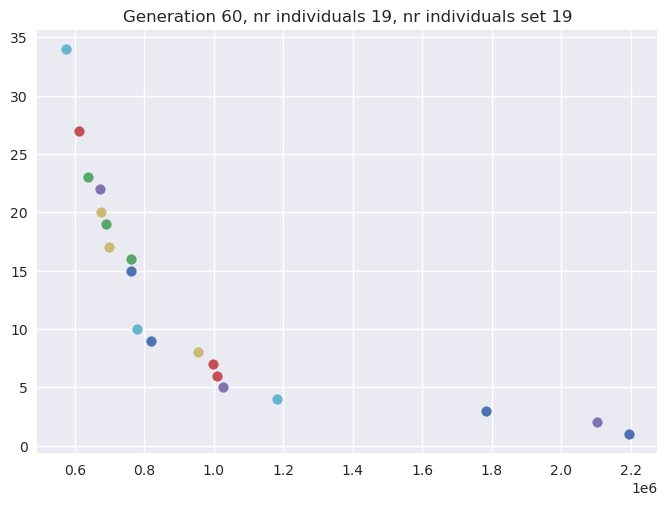

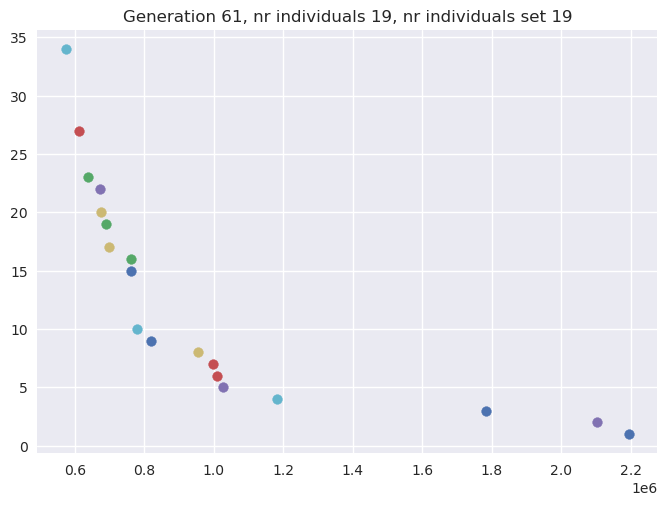

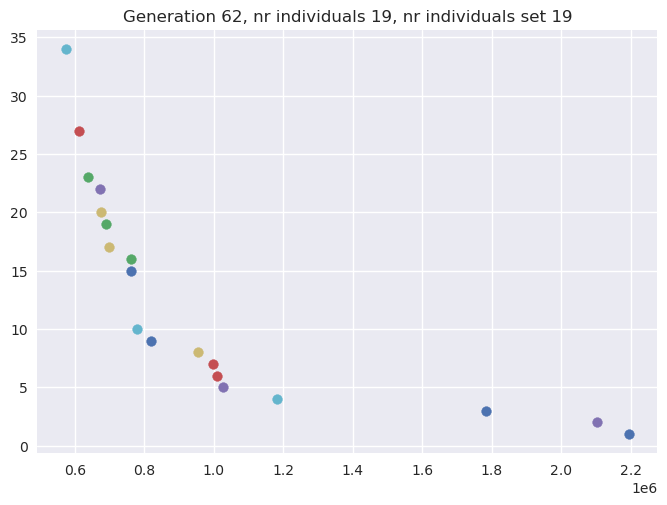

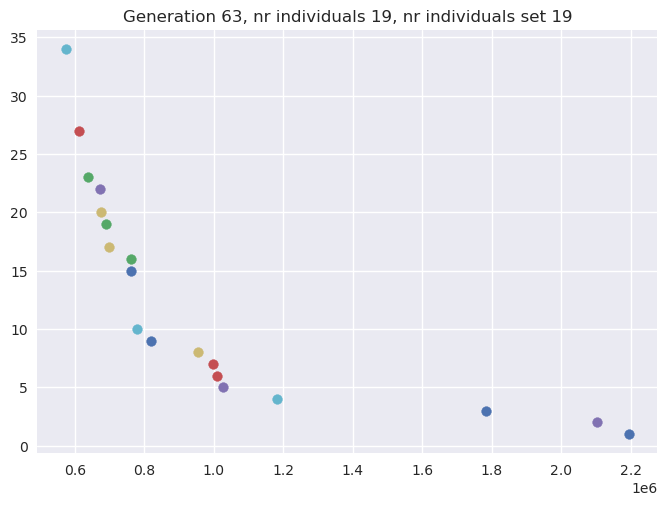

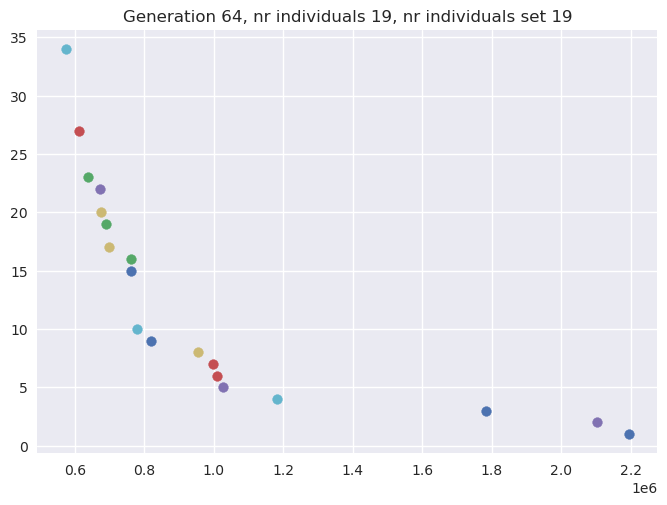

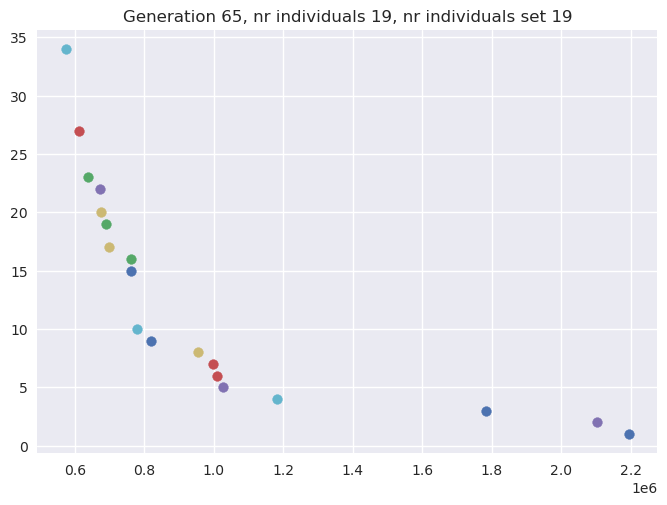

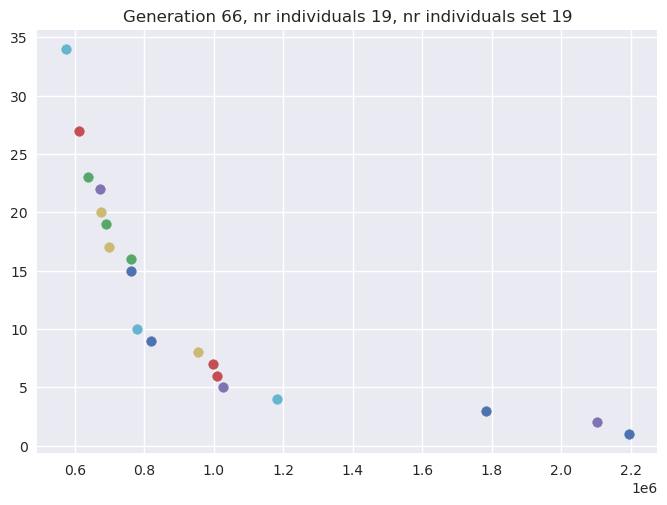

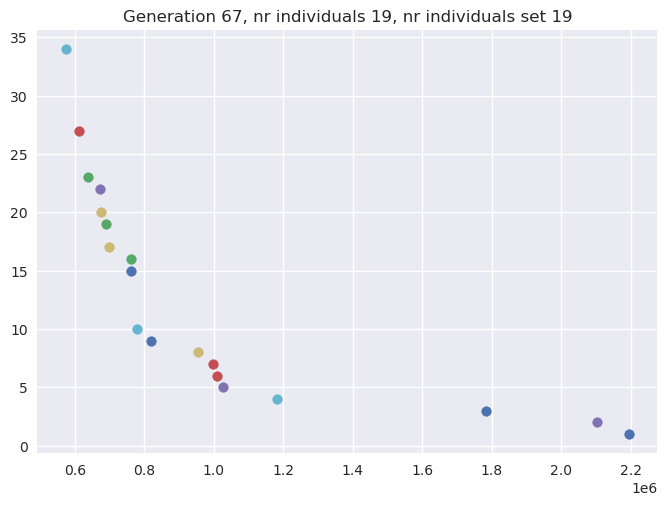

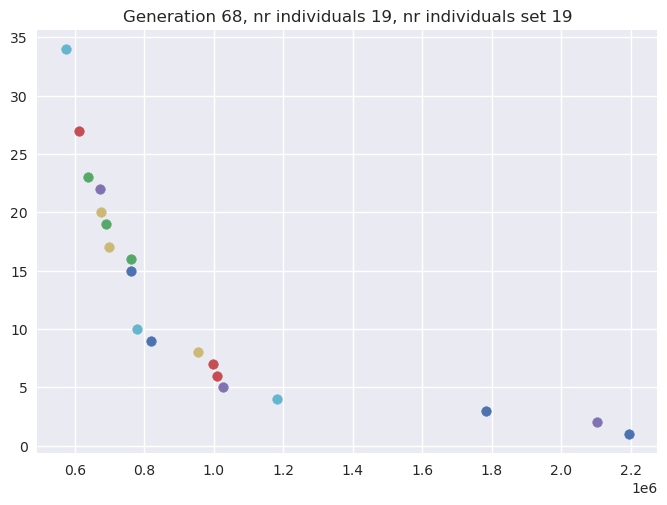

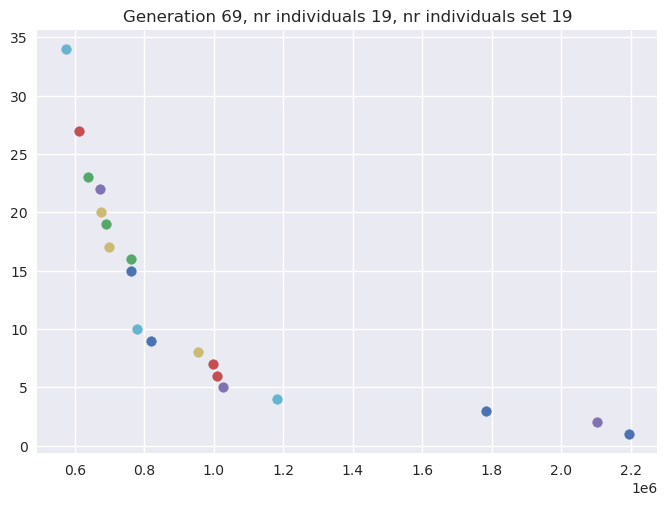

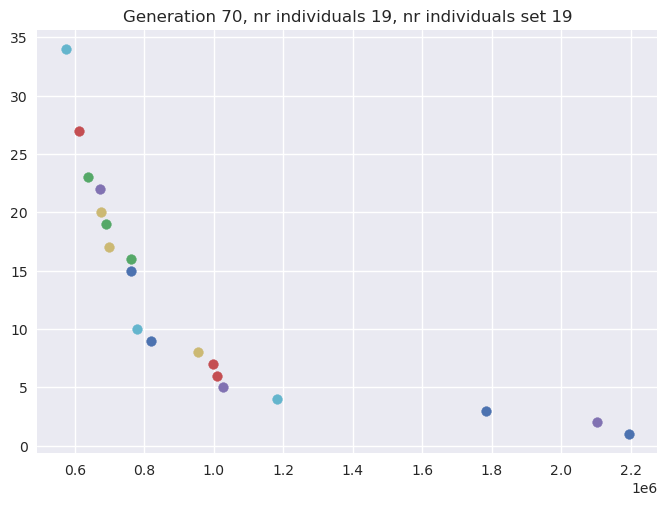

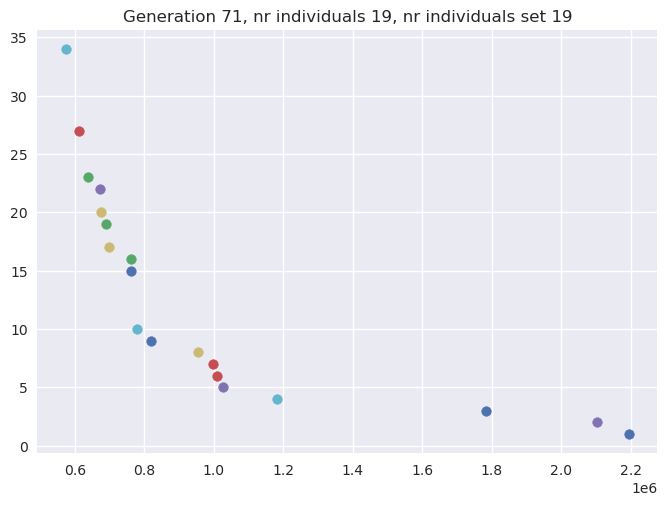

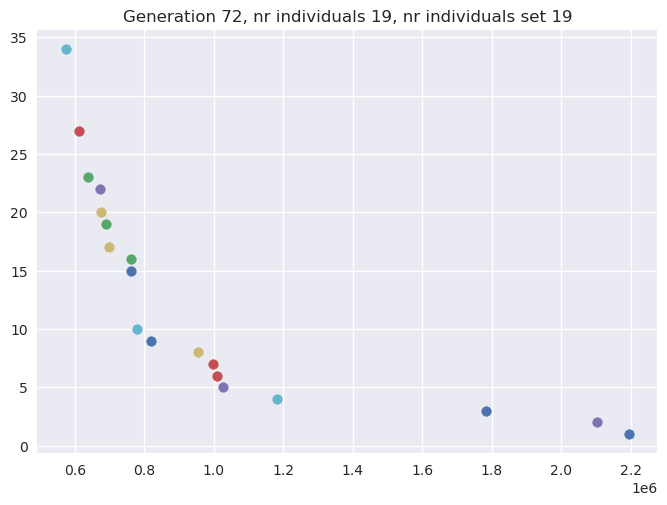

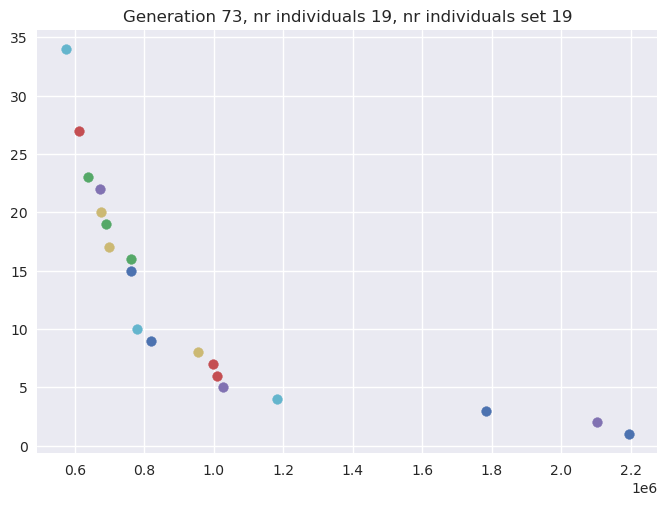

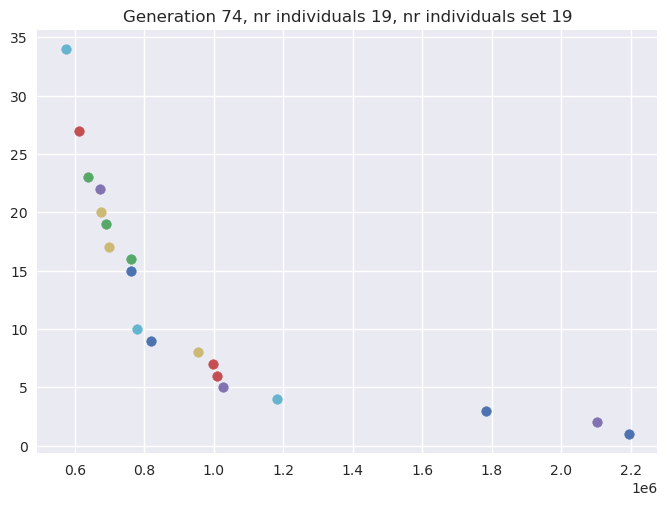

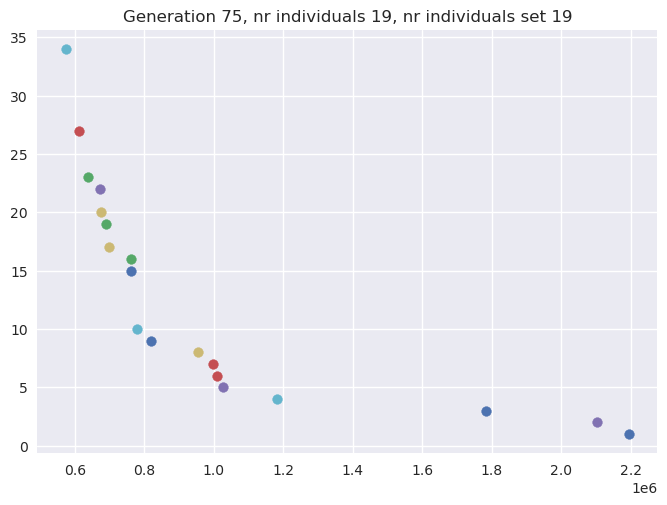

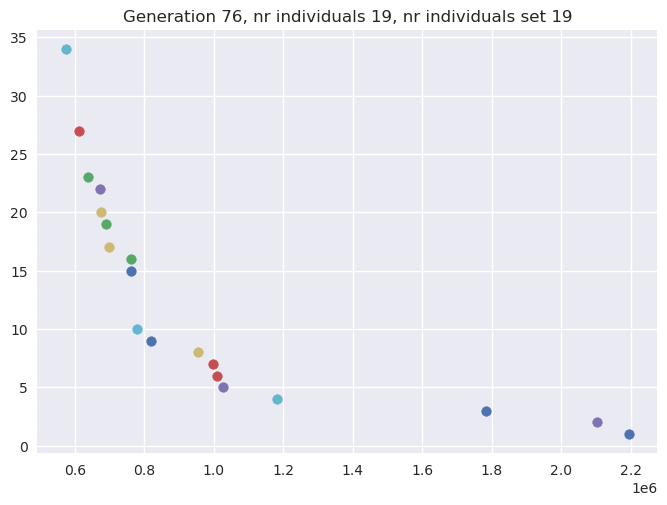

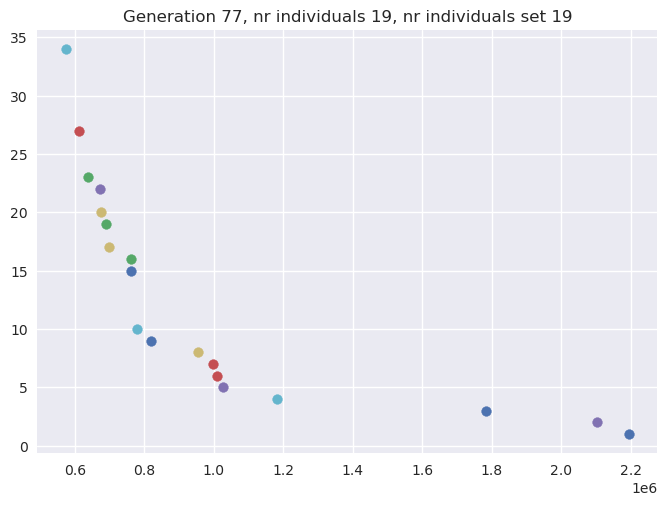

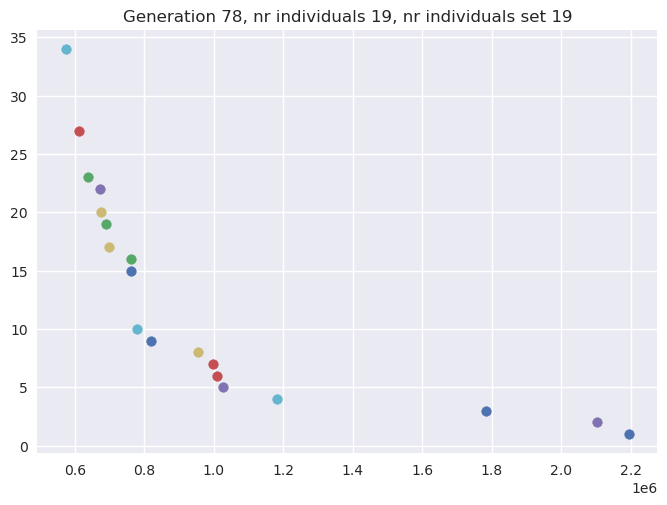

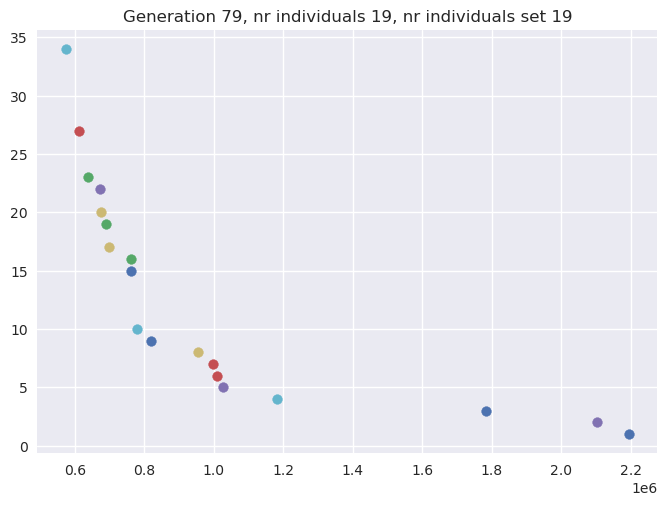

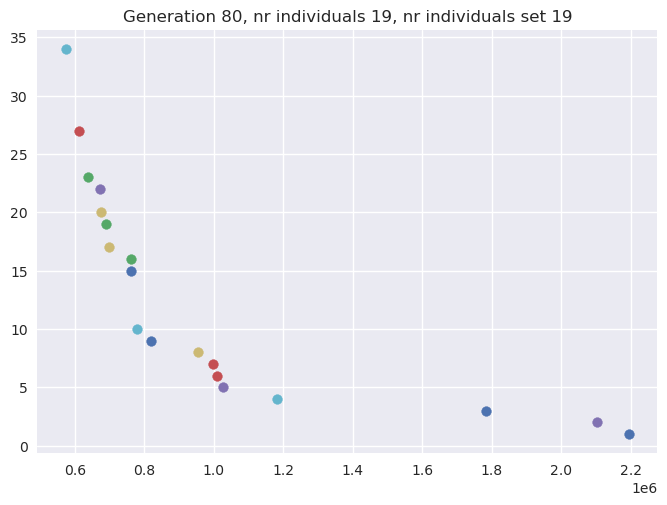

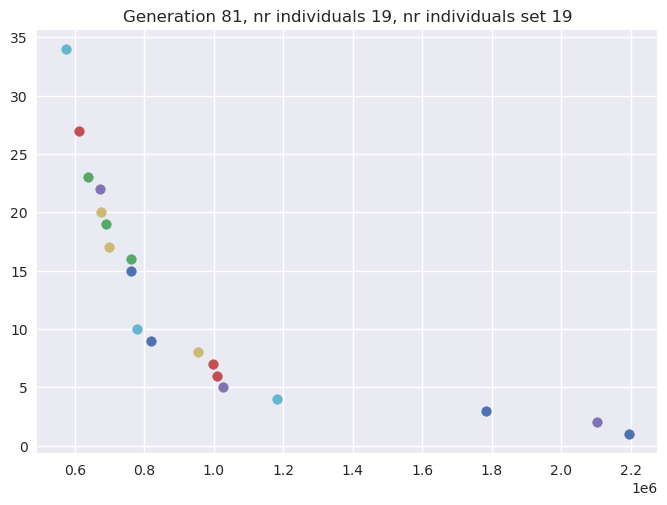

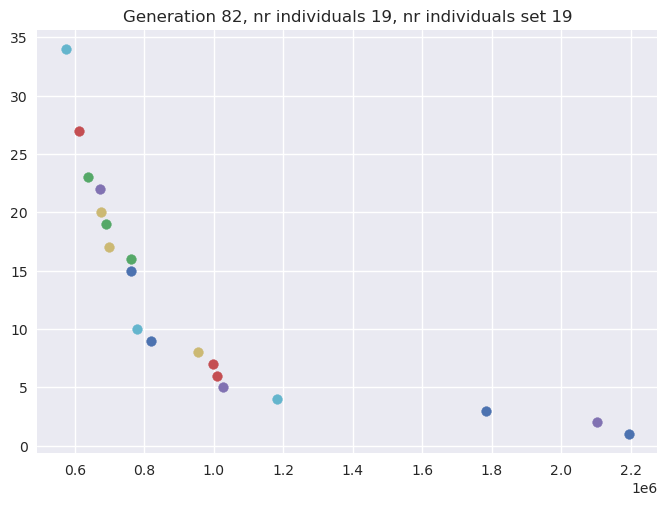

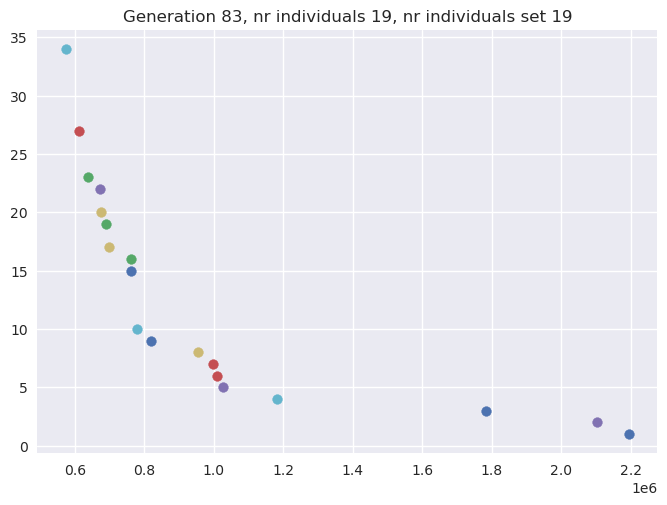

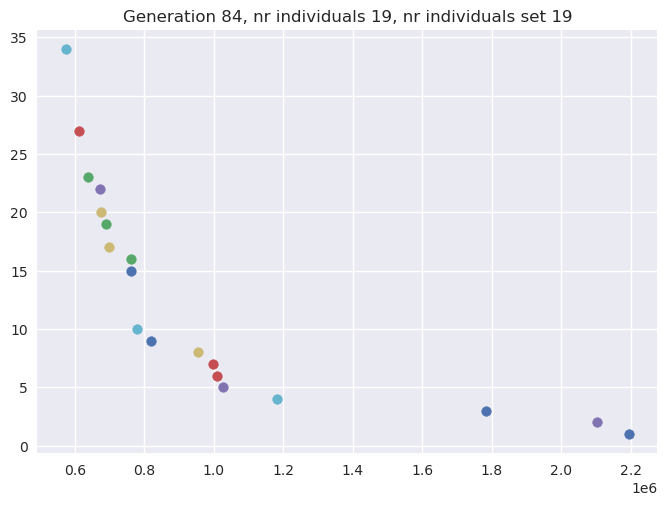

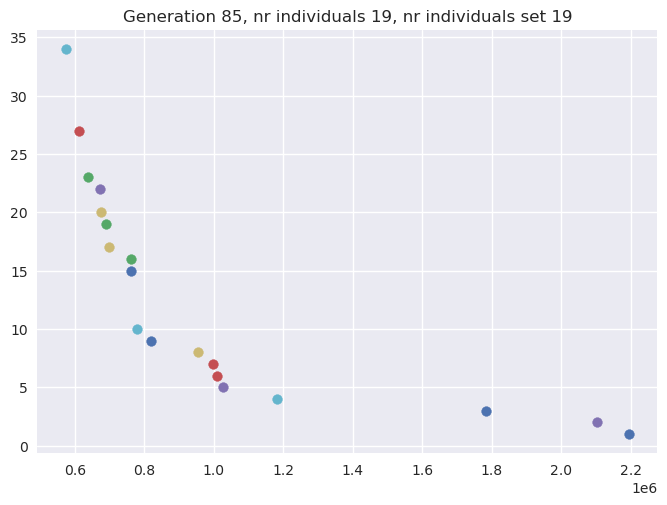

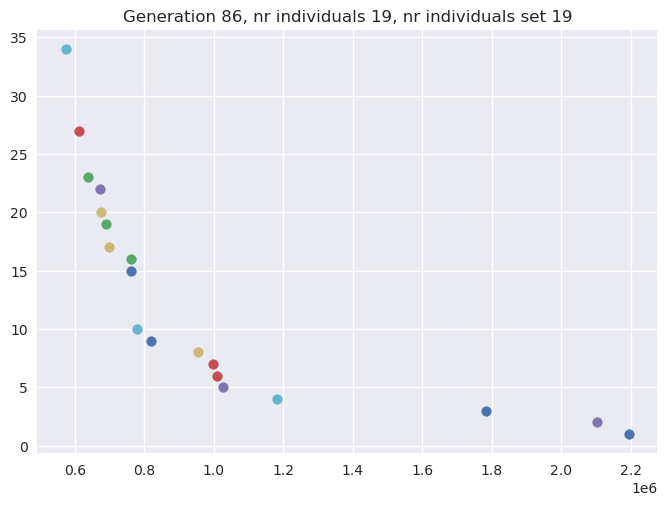

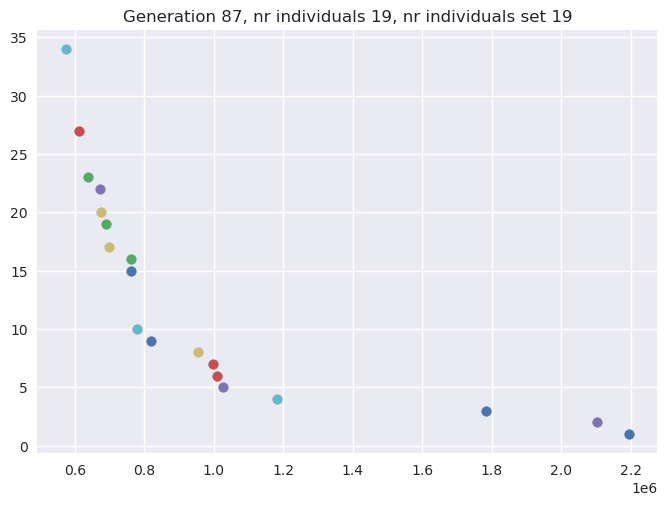

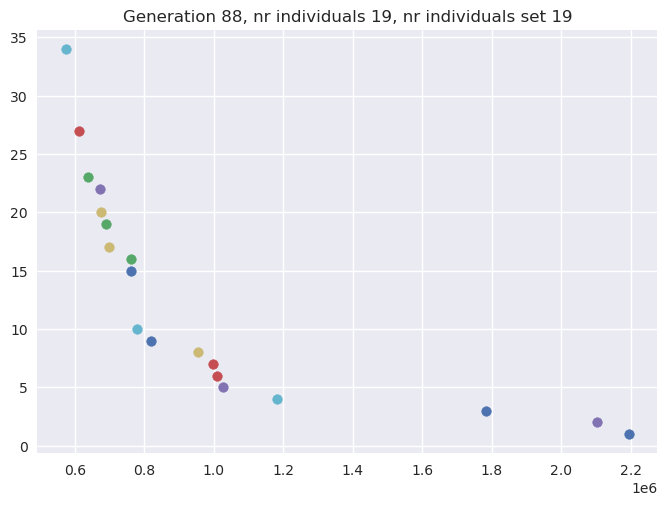

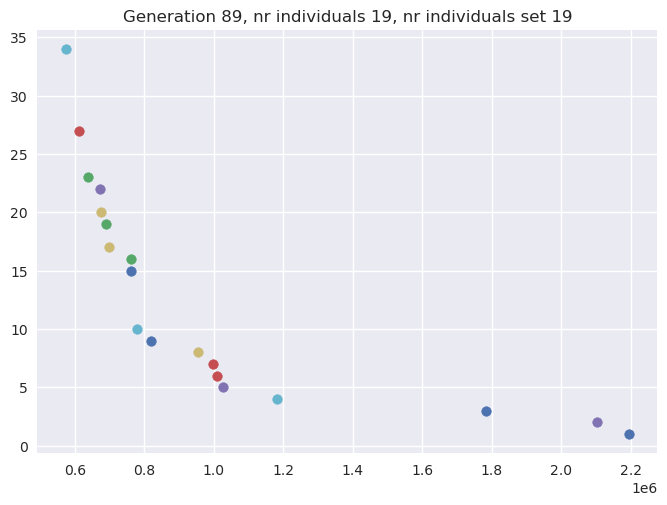

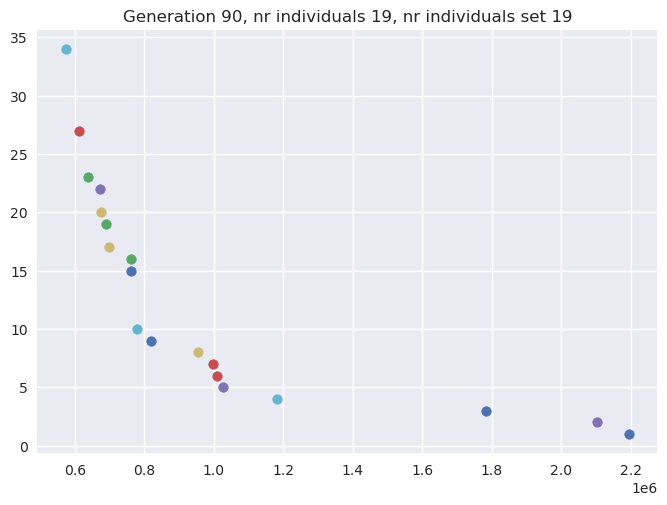

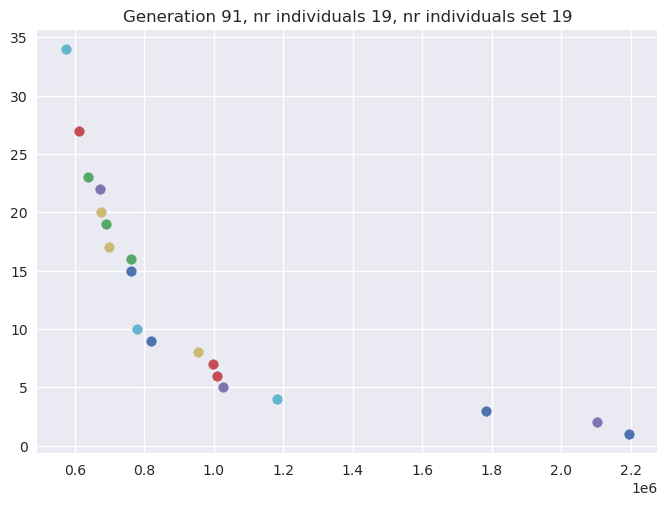

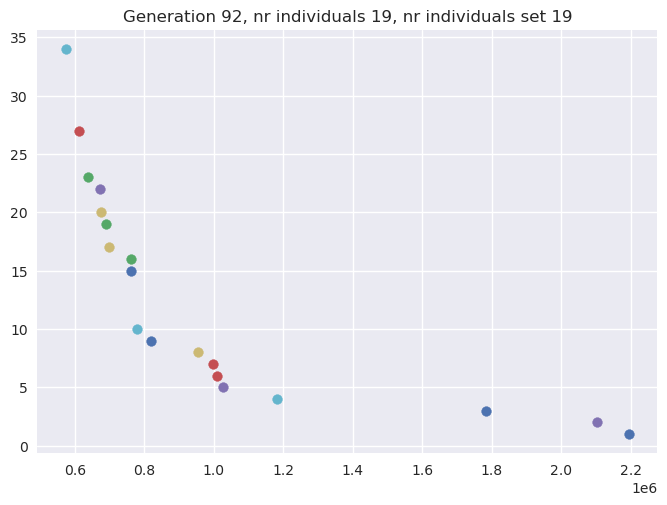

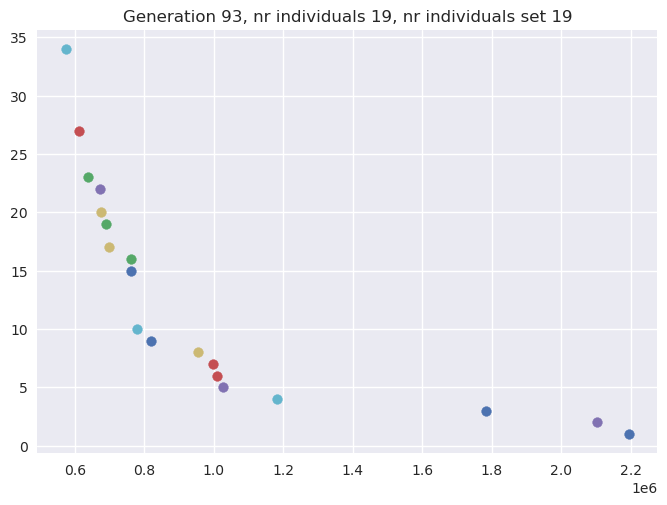

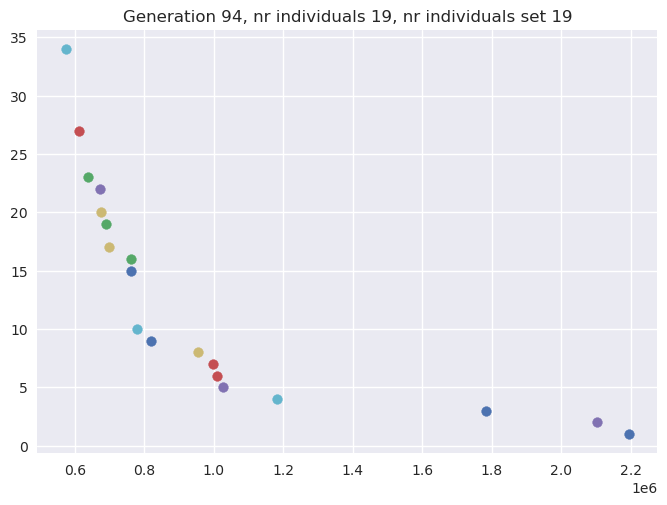

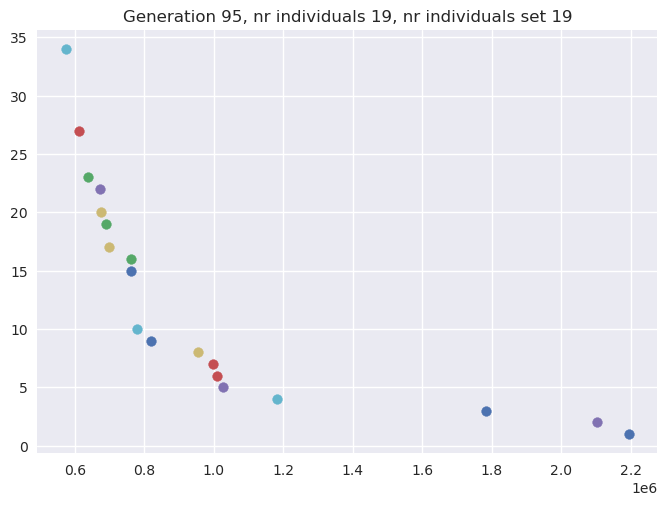

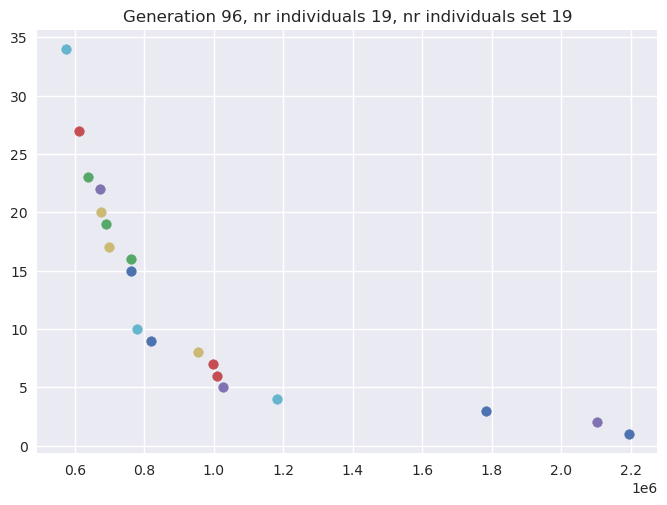

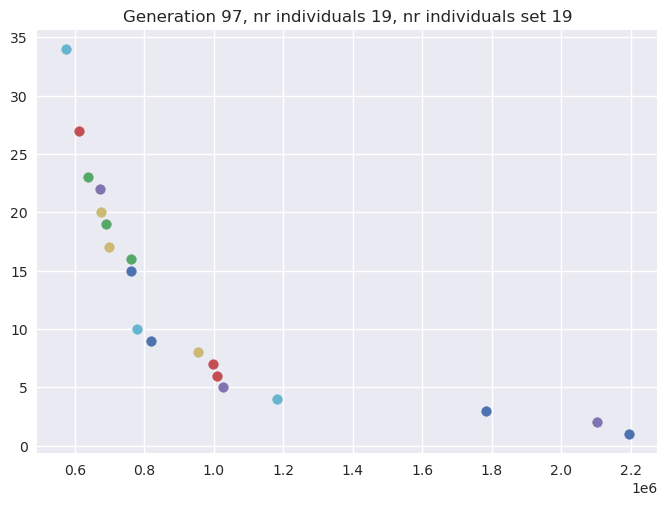

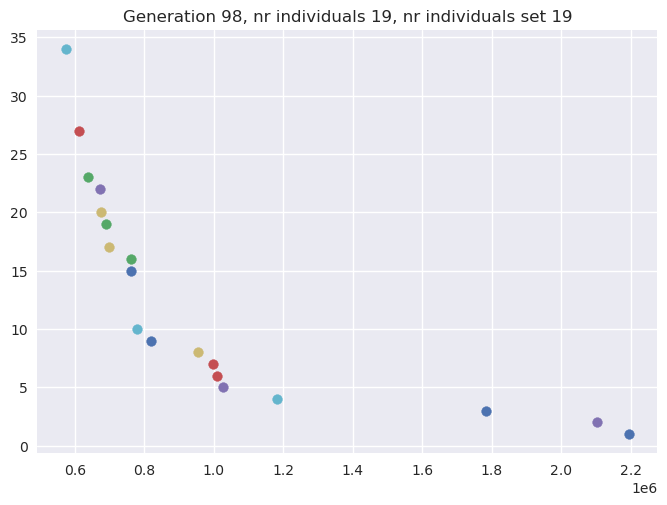

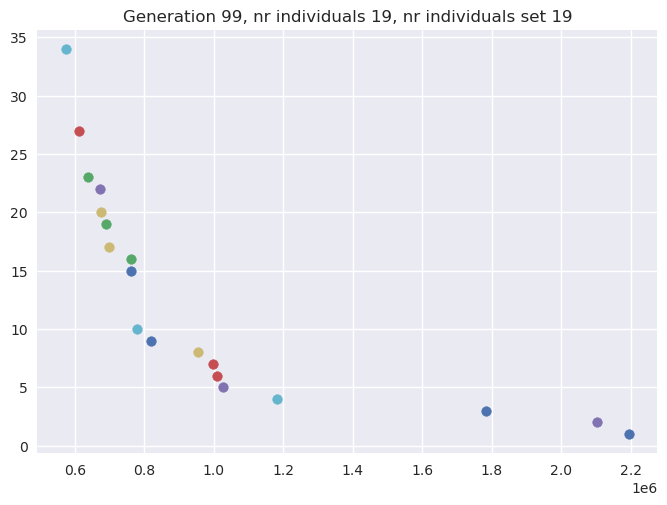

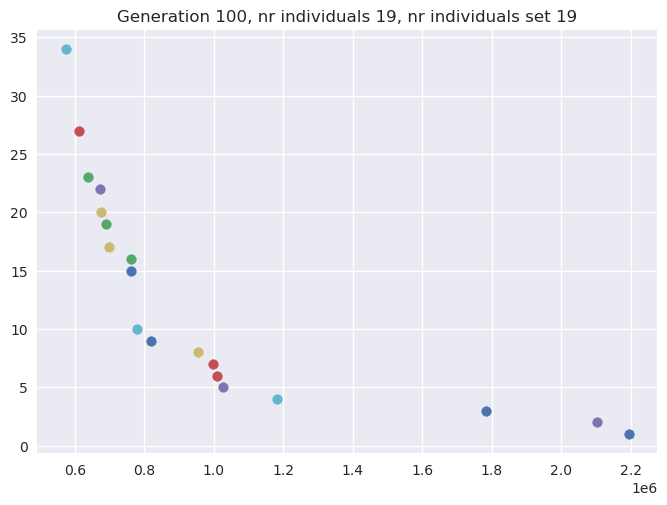

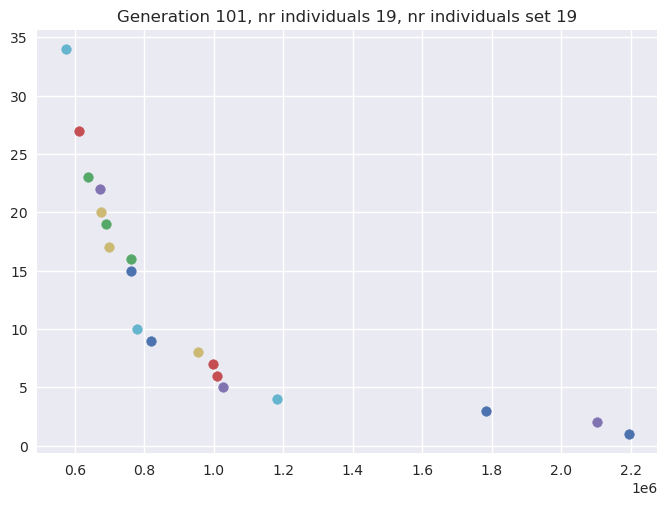

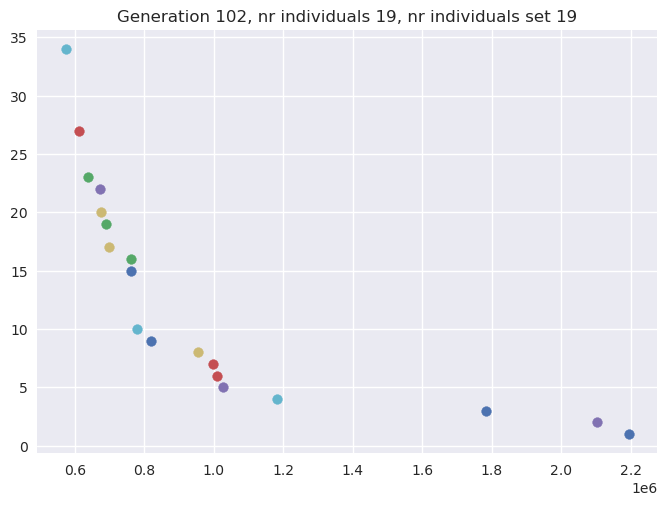

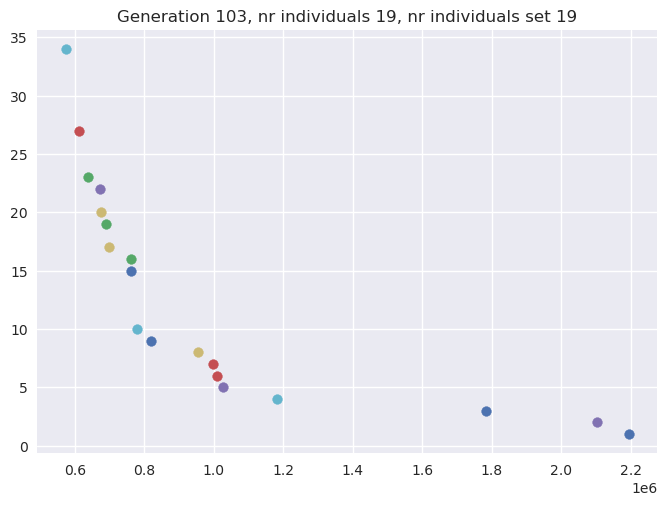

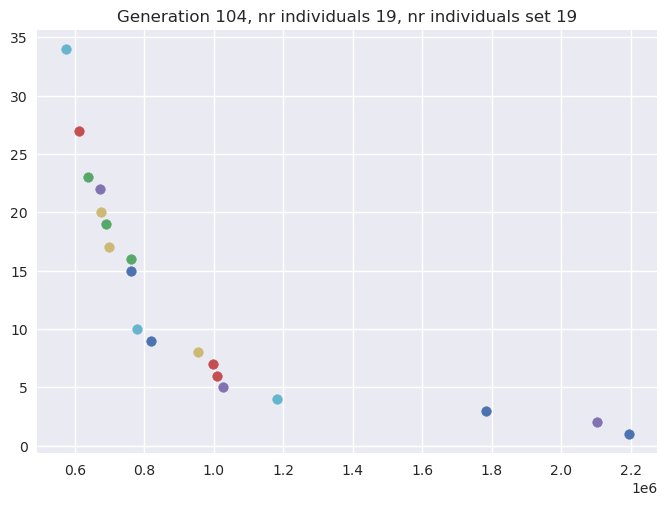

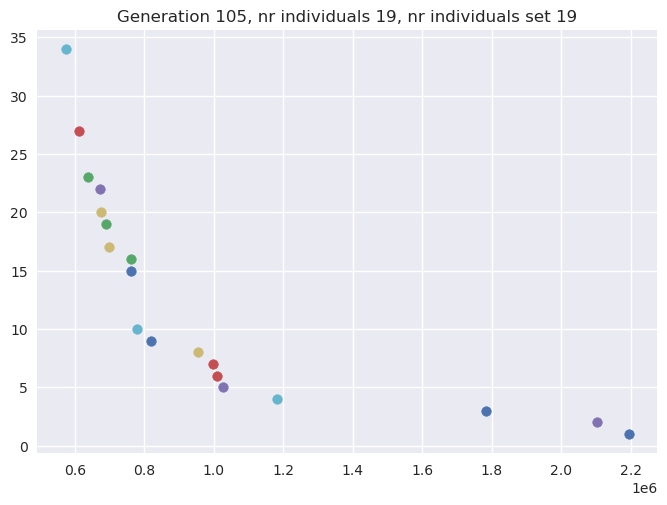

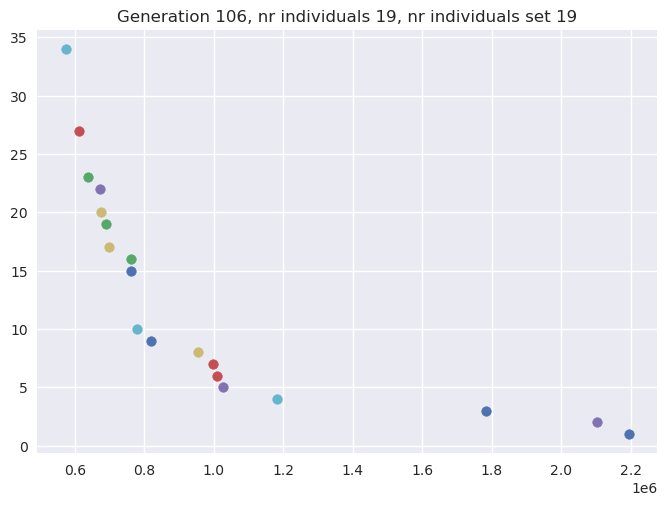

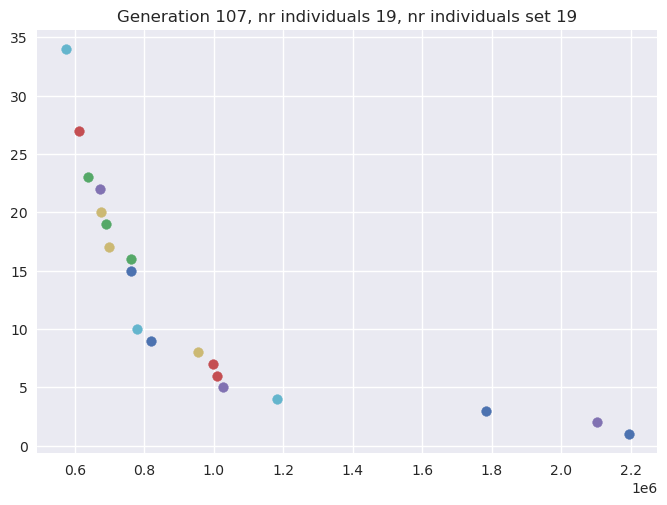

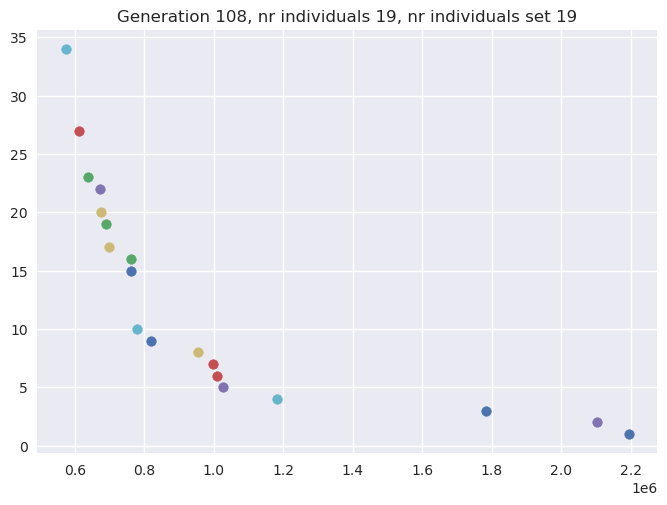

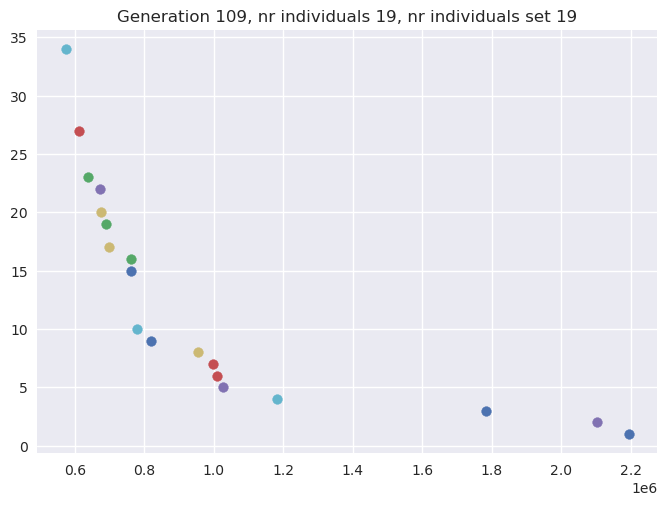

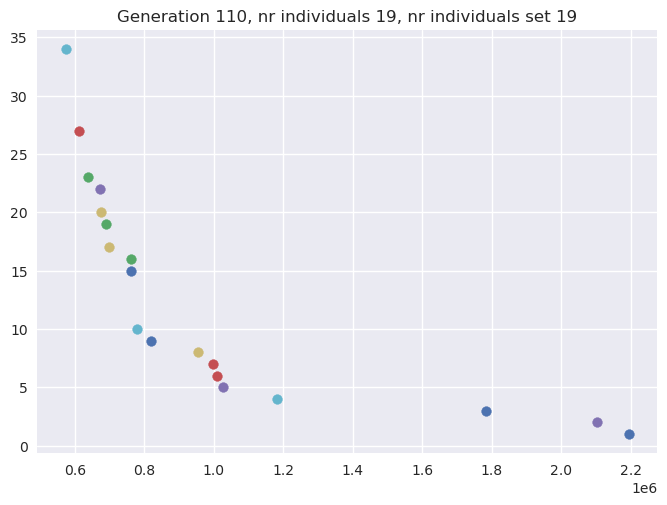

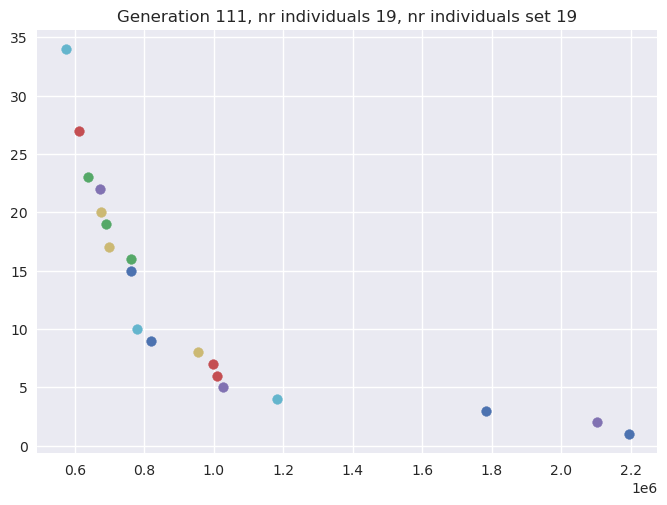

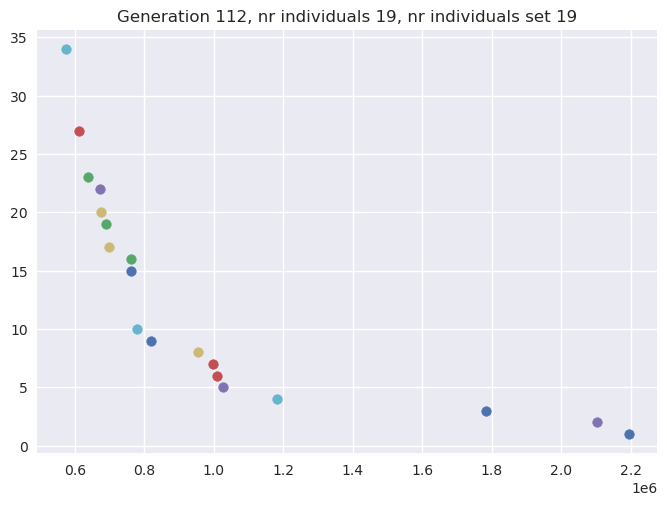

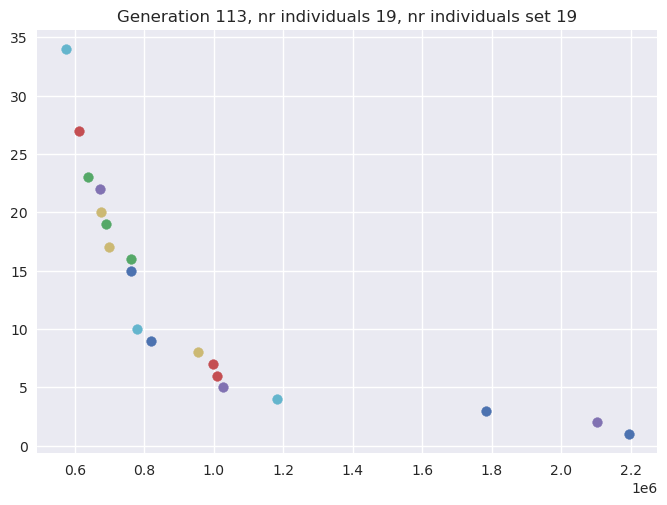

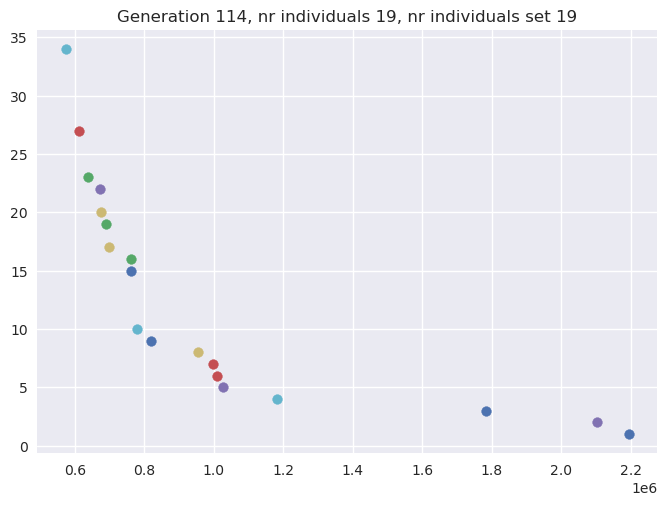

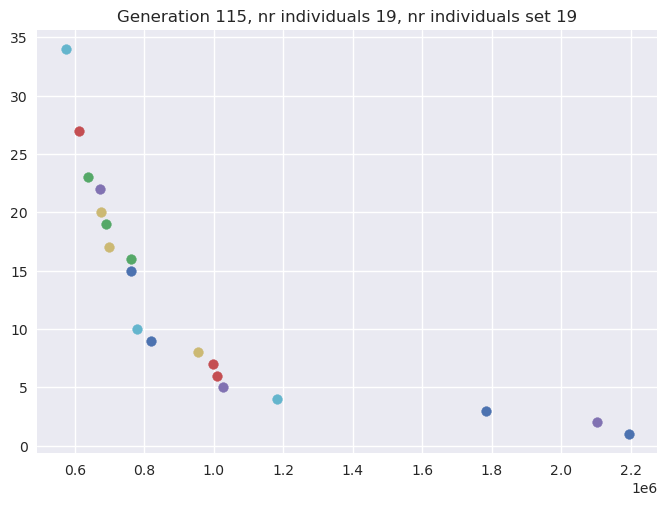

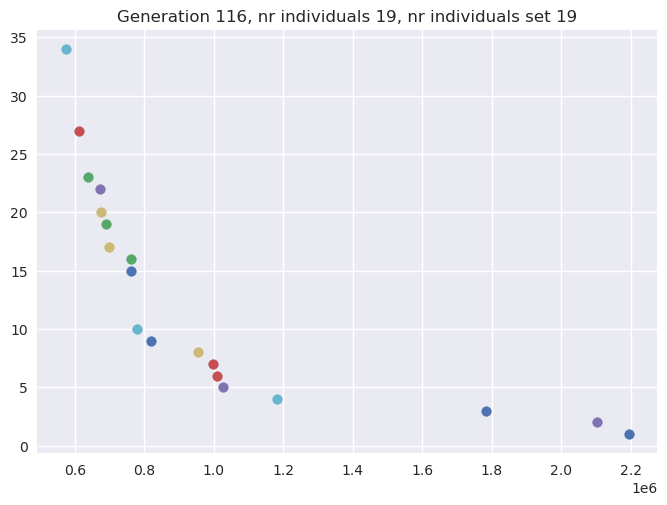

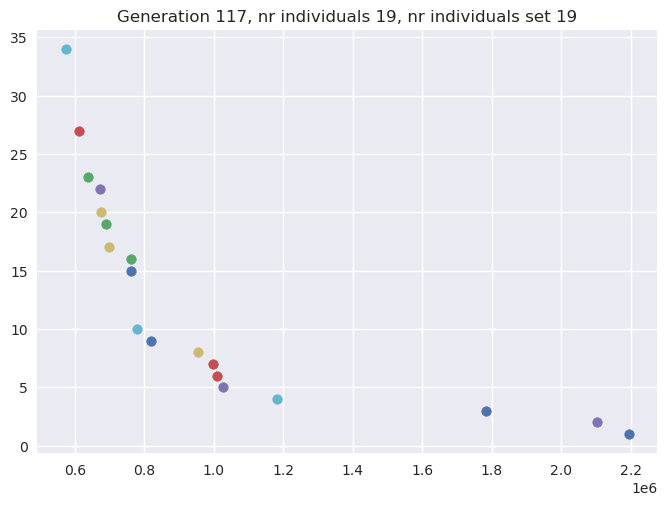

In [55]:
max_gen = None

filename = "results/prelim/2_MO_bike.csv"
df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)

    
MO_archive = df.iloc[-1,14].split("};")

for gen, MO_archive_gen in enumerate(MO_archive):
    MO_archive_gen = MO_archive_gen.replace("{","")
    individuals = MO_archive_gen.split("],")
    
    plt.figure()
   
    
    scatter_list = []
    
    for individual in individuals:
        
        
        
        individual = individual.replace("[","")
        individual = individual.replace("]","")
        
    
        
        individual = individual.split(",")
        
        train_fitness = float(individual[0])
        if "discounted" in filename:
            size = float(individual[3])
        else:
            size = float(individual[2])
        
        scatter_list.append((train_fitness,size))
   
        
    scatter_list = list(set(list(scatter_list)))
    
    
    plt.title("Generation {}, nr individuals {}, nr individuals set {}".format(gen, len(individuals), len(scatter_list)))
    
    for train_fitness, size in scatter_list:
        
        plt.scatter(train_fitness, size)

    plt.show()
    plt.close()

    
    

In [3]:
max_expr_size = None
max_gen = None
max_size = 10
max_complexity = 1

dataset_filename_fronts = defaultdict(lambda: defaultdict(list))

translation_dict = {
"MO": "MO",
"MO_discounted": "MO discounted",
"SO":"SO",
"MO_nocluster": "MO without clustering",
"SO_equalclustersize": "SO with 5x popsize",
"SO_equalclustersize_sample": "SO with 5x popsize + duplicate resampling",
"SO_equalclustersize_sample_full": "SO with 5x popsize + duplicate resampling + full init",
"SO_equalclustersize_sample_full_2objs": "SO with 5x popsize + duplicate resampling + full init + max abs obj",
"MO_equalclustersize": "MO with 5x popsize",
"MO_balanced": "MO with balanced clustering",
"MO_k2": "MO with k-2 balanced clustering",
"MO_frac1": "MO with donor fraction 1.",
"MO_equalclustersize_balanced": "MO with 5x popsize + balanced clustering",
"MO_equalclustersize_k2": "MO with 5x popsize + k-2 balanced clustering",   
"MO_equalclustersize_frac1": "MO with 5x popsize + donor fraction 1.",
"MO_equalclustersize_k2_frac1": "MO with 5x popsize + k-2 balanced clustering + donor fraction 1.",
"MO_equalclustersize_balanced_frac1": "MO with 5x popsize + balanced clustering + donor fraction 1.",
"MO_k2_frac1": "MO with k-2 balanced clustering + donor fraction 1.",
"MO_balanced_frac1": "MO with balanced clustering + donor fraction 1.",
"MO_equalclustersize_k2_frac1_sample": "MO with k-2 balanced clustering + donor fraction 1. + duplicate sampling" ,
"MO_equalclustersize_k2_frac1_sample_full": "MO with k-2 balanced clustering + donor fraction 1. + duplicate sampling + full init" ,
"MO_equalclustersize_k2_frac1_sample_full_2objs":"MO with k-2 balanced clustering + donor fraction 1. + duplicate sampling + full init + max abs obj" ,
}

In [56]:
def statistics(hv_list, dataset, appendix):
    print("#"*20, dataset, appendix, "#"*20)

    for k in hv_list.keys():
        print(k, np.mean(hv_list[k]))



def make_plot(dataset_filename, datasets, algorithms, title, axes, axes_labels = [r'$R^2$', 'Size']):
    markers = ['o', 'x', '^','s']
    for dataset in datasets:

        # Create a new figure for 3D plotting
        plt.figure()

        for algorithm in algorithms:

            # Sample data
            x = dataset_filename[dataset][algorithm][axes[0]]
            y = dataset_filename[dataset][algorithm][axes[1]]
            
            

            plt.scatter(list(chain(*x)), list(chain(*y)), alpha=0.4, label=translation_dict[algorithm], marker=markers[algorithms.index(algorithm)])

        # Customize the plot (optional)
        plt.xlabel(axes_labels[0])
        plt.ylabel(axes_labels[1])
        plt.title(title + " - Dataset: " + str(dataset))
        plt.legend()

        # Show the plot
        plt.show()


def get_mses(d, folder, x_index, appendix):
    pass





In [5]:
def get_significantly_better_index(meds):
    df = ((sp.posthoc_wilcoxon(meds, p_adjust="Holm", zero_method="zsplit") < 0.05).astype(int).sum()==(len(meds)-1)).astype(int)
    new_df = df

    for index, row in df.items():

        if row>0:
            
            if (np.median(meds[index-1])>[np.median(meds[(index + i) % (len(meds))]) for i in range(len(meds)-1)]).all():
                new_df.iloc[index-1] = 1
            else:
                new_df.iloc[index-1] = 0

    best_index = np.argwhere(new_df.to_numpy()>0)
    
    if len(best_index)>0:
        
        return best_index[0][0]
    return None

def get_hv(x,y,z, min_x, max_x, min_y, max_y, min_z, max_z, third_objective=False):
    min_x = 0
    max_x = 1.
    
    
    try:
        x_array = (np.array(x)-min_x)/(max_x-min_x)
    except:
        print(x)
        print(np.array(x))
    x_array = 1.-np.maximum(x_array,0.)

    y_array = (np.array(y)-min_y)/(max_y-min_y)
    z_array = (np.array(z)-min_z)/(max_z-min_z)

    if third_objective:
        result = np.column_stack((x_array, z_array))
    else:
        result = np.column_stack((x_array, y_array))

    ref_point = np.array([1., 1.])
    
#     if third_objective:
#         result = np.column_stack((x_array, y_array, z_array))

#         ref_point = np.array([1., 1., 1.])

    ind = HV(ref_point=ref_point)

    return ind(result)

def get_hvs(x, y, z, min_x, max_x, min_y, max_y, min_z, max_z, third_objective=False):
    hvs = []
    for x_val, y_val, z_val in zip(x,y,z):
        hvs.append(get_hv(x_val, y_val, z_val, min_x, max_x, min_y, max_y, min_z, max_z, third_objective))
    return hvs

def collapse_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [40]:
datasets = ["dowchemical","tower", "air", "concrete", "bike", "synthetic_1", "synthetic_2", "synthetic_3", "synthetic_4", "synthetic_5"]

def get_dict(experiments, min_x=None, max_x = None, min_y=None, max_y = None, min_z=None, max_z = None, max_gen = None):    
    
    if min_x is None:
        min_x = 999999999.
    if max_x is None:
        max_x = 0.
        
    if min_y is None:
        min_y = 999999999.
    if max_y is None:
        max_y = 0.
    
    if min_z is None:
        min_z = 999999999.
    if max_z is None:
        max_z = 0.
    

    dataset_filename = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    for dataset in datasets:
        print(dataset)
        folder = "prelim"
        dir = "./results/" + folder
        for filename in tqdm(sorted(glob.glob(dir + "/*.csv"))):
            # Repetition number
            nr = int(filename.split("/")[-1].split("_")[0])
            # Dictionary key, e.g. SO_512
            d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]

            # Skip if not part of experiments
            if d_key not in experiments:
                continue

            if(dataset in filename):

                df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)

                scatter_x = []
                scatter_y = []
                scatter_discount = []
                scatter_z = []
                
                
                
                # Use all generations if max_gen is Non and otherwise the last gen or max_gen
                mg = -1
                if max_gen is not None and len(df.iloc[-1][14].split(";")) >= max_gen:
                    mg = max_gen - 1
                
                # Loop over all individuals on last front
                for el in df.iloc[-1][14].split(";")[mg].split("],"):
                    rep = el.replace("[","").replace("{","").split(",")

                    if not np.isinf(float(rep[0])) and not np.isinf(float(rep[2])) and not np.isinf(float(rep[4])):

                        scatter_x.append(max(1. - (float(rep[0])/float(df.iloc[-1][7])),0))
                        scatter_y.append(float(rep[2]))
                        scatter_z.append(float(rep[4]))
                        scatter_discount.append(float(rep[3]))
                        
                        if (1.-float(rep[0])/float(df.iloc[-1][7]))>max_x:
                            max_x = (1.-float(rep[0])/float(df.iloc[-1][7]))
                        
                        if (1.-float(rep[0])/float(df.iloc[-1][7]))<min_x:
                            min_x = max((1.-float(rep[0])/float(df.iloc[-1][7])),0)

                        if float(rep[2])>max_y:
                            max_y = float(rep[2])
                        if float(rep[2])<min_y:
                            min_y = float(rep[2])
                            
                        # If discounted is smaller then take this as a reference
                        if float(rep[3])<min_y:
                            min_y = float(rep[3])
                        
                        if float(rep[4])>max_z:
                            max_z = float(rep[4])
                        if float(rep[4])<min_z:
                            min_z = float(rep[4])

                dataset_filename[dataset][d_key]["x"].append(scatter_x)
                dataset_filename[dataset][d_key]["y"].append(scatter_y)
                dataset_filename[dataset][d_key]["z"].append(scatter_z)
                dataset_filename[dataset][d_key]["discount"].append(scatter_discount)
                
                dataset_filename[dataset][d_key]["gens"].append(len(df.iloc[-1][16].split(",")[:mg]))

    for dataset in datasets:
        for k in dataset_filename[dataset].keys():

            dataset_filename[dataset][k]["hvs"] = get_hvs(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"], min_x, max_x, min_y, max_y, min_z, max_z, third_objective=False)
            dataset_filename[dataset][k]["avg_hv"] = np.mean(dataset_filename[dataset][k]["hvs"])

            dataset_filename[dataset][k]["hvs_3d"] = get_hvs(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"], min_x, max_x, min_y, max_y, min_z, max_z, third_objective=True)
            dataset_filename[dataset][k]["avg_hv_3d"] = np.mean(dataset_filename[dataset][k]["hvs_3d"])
            

            dataset_filename[dataset][k]["hvs_discount"] = get_hvs(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["discount"], dataset_filename[dataset][k]["z"], min_x, max_x, min_y, max_y, min_z, max_z, third_objective=False)
            dataset_filename[dataset][k]["avg_hv_discount"] = np.mean(dataset_filename[dataset][k]["hvs_discount"])


    missing = 0
    for dataset in datasets:
        meds = []

        for algorithm in experiments:
            # Only print if at least one but less than 10 repetitions
            if(len(dataset_filename[dataset][algorithm]["gens"]))<10 and (len(dataset_filename[dataset][algorithm]["gens"]))>0:
                missing += 10-len(dataset_filename[dataset][algorithm]["gens"])
                print(dataset, algorithm, len(dataset_filename[dataset][algorithm]["gens"]), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
            meds.append(dataset_filename[dataset][algorithm]["hvs"])
     # Find the length of the shortest list
        min_length = min(len(lst) for lst in meds)

        # Truncate each list to the shortest length
        meds = [lst[:min_length] for lst in meds]
        try:
            print(algorithms[get_significantly_better_index(meds)])
        except:
            pass

    print(min_x)
    print(max_x)
    print(min_y)
    print(max_y)
    print(min_z)
    print(max_z)
    
    return dataset_filename, min_x, max_x, min_y, max_y, min_z, max_z



experiments = [
    "MO",
    "MO_discounted",
    "SO",
    "MO_nocluster",
    "SO_equalclustersize",
    "SO_equalclustersize_sample",
    "SO_equalclustersize_sample_full",
    "MO_equalclustersize",
    "MO_balanced",
    "MO_k2",
    "MO_frac1",
    "MO_equalclustersize_balanced",
    "MO_equalclustersize_k2",
    "MO_equalclustersize_frac1",
    "MO_equalclustersize_k2_frac1",
    "MO_equalclustersize_balanced_frac1",
    "MO_k2_frac1",
    "MO_balanced_frac1",
    "MO_equalclustersize_k2_frac1_sample",
    "MO_equalclustersize_k2_frac1_sample_full",
    
]

dataset_filename, min_x, max_x, min_y, max_y, _, _ = get_dict(experiments)
dataset_filename_50, _, _, _, _, _, _ = get_dict(experiments, min_x, max_x, min_y, max_y, min_z, max_z, 50)


experiments_2objs = [
    "SO_equalclustersize_sample_full_2objs",
    "MO_equalclustersize_k2_frac1_sample_full_2objs"

]

dataset_filename_2objs, _, _, _, _, _, _ = get_dict(experiments_2objs, min_x, max_x, None, None, None, None)
# dataset_filename_2objs_50, _, _ = get_dict(experiments_2objs, min_x, max_x, 50)
# dataset_filename_2objs_100, _, _ = get_dict(experiments_2objs, min_x, max_x, 100)
# dataset_filename_2objs_300, _, _ = get_dict(experiments_2objs, min_x, max_x, 300)

dowchemical


  0%|          | 0/1150 [00:00<?, ?it/s]

tower


  0%|          | 0/1150 [00:00<?, ?it/s]

air


  0%|          | 0/1150 [00:00<?, ?it/s]

concrete


  0%|          | 0/1150 [00:00<?, ?it/s]

bike


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_1


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_2


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_3


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_4


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_5


  0%|          | 0/1150 [00:00<?, ?it/s]

0
1.0
1.0
491.0
1.0
491.0
dowchemical


  0%|          | 0/1150 [00:00<?, ?it/s]

tower


  0%|          | 0/1150 [00:00<?, ?it/s]

air


  0%|          | 0/1150 [00:00<?, ?it/s]

concrete


  0%|          | 0/1150 [00:00<?, ?it/s]

bike


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_1


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_2


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_3


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_4


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_5


  0%|          | 0/1150 [00:00<?, ?it/s]

0
1.0
1.0
491.0
1.0
491.0
dowchemical


  0%|          | 0/1150 [00:00<?, ?it/s]

tower


  0%|          | 0/1150 [00:00<?, ?it/s]

air


  0%|          | 0/1150 [00:00<?, ?it/s]

concrete


  0%|          | 0/1150 [00:00<?, ?it/s]

bike


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_1


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_2


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_3


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_4


  0%|          | 0/1150 [00:00<?, ?it/s]

synthetic_5


  0%|          | 0/1150 [00:00<?, ?it/s]

SO_equalclustersize_sample_full_2objs
0
1.0
1.0
267.0
0.000583
2970.435547


In [13]:
def make_latex_table(algos, datasets, dataset_filename, suffix=""):
    stri = r'\begin{table}[]' + "\n"
    stri += r'\begin{tabular}{' + "l"*(1+len(algos)) + '}' + "\n"
    stri += "Dataset      & "
    for algo in algos:
        stri += translation_dict[algo].ljust(17) + " & "
    stri = stri[:-2]
    stri += r'\\' 
    stri += "\n"
    
    for dataset in datasets:
        stri += dataset.capitalize().ljust(12) + " & "
        for algo in algos:
            try:
                for x in ["{0:.3f} $\\pm$ {1:.3f}".format(dataset_filename[dataset][algo]["avg_hv" + suffix], np.std(dataset_filename[dataset][algo]["hvs" + suffix])).ljust(12)]:
                    stri += x + " & "
            except:
                pass
        stri = stri[:-2]
        stri += r'\\' + "\n"
                
    stri += r'\end{tabular}' + "\n"
    stri += r'\end{table}'
    print()
    print(stri)

# Why clustering is needed

DOWCHEMICAL
----------------------------------------------------------
MO                   0.7144846121059524 120.2
MO_nocluster         0.6384376681204346 164.2
Significantly better: MO
TOWER
----------------------------------------------------------
MO                   0.8572676857756086 205.3
MO_nocluster         0.7810344313591602 156.5
Significantly better: MO
AIR
----------------------------------------------------------
MO                   0.7011775293525375 115.2
MO_nocluster         0.6642059060571917 157.5
Significantly better: MO
CONCRETE
----------------------------------------------------------
MO                   0.7948667587728491 120.1
MO_nocluster         0.7379975943135465 111.1
Significantly better: MO
BIKE
----------------------------------------------------------
MO                   0.8299872209722983 112.9
MO_nocluster         0.8030442349931162 110.3
Significantly better: MO

\begin{table}[]
\begin{tabular}{lll}
Dataset      & MO                & MO without 

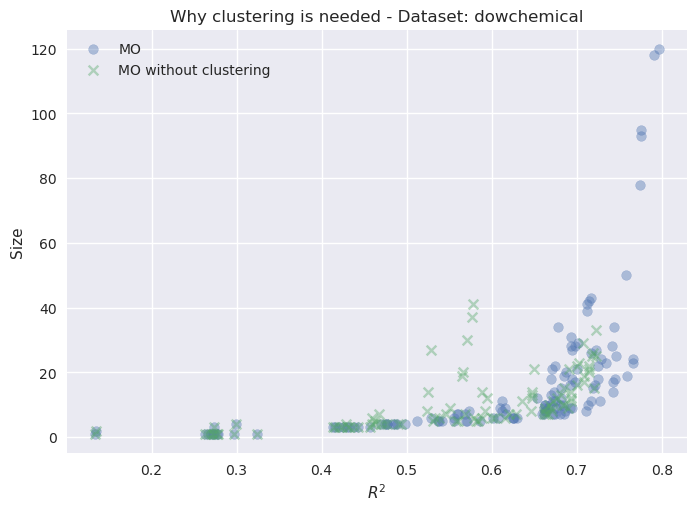

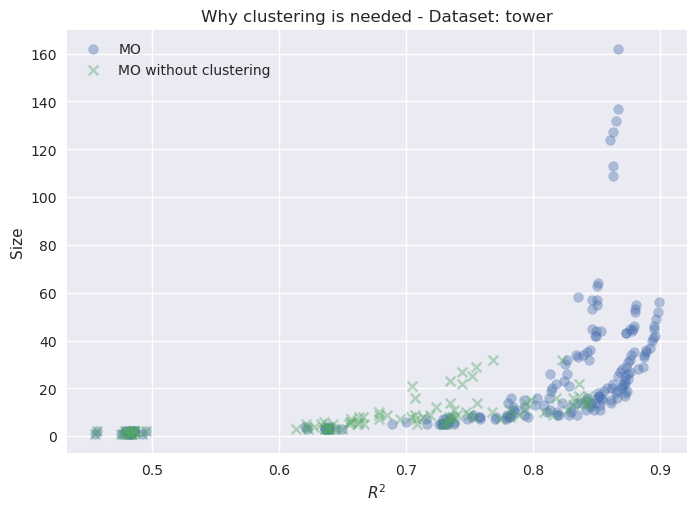

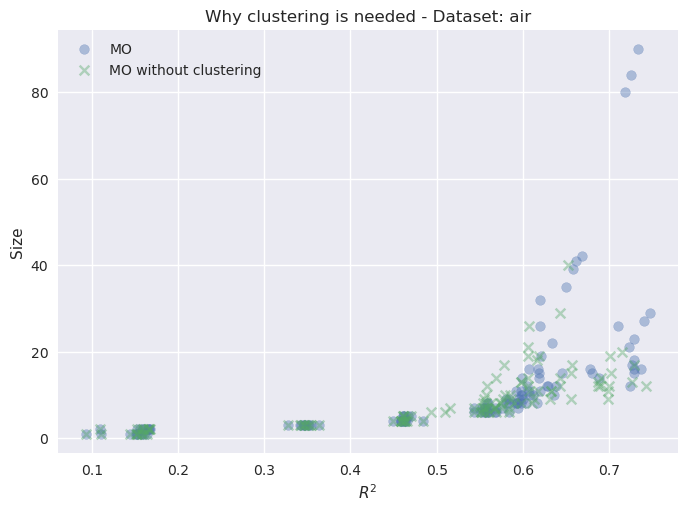

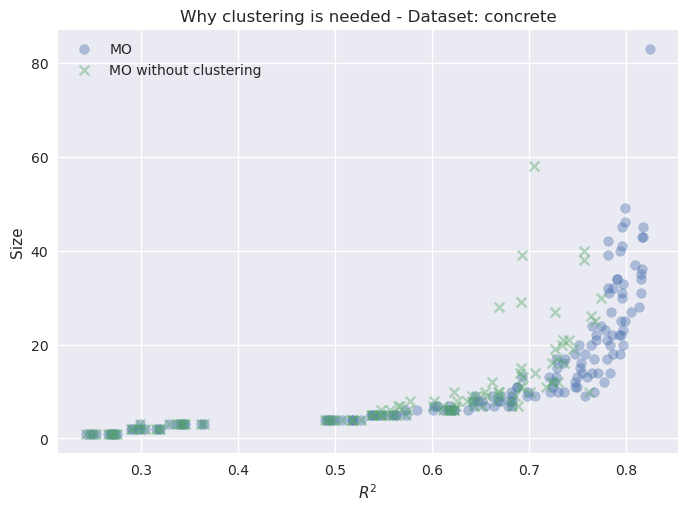

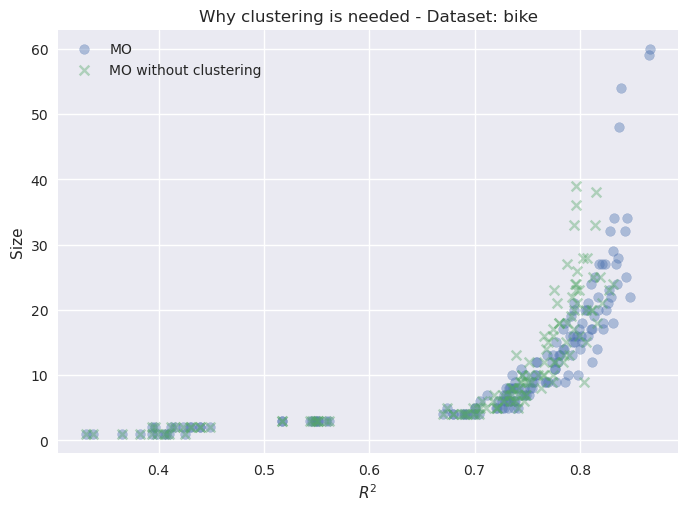

In [57]:
algorithms = ["MO", "MO_nocluster"]
datasets = ["dowchemical","tower", "air", "concrete", "bike"]
for dataset in datasets:
    print(dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(20), dataset_filename[dataset][algorithm]["avg_hv"], np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)
    
    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]

    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass


make_latex_table(algorithms, datasets, dataset_filename)
make_plot(dataset_filename, datasets, algorithms, "Why clustering is needed", ["x","y"], axes_labels = [r'$R^2$', 'Size'])

# The problem

DATASET: DOWCHEMICAL
----------------------------------------------------------
MO                                  0.714 120.2
SO                                  0.846 172.4
Significantly better: SO
DATASET: TOWER
----------------------------------------------------------
MO                                  0.857 205.3
SO                                  0.897 160.0
Significantly better: SO
DATASET: AIR
----------------------------------------------------------
MO                                  0.701 115.2
SO                                  0.815 215.0
Significantly better: SO
DATASET: CONCRETE
----------------------------------------------------------
MO                                  0.795 120.1
SO                                  0.851 185.1
Significantly better: SO
DATASET: BIKE
----------------------------------------------------------
MO                                  0.83 112.9
SO                                  0.891 199.8
Significantly better: SO

\begin{table}[]
\be

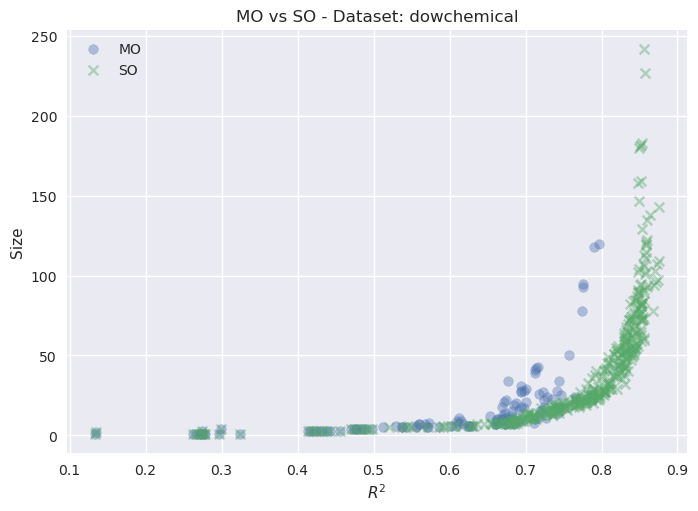

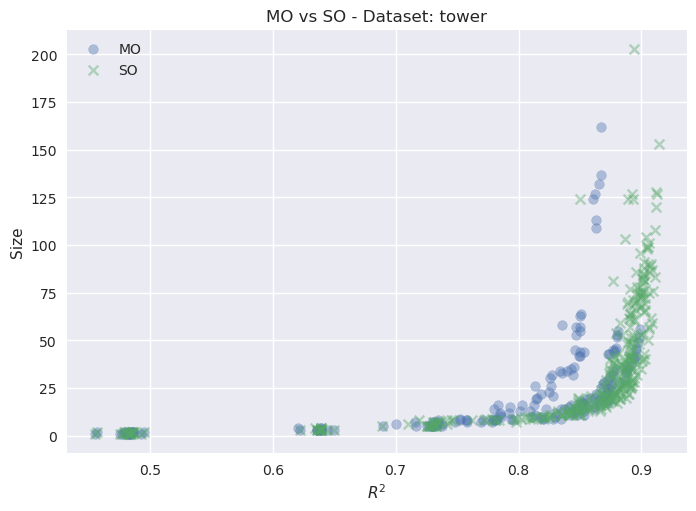

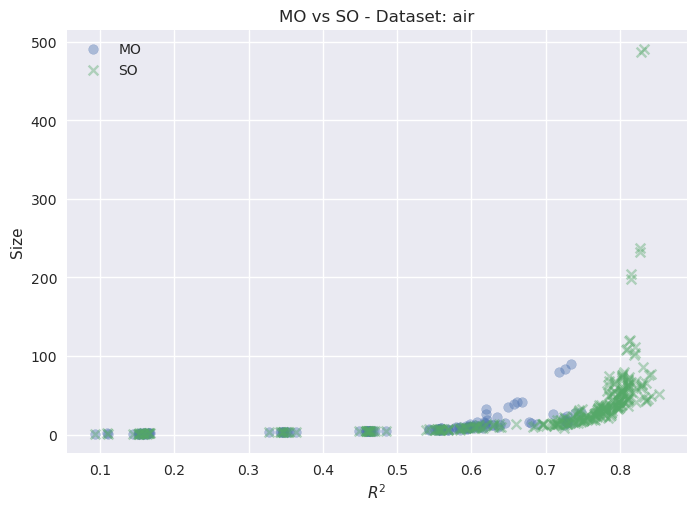

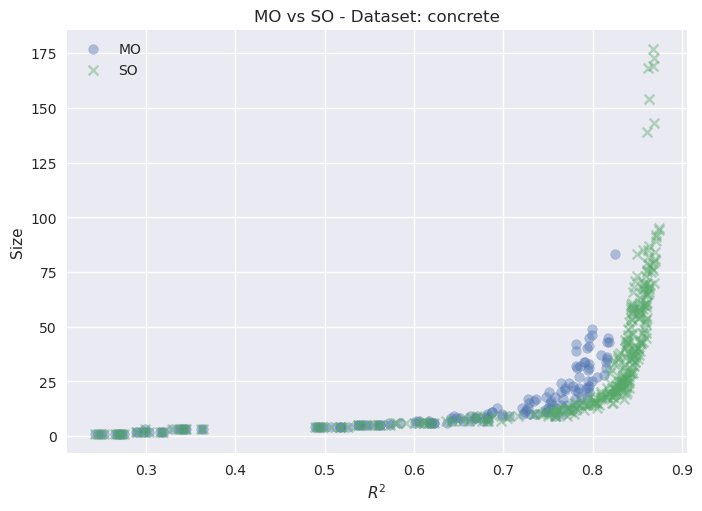

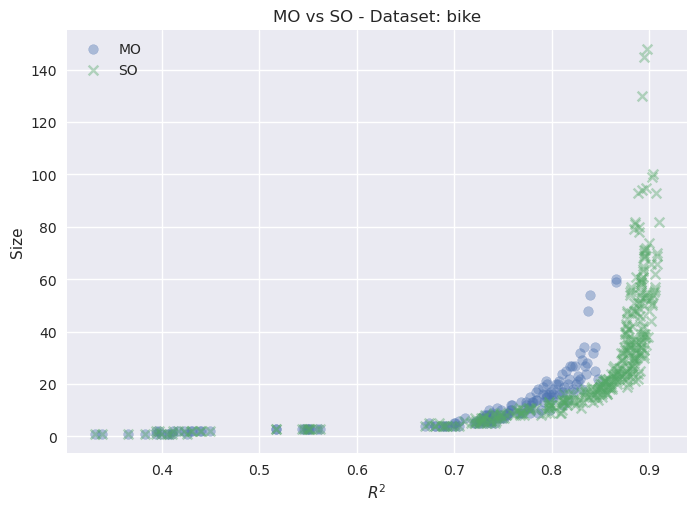

In [61]:
algorithms = ["MO", "SO"]
datasets = ["dowchemical","tower", "air", "concrete", "bike"]
for dataset in datasets:
    try:
        print("DATASET:", dataset.upper())
        print("-"*58)
        meds = []

        for algorithm in algorithms:
            print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
            meds.append(dataset_filename[dataset][algorithm]["hvs"])
     # Find the length of the shortest list
        min_length = min(len(lst) for lst in meds)

        # Truncate each list to the shortest length
        meds = [lst[:min_length] for lst in meds]
        try:
            print("Significantly better:", algorithms[get_significantly_better_index(meds)])
        except:
            pass
    except:
        pass
make_latex_table(algorithms, datasets, dataset_filename)
make_plot(dataset_filename, datasets, algorithms, "MO vs SO", ["x","y"], axes_labels = [r'$R^2$', 'Size'])

# The fix?

DATASET: DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_balanced_frac1  0.794 49.7
MO_equalclustersize_k2_frac1        0.823 48.9
SO                                  0.846 172.4
Significantly better: SO
DATASET: TOWER
----------------------------------------------------------
MO_equalclustersize_balanced_frac1  0.88 46.1
MO_equalclustersize_k2_frac1        0.887 47.0
SO                                  0.897 160.0
Significantly better: SO
DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_balanced_frac1  0.773 53.7
MO_equalclustersize_k2_frac1        0.795 59.5
SO                                  0.815 215.0
DATASET: CONCRETE
----------------------------------------------------------
MO_equalclustersize_balanced_frac1  0.833 49.3
MO_equalclustersize_k2_frac1        0.844 54.3
SO                                  0.851 185.1
DATASET: BIKE
----------------------------------------------------------
MO_equa

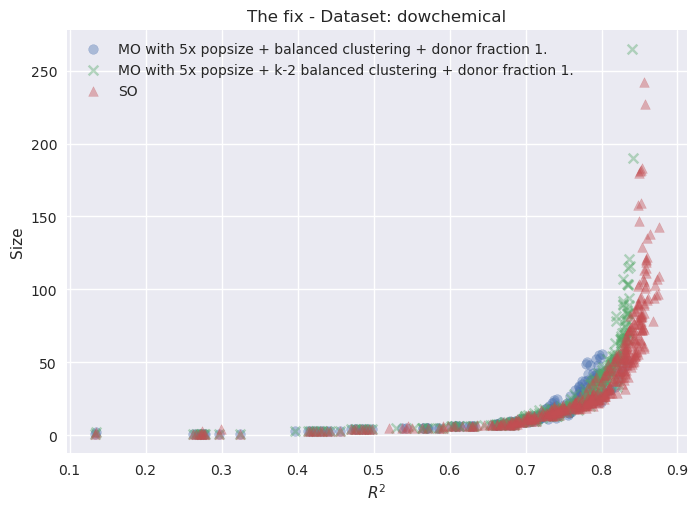

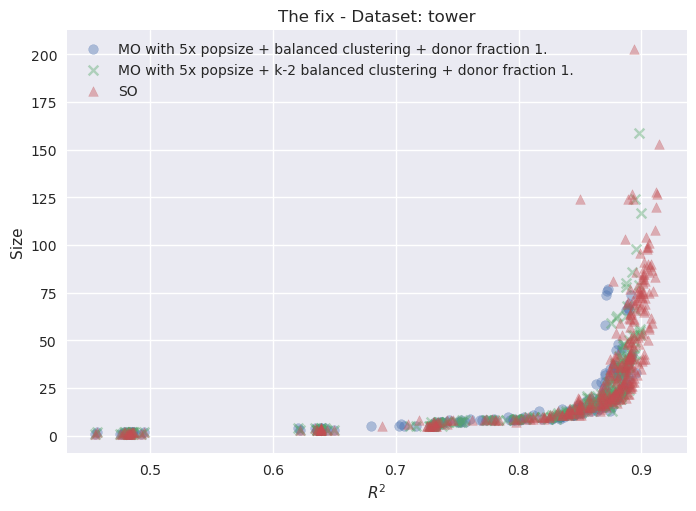

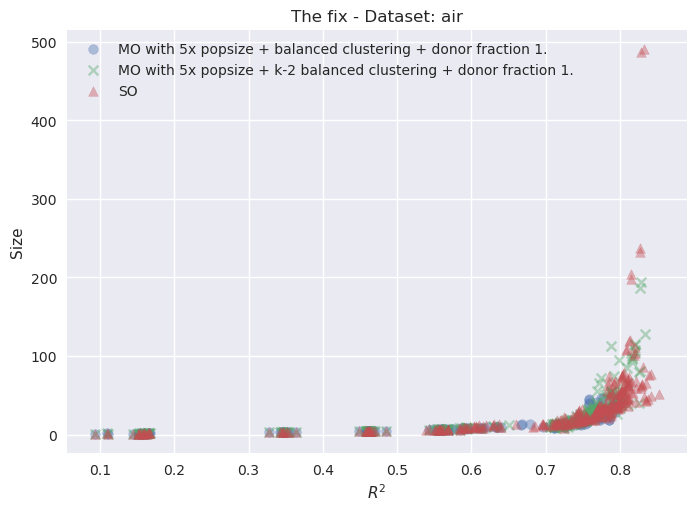

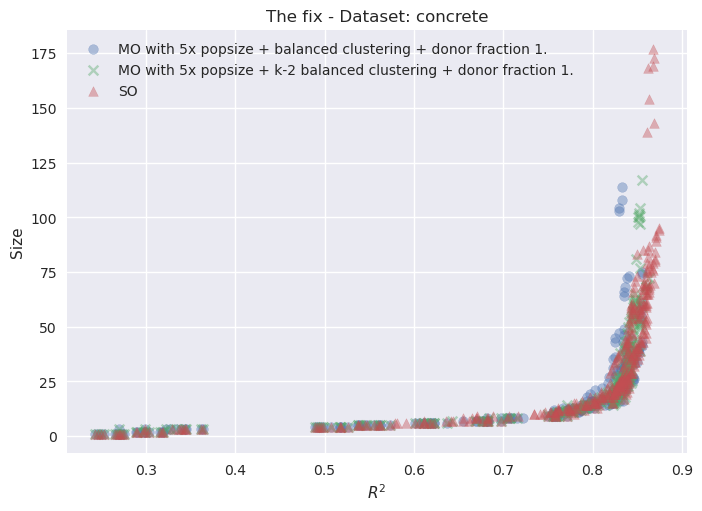

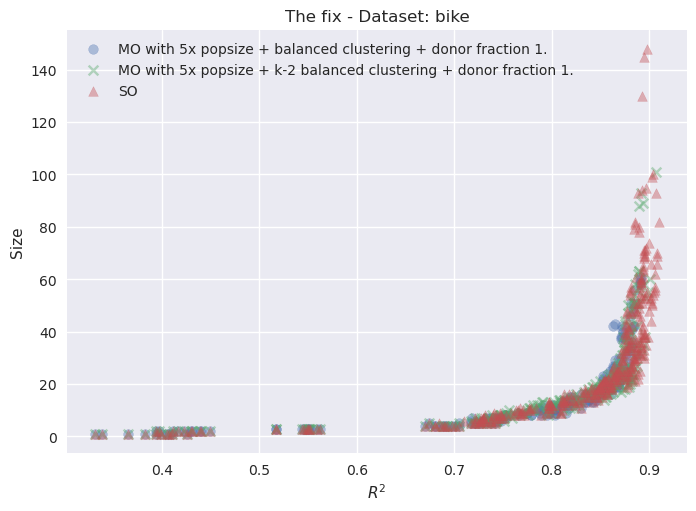

In [62]:
algorithms = ["MO_equalclustersize_balanced_frac1", "MO_equalclustersize_k2_frac1", "SO"]
datasets = ["dowchemical","tower", "air", "concrete", "bike"]
for dataset in datasets:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
#         print(algorithm.ljust(35), "{:.3}".format(dataset_filename_50[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename_50[dataset][algorithm]["gens"]))
#         meds.append(dataset_filename_50[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass
make_latex_table(algorithms, datasets, dataset_filename)
make_plot(dataset_filename, datasets, algorithms, "The fix", ["x","y"], axes_labels = [r'$R^2$', 'Size'])

# Ablations

DATASET: DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2_frac1        0.823 48.9
MO_equalclustersize_k2              0.82 48.3
DATASET: TOWER
----------------------------------------------------------
MO_equalclustersize_k2_frac1        0.887 47.0
MO_equalclustersize_k2              0.886 47.4
DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_k2_frac1        0.795 59.5
MO_equalclustersize_k2              0.803 59.3
DATASET: CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2_frac1        0.844 54.3
MO_equalclustersize_k2              0.843 53.9
DATASET: BIKE
----------------------------------------------------------
MO_equalclustersize_k2_frac1        0.882 58.6
MO_equalclustersize_k2              0.881 55.1

\begin{table}[]
\begin{tabular}{lll}
Dataset      & MO with 5x popsize + k-2 balanced clustering + donor fraction 1. & MO with 5x popsize + k-2 balanced c

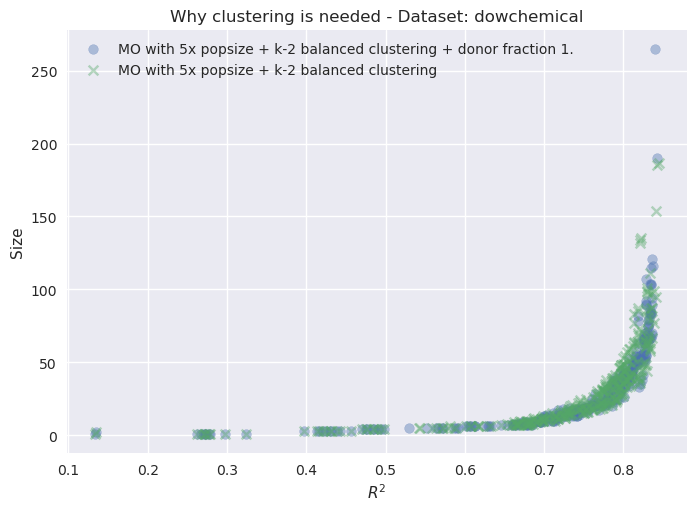

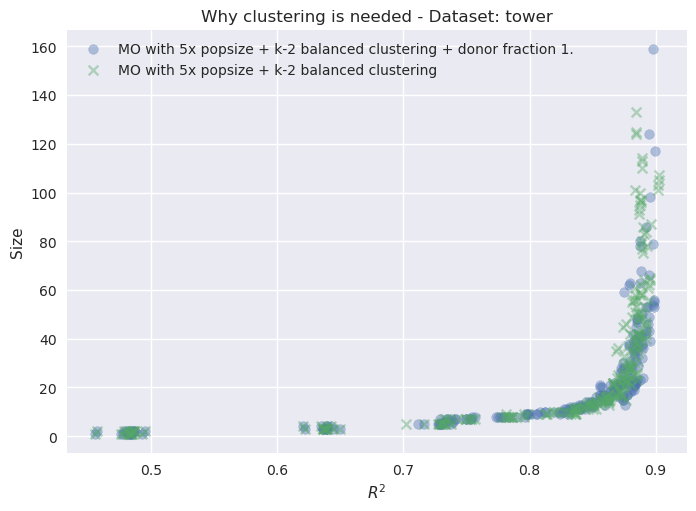

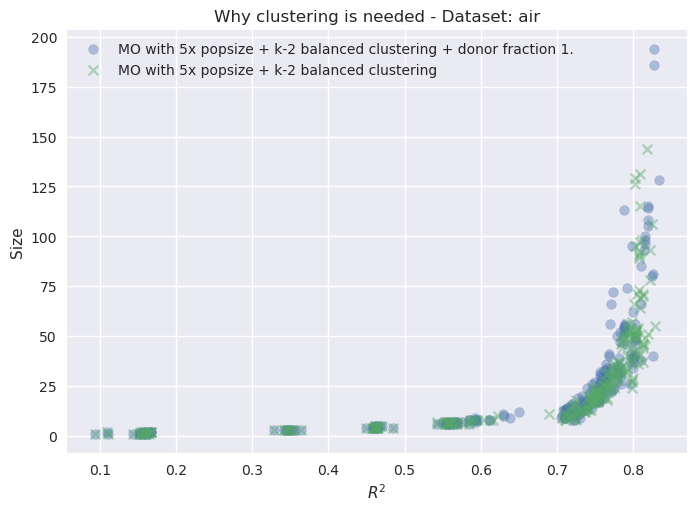

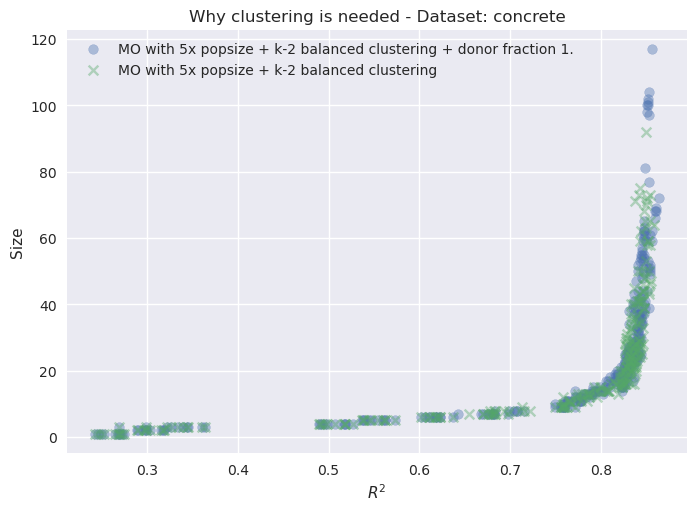

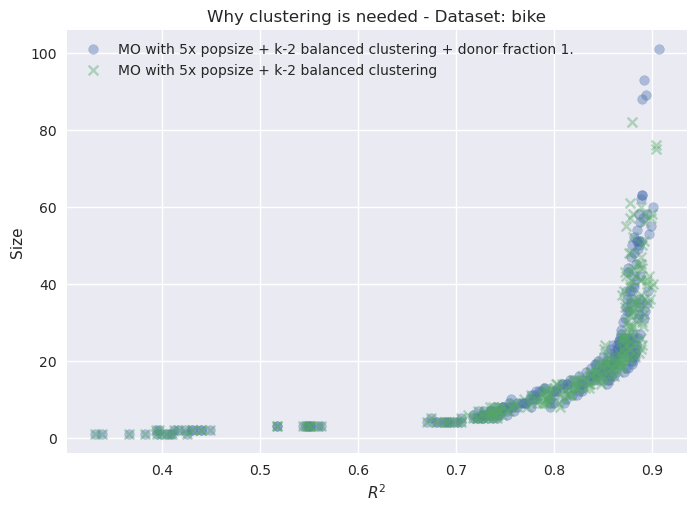

In [60]:
algorithms = ["MO_equalclustersize_balanced_frac1", "MO_equalclustersize_k2_frac1","MO_equalclustersize_balanced", "MO_equalclustersize_k2", "MO_equalclustersize_frac1", "MO_equalclustersize", "MO_k2", "MO_balanced"]
algorithms = ["MO_equalclustersize_k2_frac1","MO_equalclustersize_k2"]
datasets = ["dowchemical","tower", "air", "concrete", "bike"]
for dataset in datasets:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

make_latex_table(algorithms, datasets, dataset_filename)
make_plot(dataset_filename, datasets, algorithms, "Ablations", ["x","y"], axes_labels = [r'$R^2$', 'Size'])

# Another issue: duplicate solutions

DATASET: DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample 0.817 39.4
MO_equalclustersize_k2_frac1        0.823 48.9
SO                                  0.846 172.4
SO_equalclustersize_sample          0.801 24.3
Significantly better: SO
DATASET: TOWER
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample 0.887 34.7
MO_equalclustersize_k2_frac1        0.887 47.0
SO                                  0.897 160.0
SO_equalclustersize_sample          0.883 19.0
DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample 0.8 34.0
MO_equalclustersize_k2_frac1        0.795 59.5
SO                                  0.815 215.0
SO_equalclustersize_sample          0.798 26.7
DATASET: CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample 0.843 38.2
MO_equalclustersize_k2_frac1        0.844 54.3
SO           

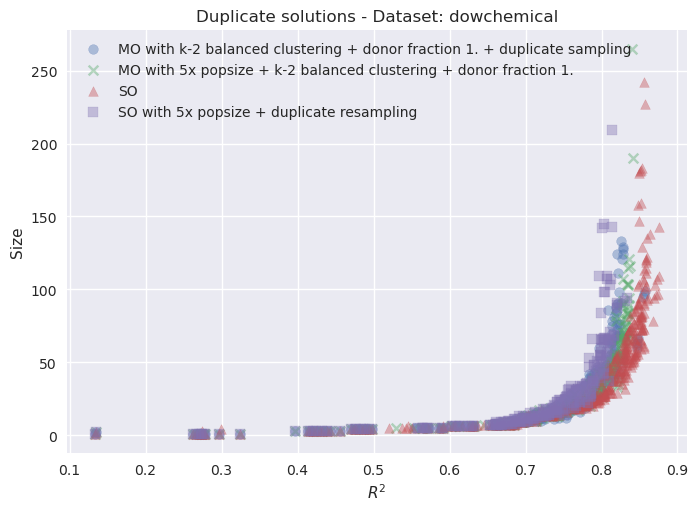

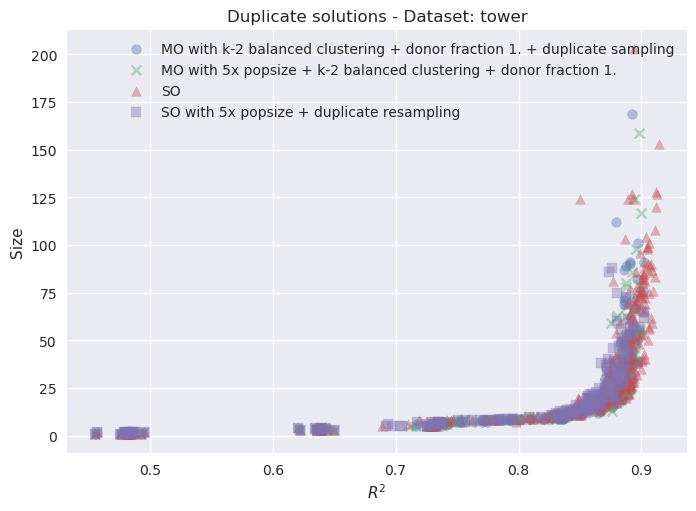

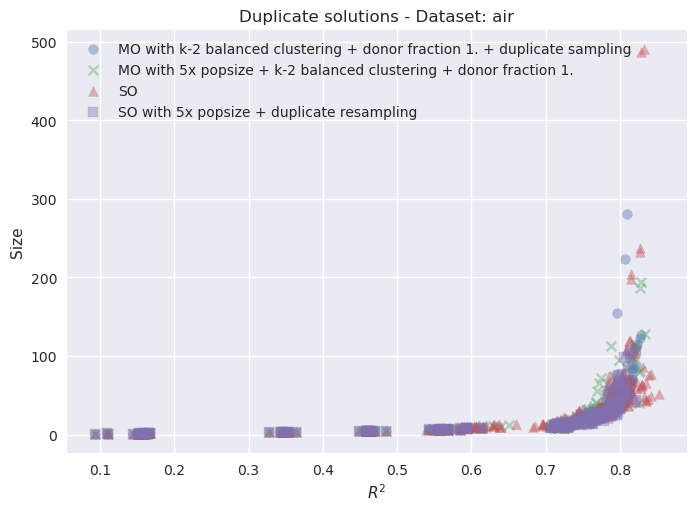

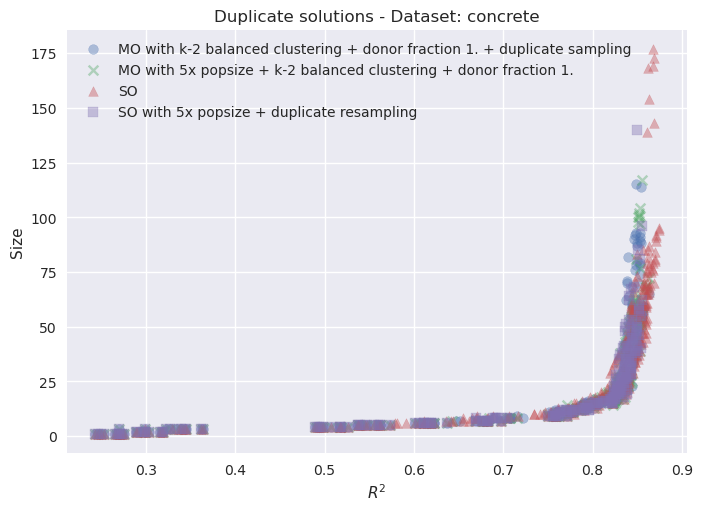

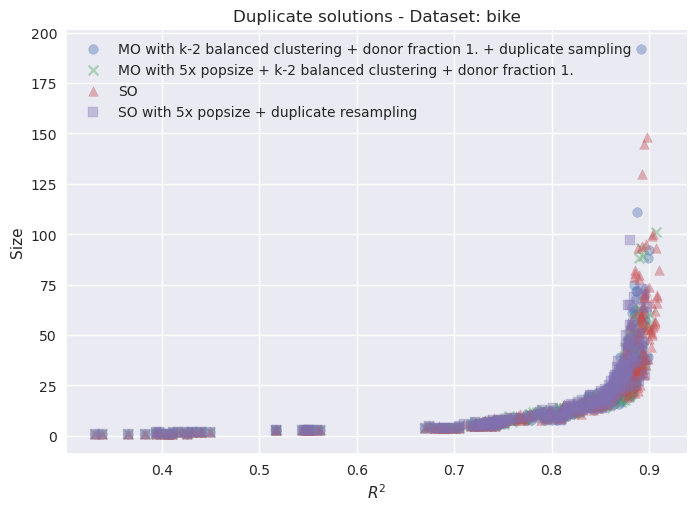

In [64]:
algorithms = ["MO_equalclustersize_k2_frac1_sample", "MO_equalclustersize_k2_frac1", "SO", "SO_equalclustersize_sample"]
datasets = ["dowchemical","tower", "air", "concrete", "bike"]
for dataset in datasets:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

make_latex_table(algorithms, datasets, dataset_filename)
make_plot(dataset_filename, datasets, algorithms, "Duplicate solutions", ["x","y"], axes_labels = [r'$R^2$', 'Size'])

DATASET: DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full 0.817 39.2
MO_equalclustersize_k2_frac1        0.823 48.9
DATASET: TOWER
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full 0.887 34.7
MO_equalclustersize_k2_frac1        0.887 47.0
DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full 0.8 33.8
MO_equalclustersize_k2_frac1        0.795 59.5
DATASET: CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full 0.843 38.2
MO_equalclustersize_k2_frac1        0.844 54.3
DATASET: BIKE
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full 0.885 42.2
MO_equalclustersize_k2_frac1        0.882 58.6

\begin{table}[]
\begin{tabular}{lll}
Dataset      & MO with k-2 balanced clustering + donor fraction 1. + duplicate sampling + ful

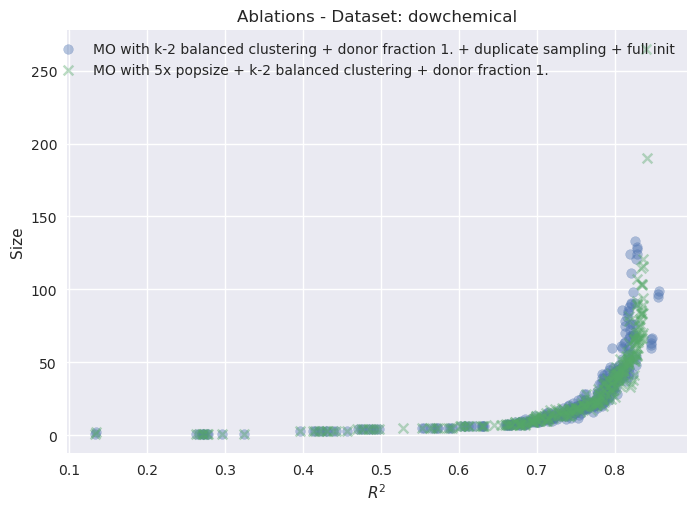

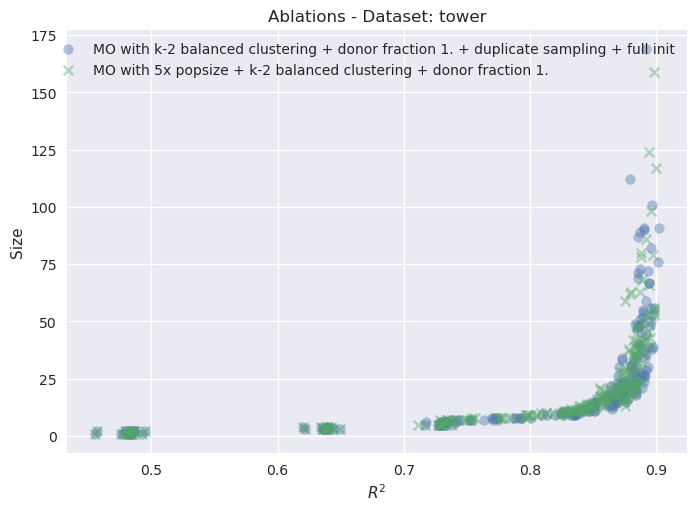

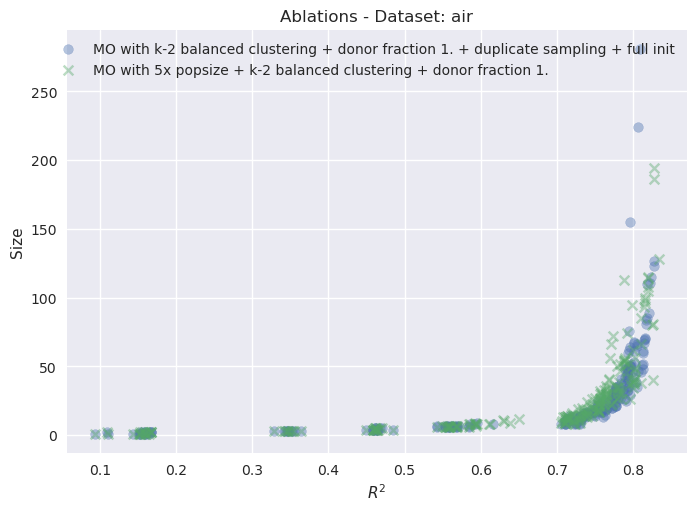

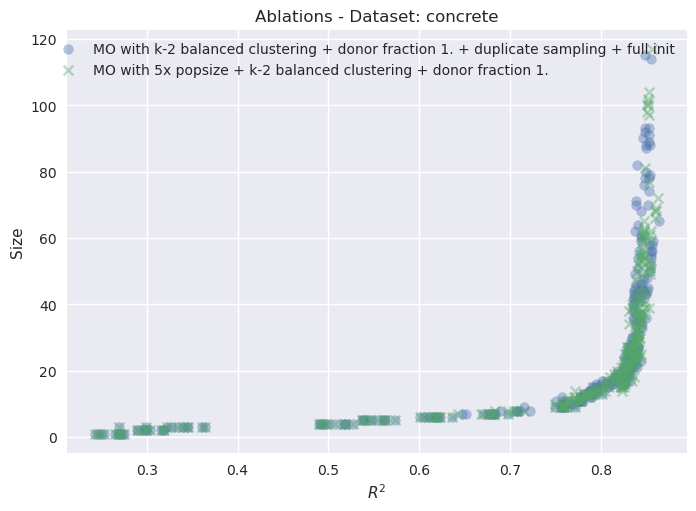

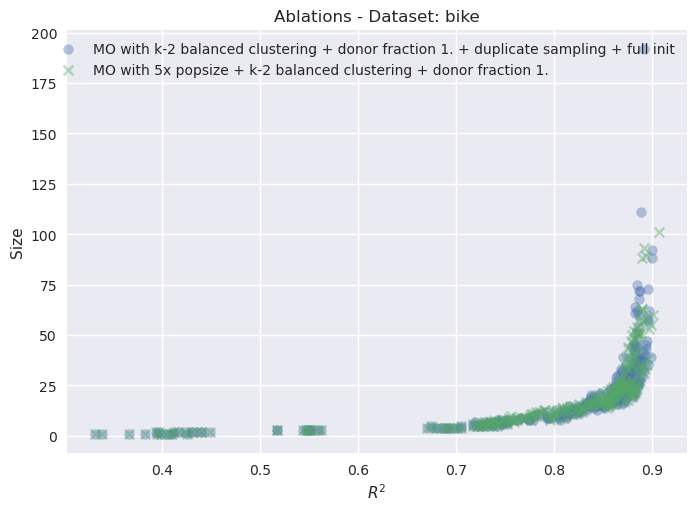

In [65]:
algorithms = ["MO_equalclustersize_k2_frac1_sample_full", "MO_equalclustersize_k2_frac1"]
datasets = ["dowchemical","tower", "air", "concrete", "bike"]
for dataset in ["dowchemical","tower", "air", "concrete", "bike"]:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(35), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

make_latex_table(algorithms, datasets, dataset_filename)
make_plot(dataset_filename, datasets, algorithms, "Ablations", ["x","y"], axes_labels = [r'$R^2$', 'Size'])

# Discounting re-use

DATASET: SYNTHETIC_1
----------------------------------------------------------
MO                                       0.405 0.404 161.2
MO_discounted                            0.389 0.389 159.8
DATASET % functions % duplicates % functions containing any
synthetic_1 2.70 0.40 0.50
DATASET % functions % duplicates % functions containing any
synthetic_1 1.90 0.00 0.50
DATASET: SYNTHETIC_2
----------------------------------------------------------
MO                                       0.898 0.897 147.4
MO_discounted                            0.899 0.895 116.4
DATASET % functions % duplicates % functions containing any
synthetic_2 7.30 4.70 0.60
DATASET % functions % duplicates % functions containing any
synthetic_2 7.80 5.10 0.80
DATASET: SYNTHETIC_3
----------------------------------------------------------
MO                                       0.469 0.466 152.7
MO_discounted                            0.516 0.511 136.5
DATASET % functions % duplicates % functions containing an

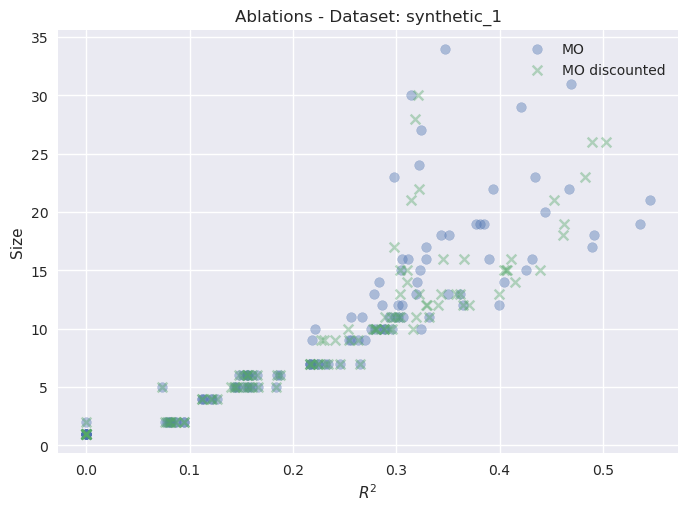

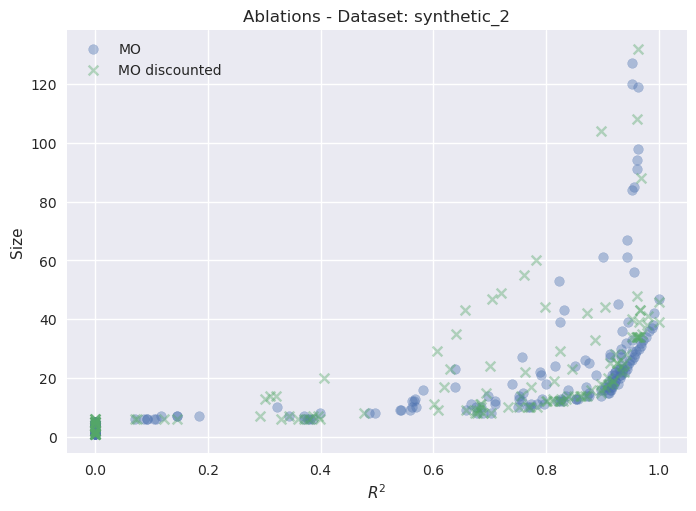

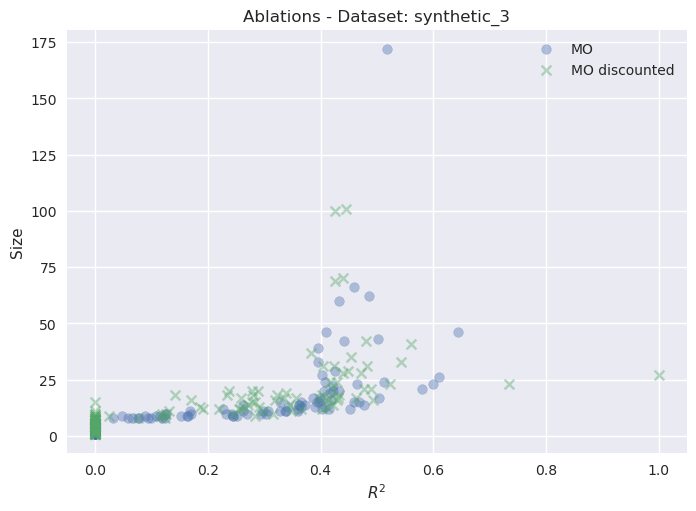

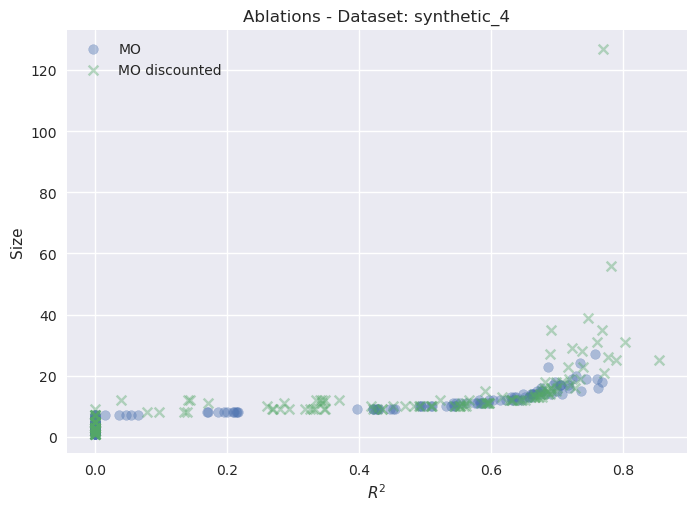

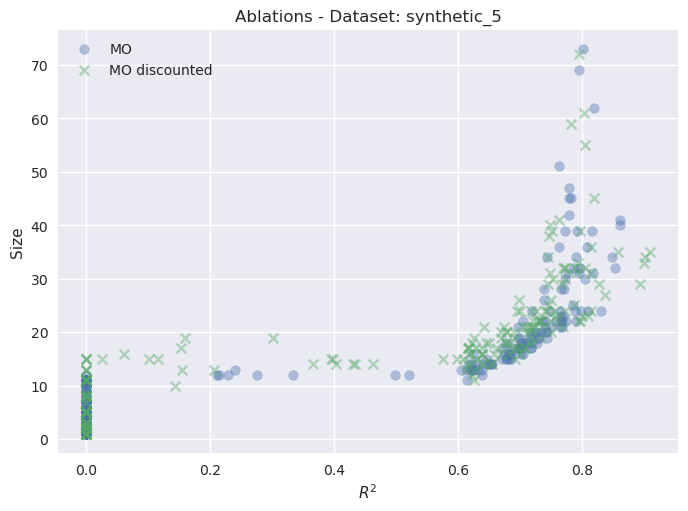

In [89]:
from collections import defaultdict
from collections import Counter

def replace_translation(stri, d, reverse):

    for k in sorted(d.keys(), reverse=reverse):
        stri = stri.replace(str(k), str(d[k]))
    return stri




def get_nr_reuses(dataset, algorithm):
    print("DATASET", "% functions", "% duplicates", "% functions containing any")
    
    nr_exprs = 0
    nr_dupls = 0
    nr_funcs = 0
    size_reason = 0
    contains_any = 0
    
    nr_dupls2 = 0

    def find_duplicates(lst):
        # Count occurrences of each element in the list
        counter = Counter(lst)
        # Filter and return elements that have more than one occurrence
        duplicates = [item for item, count in counter.items() if count > 1]
        
        dupl_count = 0
        for _, count in counter.items():
            if count>1:
                dupl_count += count - 1
                
        return duplicates, dupl_count
    
    def replace_any(stri):
        stri = stri.replace("any[", "any{")

        bracket_counter = 0
        replacement_indices = []
        found = []
        for idx, char in enumerate(stri):
            if char == "[":
                bracket_counter += 1
            if char == "]":
                bracket_counter -= 1
                if bracket_counter in found:
                    found.remove(bracket_counter)
                    replacement_indices.append(idx)

            if char == "{":
                found.append(bracket_counter)
                bracket_counter += 1

        stri = list(stri)
        for idx in replacement_indices:
            stri[idx] = "}"

        return ''.join(stri)
    
    def replace_any_with_x(s):
        result = []
        stack = []
        i = 0

        while i < len(s):
            if s[i:i+4] == 'any{':
                stack.append(i)
                result.append('any{x}')
                i += 4
                while stack:
                    if s[i:i+4] == 'any{':
                        stack.append(i)
                        i += 4
                    elif s[i] == '}':
                        stack.pop()
                        i += 1
                    else:
                        i += 1
            else:
                result.append(s[i])
                i += 1

        return ''.join(result)

    def remove_any_expressions(s):
        def recursive_remove(sub_s):
            result = []
            stack = []
            i = 0

            while i < len(sub_s):
                if sub_s[i:i+4] == 'any{':
                    stack.append(i)
                    i += 4
                elif sub_s[i] == '}' and stack:
                    start = stack.pop()
                    if not stack:
                        i += 1  # Skip the closing bracket of 'any[' block
                elif not stack:
                    result.append(sub_s[i])
                    i += 1
                else:
                    result.append(sub_s[i])
                    i += 1

            result_str = ''.join(result)
            if 'any{' in result_str:
                return recursive_remove(result_str)
            else:
                return result_str

        return recursive_remove(s)


    def find_func_calls(s):
        result = []

        def extract_func_calls(sub_s):
            stack = []
            start = 0
            while start < len(sub_s):
                if sub_s[start:start+5] == 'func[':
                    stack.append(start)
                    start += 5
                elif sub_s[start] == ']' and stack:
                    opening = stack.pop()
                    if not stack:
                        inner_expression = sub_s[opening+5:start]
                        result.append(inner_expression)
                        # Recursively extract any nested func calls
                        extract_func_calls(inner_expression)
                    start += 1
                else:
                    start += 1

   
        extract_func_calls(s)
        return result

    functions = []
    any_functions = []
    # Loop over all files
    for filename in glob.glob("./results/prelim/*{}_{}.csv".format(algorithm, dataset)):
        nr = filename.split("/")[-1].split("_")[0]
        d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")
        df = pd.read_csv(filename, sep="\t", header=None)
    
        # Read string from file
        stri = df.iloc[0][6]
        
        if 'any' in stri:
            contains_any += 1

        # Replace any[ and matching bracket with any{}
        stri = replace_any(stri)
    
        # Recursively obtain list of subexpressions
        subexpressions = find_func_calls(stri)
            
        # Replace any{subexpressions} non-recursively with any{x}
        subexpressions_any_x = []
        for subexpression in subexpressions:
            subexpressions_any_x.append(replace_any_with_x(subexpression))
        
        nr_exprs += 1

        nr_funcs += len(subexpressions_any_x)

        dupls, dupl_count = find_duplicates(subexpressions_any_x)

        
        nr_dupls += dupl_count

        if(float(df.iloc[-1][3])>31):
            size_reason += len(subexpressions)
            

            
    if(nr_exprs>0):
        print(dataset, "{0:.2f}".format(nr_funcs/nr_exprs), 
              "{0:.2f}".format(nr_dupls/nr_exprs), 
              #"{0:.2f}".format(size_reason/nr_exprs), 
              "{0:.2f}".format(contains_any/nr_exprs))
    
    function_per_dataset[dataset].extend(functions)
    any_function_per_dataset[dataset].extend(any_functions)

    


algorithms = ["MO", "MO_discounted"]
datasets = ["synthetic_1","synthetic_2","synthetic_3","synthetic_4","synthetic_5"]
for dataset in ["synthetic_1","synthetic_2","synthetic_3","synthetic_4","synthetic_5"]:
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        
        print(algorithm.ljust(40), "{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv_discount"]),"{:.3}".format(dataset_filename[dataset][algorithm]["avg_hv"]), np.mean(dataset_filename[dataset][algorithm]["gens"]))
        meds.append(dataset_filename[dataset][algorithm]["hvs_discount"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass
    for algorithm in algorithms:
        get_nr_reuses(dataset, algorithm)
        

make_latex_table(algorithms, datasets, dataset_filename)
make_plot(dataset_filename, datasets, algorithms, "Ablations", ["x","y"], axes_labels = [r'$R^2$', 'Size'])

# Different objective


3 OBJECTIVES
DATASET: DOWCHEMICAL
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full_2objs 0.82
SO_equalclustersize_sample_full_2objs    0.813
Significantly better: MO_equalclustersize_k2_frac1_sample_full_2objs
DATASET: TOWER
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full_2objs 0.857
SO_equalclustersize_sample_full_2objs    0.857
DATASET: AIR
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full_2objs 0.799
SO_equalclustersize_sample_full_2objs    0.811
DATASET: CONCRETE
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full_2objs 0.842
SO_equalclustersize_sample_full_2objs    0.846
Significantly better: SO_equalclustersize_sample_full_2objs
DATASET: BIKE
----------------------------------------------------------
MO_equalclustersize_k2_frac1_sample_full_2objs 0.428
SO_equalclustersize_sample_fu

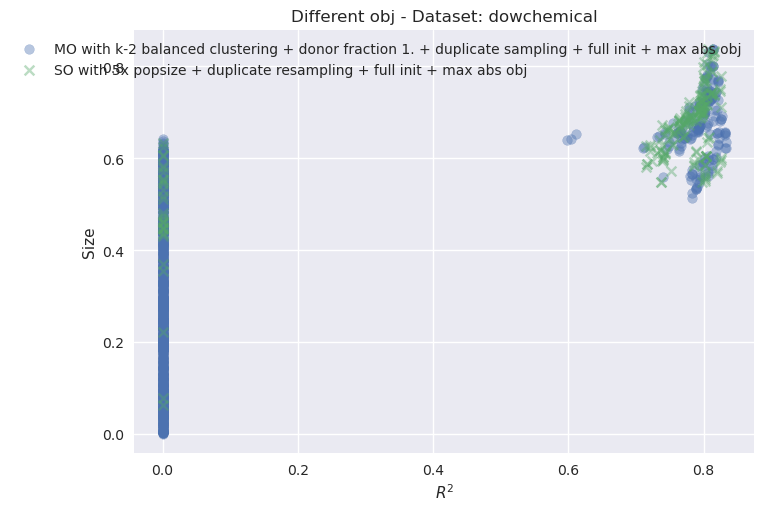

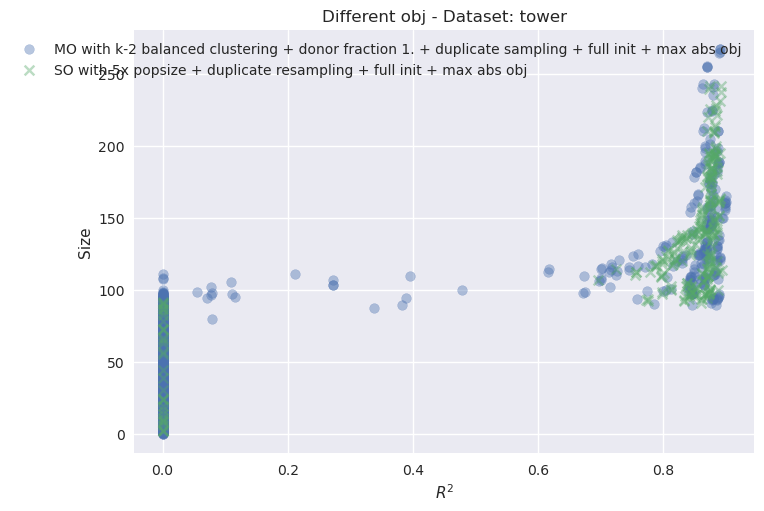

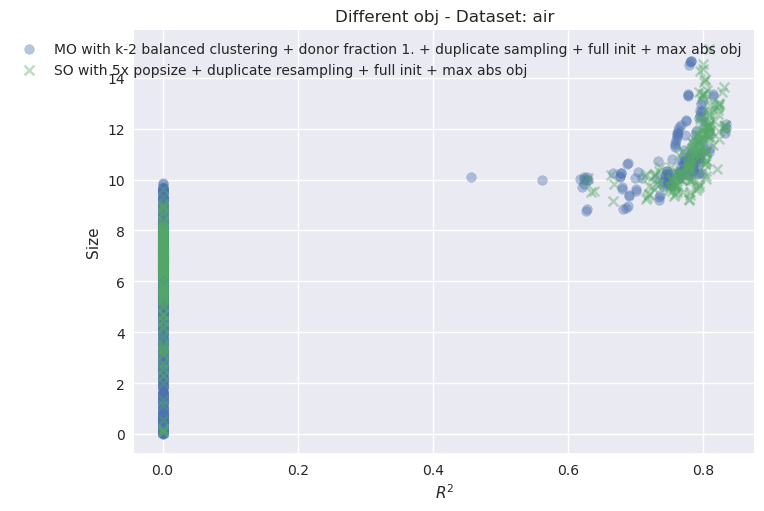

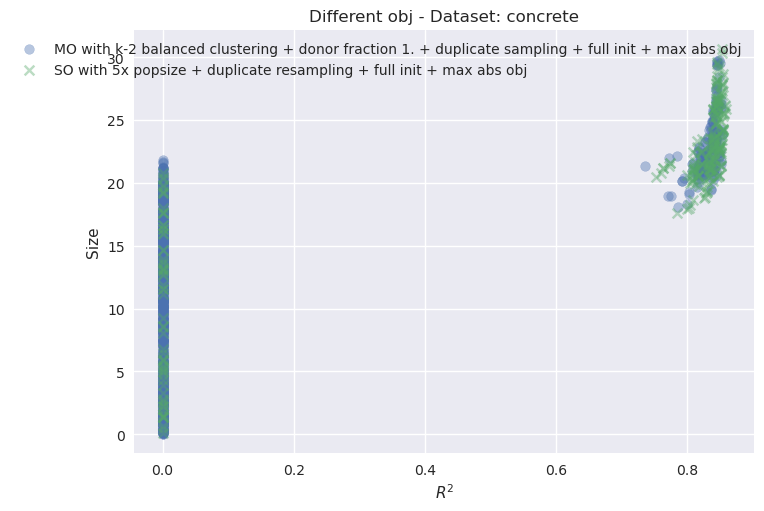

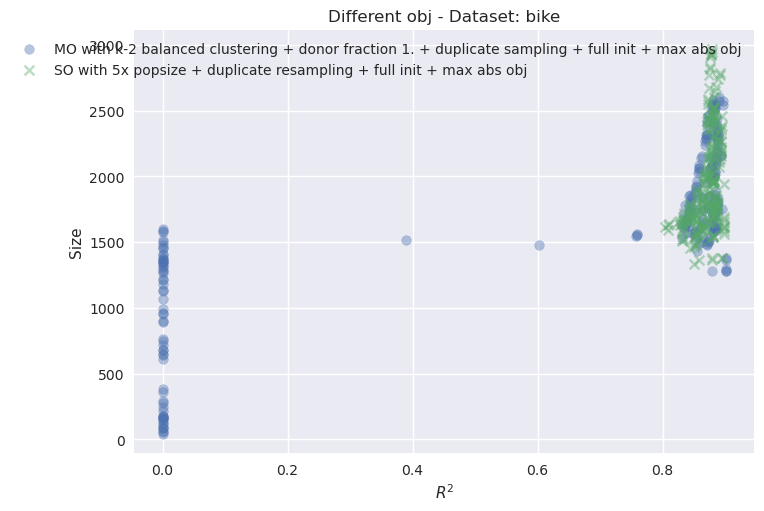

In [71]:
algorithms = ["MO_equalclustersize_k2_frac1_sample_full_2objs", "SO_equalclustersize_sample_full_2objs"]
datasets = ["dowchemical","tower", "air", "concrete", "bike"]
print("\n3 OBJECTIVES")
for dataset in datasets:
    
    
    print("DATASET:", dataset.upper())
    print("-"*58)
    meds = []

    for algorithm in algorithms:
        print(algorithm.ljust(40), "{:.3}".format(dataset_filename_2objs[dataset][algorithm]["avg_hv_3d"]))
        meds.append(dataset_filename_2objs[dataset][algorithm]["hvs_3d"])
        
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print("Significantly better:", algorithms[get_significantly_better_index(meds)])
    except:
        pass

make_latex_table(algorithms, datasets, dataset_filename_2objs, "_3d")
make_plot(dataset_filename_2objs, datasets, algorithms, "Different obj", ["x","z"], axes_labels = [r'$R^2$', 'Size'])

In [72]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
import glob
import traceback




# plt.style.use('seaborn')
import os

def read_tsv_file(file_path):
    try:
        # Read the TSV file into a pandas DataFrame
        df = pd.read_csv(file_path, header=None, sep='\t')
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


def process_row(row, max_mse, max_len, max_complexity, df_var, data, update_max=False, grid=False):
    coordinates = []
    # Split each long line by ';' to get individual coordinate strings
    coordinate_strings = row[0].split(';')
    for coord_str in coordinate_strings:
        # Split each coordinate string by ',' to get x, y, z values
        if(grid):
            x, y, z, z1, z2, z3, _ = coord_str.replace("inf","-1").split(',')
            coordinates.append((float(x), float(y), float(z), float(z1), float(z2), float(z3)))
        else:
            x, y, z, z1, z2, z3 = coord_str.replace("inf","-1").split(',')
            if x!="-1":
                x = (1. - float(x)/float(df_var))
            coordinates.append((max(float(x),0.), float(y), float(z), int(z1), int(z2), int(z3)))



        if update_max:
            if 1. - float(x)/float(df_var)<max_mse and int(float(x)) !=-1:
                max_mse = 1. - float(x)/float(df_var)
            if float(y)>max_len and int(float(x))!=-1:
                max_len = float(y)
            if float(z)>max_complexity and int(float(x))!=-1:
                max_complexity = float(z)

    data.append(coordinates)
    return max_mse, max_len, max_complexity

def process_rows(df, df_var):
    # initialise maxes to 0
    max_len = 0
    max_mse = 0
    max_complexity = 0
    processed_data = []
    processed_cluster_data = []
    processed_donor_data = []
    processed_front_data = []
    processed_minmax = []
    
    
    for index, row in df.iterrows():
        # fitness mse, fitness size, fitness kommenda, cluster_id, cluster type, cluster size
        # Population
        if index%5==0:
            max_mse, max_len, max_complexity = process_row(row, max_mse, max_len, max_complexity, df_var, processed_data, update_max=True)
        # Clustered Population
        if index%5==1:
            process_row(row, max_mse, max_len, max_complexity, df_var, processed_cluster_data, update_max=True)
        # Clustered Donors
        if index%5==2:
            process_row(row, max_mse, max_len, max_complexity, df_var, processed_donor_data, update_max=True)
        # Archive
        if index%5==3:
            process_row(row, max_mse, max_len, max_complexity, df_var, processed_front_data, update_max=True)
        # Grid min maxes
        if index%5==4:
            process_row(row, max_mse, max_len, max_complexity, df_var, processed_minmax, update_max=False, grid=True)

    return processed_data, processed_cluster_data, processed_donor_data, processed_front_data, processed_minmax, max_len, max_mse, max_complexity


def update(frame):
    # With 2 objs 3 is MO and with 3 objs 4 is MO
    obj_names = {0:"MSE", 1:"Expression size", 2:"complexity", 3:"MO", 4:"MO", -1:"None"}
    ax.clear()

    best_mse_ind = (0,999999,999999,-1)
    best_size_ind = (0,999999,999999,-1)
    best_complexity_ind = (0,999999,999999,-1)

    row = data[frame]



    # min_0, min_1, max_0, max_1, num_box = minmax[frame][0]
    # linspace_0 = np.linspace(min_0,max_0,num_box)
    #
    # for vline in linspace_0:
    #     plt.axvline(x = vline, color = 'b', linestyle='dashed', alpha=0.5)
    #
    # linspace_1 = np.linspace(min_1,max_1,num_box)
    #
    # for hline in linspace_1:
    #     plt.axhline(y = hline, color = 'b', linestyle='dashed', alpha=0.5)

    sorted_by_z = [[],[],[],[],[],[],[]]

    for coord in row:


      x = float(str(coord[0]).replace("-1.0", str(max_mse)))  
      y = float(str(coord[1]).replace("-1.0", str(max_len)))
      z = float(str(coord[2]).replace("-1.0", str(max_complexity)))
      sorted_by_z[coord[3]].append((x, y, z, coord[4], coord[5]))


    x_idx = 0
    y_idx = 1

    for z_val, row in enumerate(sorted_by_z):
      if(len(row)>0):
          x_vals = [coord[x_idx] for coord in row]
          y_vals = [coord[y_idx] for coord in row]
          
          print(row[0])
          #Cluster id={z_val} 
          ax.scatter(x_vals, y_vals, label=f'Objective={obj_names[int(row[0][3])]} Cluster size={row[0][4]}', alpha=0.5)

          for coord in row:
              if coord[0]>best_mse_ind[0]:
                best_mse_ind = (coord[0],coord[1],coord[2],z_val,row[0][3],row[0][4])
              if coord[1]<=best_size_ind[1]:
                best_size_ind = (coord[0],coord[1],coord[2],z_val,row[0][3],row[0][4])
              if coord[2]<best_complexity_ind[2]:
                  best_complexity_ind = (coord[0],coord[1],coord[2],z_val,row[0][3],row[0][4])

    # ax.set_ylim(0,200)
    # ax.set_xlim(0,4000)


    ax.scatter(best_mse_ind[x_idx],best_mse_ind[y_idx],marker='x', label=f'Objective={obj_names[int(best_mse_ind[4])]}')
    ax.scatter(best_size_ind[x_idx],best_size_ind[y_idx],marker='x', label=f'Objective={obj_names[int(best_size_ind[4])]}')
    #ax.scatter(best_complexity_ind[x_idx],best_complexity_ind[y_idx],marker='x', label=f'Cluster id={best_complexity_ind[4]}, Objective={obj_names[int(best_complexity_ind[4])]}')



    idx_to_label = {0:r"$R^2$", 1:"Expression size", 2:"Complexity"}

    ax.set_xlabel(idx_to_label[x_idx])
    ax.set_ylabel(idx_to_label[y_idx])
    ax.set_title(f'Dataset Concrete - Generation {frame+1}')
    ax.legend()


def update2(frame):
    obj_names = {0:"MSE", 1:"size", 3:"MO", -1:"None"}
    ax.clear()

    colors = ['b','g','r','c','m','y','k']

    row = data[frame]

    sorted_by_z = [[],[],[],[],[],[],[]]

    for coord in row:
      x = float(str(coord[0]).replace("-1.0", str(0.)))  
      y = float(str(coord[1]).replace("-1.0", str(max_len)))  
      sorted_by_z[coord[2]].append((x, y, coord[3], coord[4]))

    for z_val, row in enumerate(sorted_by_z):
      if(len(row)>0):
          x_vals = [coord[0] for coord in row]
          y_vals = [coord[1] for coord in row]
          ax.scatter(x_vals, y_vals, label=f'Cluster id={z_val} objective={obj_names[int(row[0][2])]} Cluster size={row[0][3]}', alpha=0.5, marker="x", color=[colors[z_val]])

    row = data2[frame]
    sorted_by_z = [[],[],[],[],[],[],[]]

    for coord in row:
      x = float(str(coord[0]).replace("-1.0", str(max_mse)))  
      y = float(str(coord[1]).replace("-1.0", str(max_len)))  
      sorted_by_z[coord[2]].append((x, y, coord[3], coord[4]))

    for z_val, row in enumerate(sorted_by_z):
      if(len(row)>0):
          x_vals = [coord[0] for coord in row]
          y_vals = [coord[1] for coord in row]
          if(z_val == 2):
            ax.scatter(x_vals, y_vals, label=f'Cluster # {z_val} objective={obj_names[int(row[0][2])]} Cluster size={row[0][3]}', alpha=0.2, marker="o", color=[colors[z_val]])
    
    
    
    ax.set_xlabel('MSE')
    ax.set_ylabel('Expression size')
    ax.set_title(f'Generation {frame+1}')
    ax.legend()    


def make_frames(data, folder, title):
    global ax
    fig, ax = plt.subplots()
    

    ani = FuncAnimation(fig, update, frames=50, interval=1000)

    directory = f'./frames/{folder}'
    isExist = os.path.exists(directory)
    if not isExist:
        os.makedirs(directory)

    for i in range(len(data)):
        update(i)
        plt.savefig(f'{directory}/{title}_{i:04d}.png',dpi=600,bbox_inches="tight")

def make_frames2(data, data2, folder, title):
    global ax
    fig, ax = plt.subplots()

    ani = FuncAnimation(fig, update2, frames=len(data), interval=1000)

    directory = f'./frames/{folder}'
    isExist = os.path.exists(directory)
    if not isExist:
        os.makedirs(directory)

    for i in range(len(data)):
        update2(i)
        plt.savefig(f'{directory}/{title}_{i:04d}.png',dpi=600,bbox_inches="tight")

def rreplace(s, old, new, occurrence):
    li = s.rsplit(old, occurrence)
    return new.join(li)

# Iterate over designated runs with logpop turned on.
for filename in glob.glob("./results/prelim/pop/*"):
    # Each file gets its own folder 11_MO_balanced_concrete.csv -> MO_balanced_concrete
    folder = filename.split("/")[-1][3:-4]
    # Get valiadation variance from other file
    df_var = pd.read_csv(filename.replace("/pop/","/"),header=None, sep="\t").iloc[-1][7]
    
    df = read_tsv_file(filename)

    try:
        # population, cluster, donor clusters, front, min max of grid
        processed_data, processed_cluster_data, processed_donor_data, processed_front_data, processed_minmax, max_len, max_mse, max_complexity = process_rows(df, df_var)

        # Limit to n generations
        n_gens = 50
        data = processed_front_data[:n_gens]
        
        minmax = processed_minmax
#         make_frames(data, folder, "front")

        data = processed_cluster_data[:n_gens]
        make_frames(data, folder, "pop")
    #
    # data = processed_cluster_data
    # data2 = processed_donor_data
    # make_frames2(data, data2, folder, "donors")
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        pass




In [78]:
!ls results/prelim/*

results/prelim/10_MO_air.csv
results/prelim/10_MO_balanced_air.csv
results/prelim/10_MO_balanced_bike.csv
results/prelim/10_MO_balanced_concrete.csv
results/prelim/10_MO_balanced_dowchemical.csv
results/prelim/10_MO_balanced_frac1_air.csv
results/prelim/10_MO_balanced_frac1_bike.csv
results/prelim/10_MO_balanced_frac1_concrete.csv
results/prelim/10_MO_balanced_frac1_dowchemical.csv
results/prelim/10_MO_balanced_frac1_tower.csv
results/prelim/10_MO_balanced_tower.csv
results/prelim/10_MO_bike.csv
results/prelim/10_MO_concrete.csv
results/prelim/10_MO_discounted_synthetic_1.csv
results/prelim/10_MO_discounted_synthetic_2.csv
results/prelim/10_MO_discounted_synthetic_3.csv
results/prelim/10_MO_discounted_synthetic_4.csv
results/prelim/10_MO_discounted_synthetic_5.csv
results/prelim/10_MO_dowchemical.csv
results/prelim/10_MO_equalclustersize_air.csv
results/prelim/10_MO_equalclustersize_balanced_air.csv
results/prelim/10_MO_equalclustersize_balanced_bike.csv
results/prelim/10_MO_equalclust

In [ ]:
HV over TIME!!!!!!!!!!!!!!

0.475
0.9


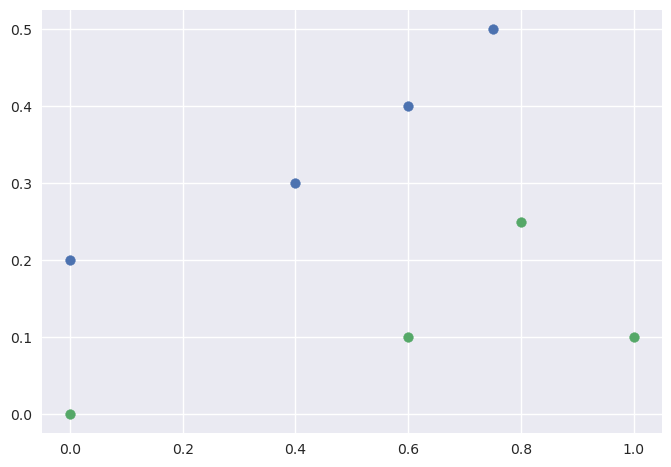

In [69]:
data_x = np.array([0., 0.4, 0.6, 0.75])
data_y = [0.2, 0.3, 0.4, 0.5]

data_x_2 = np.array([0., 0.8, 0.6, 1.])
data_y_2 = [0.0, 0.25, 0.1, 0.1]

ref_point = np.array([1., 1.])
ind = HV(ref_point=ref_point)

result = np.column_stack((1.-data_x, data_y))
print(ind(result))
result = np.column_stack((1.-data_x_2, data_y_2))
print(ind(result))

plt.figure()
plt.scatter(data_x, data_y)
plt.scatter(data_x_2, data_y_2)


